# AlphaPept Systems Check

This notebook will run several tests and compare the performance to MaxQuant. Depending on the machine, this can take several hours.
Each run is called via the `test_ci.py` script, which downloads files to a temporary folder which can be specified in this file.

This notebook requires the `matplotlib_venn` (`!pip install matplotlib_venn`) package.

## Reference Data

Download MaxQuant reference files. Referance MaxQuant data from `PXD006109` and `PXD010012` were taken from the paper, the others were analyzed with `MaxQuant_1.6.14`, default settings w/o second peptides and provided with the given contaminants file.

In [9]:
import os
import sys
sys.path.append(os.path.join(".."))
import test_ci

try:
    import wget
except ImportError:
    !pip install wget
    import wget
    
FILE_DICT = {}
#FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/1E2G1IwgcgdsCHC/download' #OLD MQ FILES
#FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/Fn2uxeYNL60JSd3/download'

#FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/vMNferEoSoROJbb/download' #AP Files
#FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/KLBotZbodMByigh/download'

FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/fLhxQ8mVb29x9xH/download'
FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/BkMMHPregCQgKLg/download'
FILE_DICT['PXD010012_ref.txt'] = 'https://datashare.biochem.mpg.de/s/ps226k7Fme1K0jf/download'
FILE_DICT['PXD010012_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/pyhKMrytjdDU2sX/download'
FILE_DICT['bruker_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/fRcoGuwlcbH2SBJ/download'
FILE_DICT['thermo_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/p4Omj9K5hHmSoDl/download'

tmp_folder = os.path.join(os.getcwd(),'./temp')


BASE_DIR = os.path.join(tmp_folder, './test_files/') # Storarge location for test files
TEST_DIR = os.path.join(tmp_folder, './test_temp/')
ARCHIVE_DIR = os.path.join(tmp_folder, './test_archive/')

MONGODB_USER = 'github_actions'
MONGODB_URL = 'ci.yue0n.mongodb.net/'

if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)


test_ci.config_test_paths(BASE_DIR, TEST_DIR, ARCHIVE_DIR, MONGODB_USER, MONGODB_URL)


    
for file in FILE_DICT:
    target = os.path.join(tmp_folder, file)
    if not os.path.isfile(target):
        wget.download(FILE_DICT[file], target)
        
software_1 = 'AlphaPept'
software_2 = 'MaxQuant'

## Single Files

Compare to the single HeLa test files

### Thermo Hela

In [5]:
%run -i ../test_ci.py $tmp_folder thermo_irt

start processing, tmp folder is /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/./temp
2021-05-19 15:44:41> Creating dir /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/./temp/./test_temp/.
2021-05-19 15:44:41> Logging to /Users/constantin/alphapept/logs/log_20210519154441.txt.
2021-05-19 15:44:41> Platform information:
2021-05-19 15:44:41> system     - Darwin
2021-05-19 15:44:41> release    - 20.3.0
2021-05-19 15:44:41> version    - 10.16
2021-05-19 15:44:41> machine    - x86_64
2021-05-19 15:44:41> processor  - i386
2021-05-19 15:44:41> cpu count  - 8
2021-05-19 15:44:41> ram memory - 22.4/32.0 Gb (available/total)
2021-05-19 15:44:41> 
2021-05-19 15:44:41> Python information:
2021-05-19 15:44:41> SQLAlchemy     - 1.3.22
2021-05-19 15:44:41> alphapept      - 0.3.21
2021-05-19 15:44:41> biopython      - 1.78
2021-05-19 15:44:41> click          - 7.1.2
2021-05-19 15:44:41> comtypes       - 1.1.7
2021-05-19 15:44:41> fastcore       - 1.3.5
2021-05-19 

2021-05-19 15:44:41> FASTA contains 247 entries.


In [1]:
%run -i ../test_ci.py $tmp_folder thermo_hela

#test_ci.main(runtype = "thermo_hela", new_files = False)

Exception: File `'../test_ci.py'` not found.

In [ ]:
try:
    import matplotlib_venn
except ModuleNotFoundError:
    !pip install matplotlib_venn
    import matplotlib_venn

  Using cached matplotlib_venn-0.11.6-py3-none-any.whl


In [ ]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank
import os

df1, df2 = prepare_files(os.path.join(TEST_DIR,'thermo_HeLa.ms_data.hdf'), os.path.join(TEST_DIR,'thermo_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

OSError: Unable to open file (unable to open file: name = '/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/temp/test_temp/thermo_HeLa.ms_data.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Calling custom steps of the pipeline

Work with already processed results and call individual steps

--- ML ---
2021-05-09 00:13:04> 52,697 target (5,269 decoy) of 58500 PSMs. fdr 0.099987 for a cutoff of 18.11 (set fdr was 0.1)
2021-05-09 00:13:05> Training & cross-validation on 43834 targets and 43833 decoys
2021-05-09 00:23:03> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-09 00:23:03> The train accuracy was 0.9164223710176007
2021-05-09 00:23:03> Testing on 10958 targets and 10959 decoys
2021-05-09 00:23:04> The test accuracy was 0.905917780718164
2021-05-09 00:23:04> Top features {'y_hits': 0.289201934989806, 'x_tandem': 0.19068541472286799, 'hits': 0.16573498459015495, 'matched_ion_fraction': 0.05188418031345346, 'n_ions': 0.04886729417881352, 'matched_int_ratio': 0.03419142436436936, 'b_hits': 0.02779356582732514, 'n_missed': 0.022664116362938996, 'matched_int': 0.02167253895433971, 'o_mass': 0.02085078851665301, 'o_mass_ppm': 0.016534366273673655, 'o_mass_ppm_raw': 0.015142277231698191, 'mz': 0.013263876

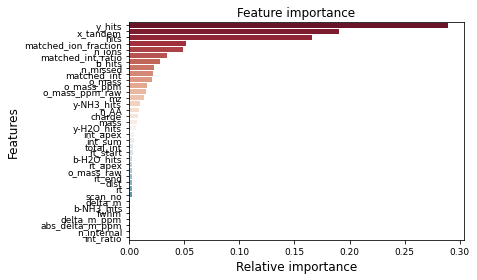

2021-05-09 00:23:04> Filter df with x_tandem score
2021-05-09 00:23:06> Global FDR on precursor
2021-05-09 00:23:06> 45,444 target (454 decoy) of 56802 PSMs. fdr 0.009990 for a cutoff of 0.47 (set fdr was 0.01)


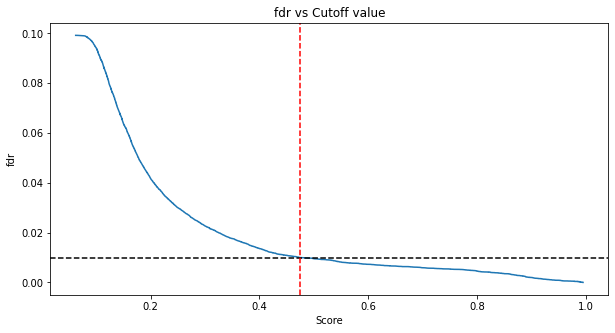

C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


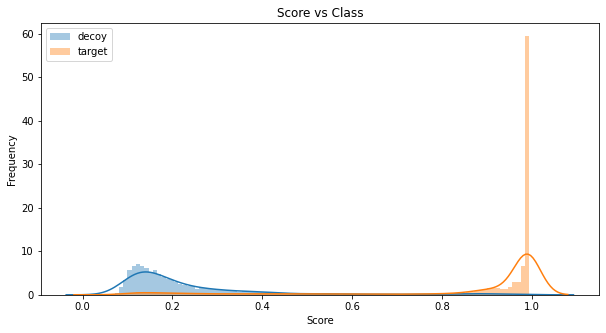

--- x! ---
2021-05-09 00:23:07> Filter df with x_tandem score
2021-05-09 00:23:07> Global FDR on precursor
2021-05-09 00:23:07> Last q_value 0.010 of dataset is smaller than fdr_level 0.010
2021-05-09 00:23:07> 45,444 target (454 decoy) of 45898 PSMs. fdr 0.009990 for a cutoff of 17.98 (set fdr was 0.01)


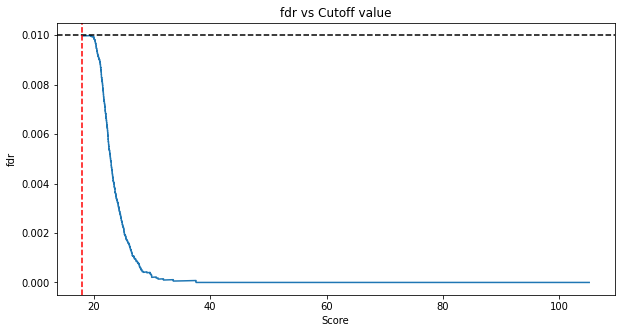

C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


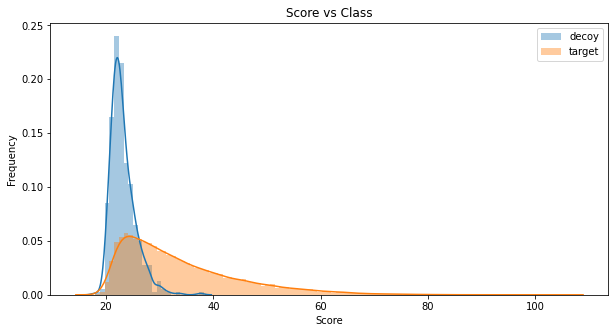

In [ ]:
import alphapept.io
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF

ms_file = alphapept.io.MS_Data_File(os.path.join(TEST_DIR,'thermo_HeLa.ms_data.hdf'))

df = ms_file.read(dataset_name='second_search')
df = get_ML_features(df)

print('--- ML ---')
cv, features = train_RF(df, plot=True)
df = filter_with_ML(df, cv, features = features)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

print('--- x! ---')
df = filter_with_x_tandem(df)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

### Bruker HeLa

In [ ]:
%run -i ../test_ci.py $tmp_folder bruker_hela

['../test_ci.py', 'bruker_hela'] 2
2021-05-09 00:23:09> Creating dir E:/test_temp/.
2021-05-09 00:23:13> Logging to C:\Users\admin\alphapept\logs\log_20210509002313.txt.
2021-05-09 00:23:13> Platform information:
2021-05-09 00:23:13> system     - Windows
2021-05-09 00:23:13> release    - 10
2021-05-09 00:23:13> version    - 10.0.18362
2021-05-09 00:23:13> machine    - AMD64
2021-05-09 00:23:13> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-09 00:23:13> cpu count  - 24
2021-05-09 00:23:13> ram memory - 105.9/127.7 Gb (available/total)
2021-05-09 00:23:13> 
2021-05-09 00:23:13> Python information:
2021-05-09 00:23:13> SQLAlchemy     - 1.3.22
2021-05-09 00:23:13> alphapept      - 0.3.20-dev0
2021-05-09 00:23:13> biopython      - 1.78
2021-05-09 00:23:13> click          - 7.1.2
2021-05-09 00:23:13> comtypes       - 1.1.7
2021-05-09 00:23:13> fastcore       - 1.3.5
2021-05-09 00:23:13> h5py           - 3.1.0
2021-05-09 00:23:13> lxml           - 4.6.2
2021-05-09 00




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 00:23:14> FASTA contains 36,789 entries.





  3%|█▋                                                              | 0.02702702702702703/1 [01:05<39:01, 2406.23s/it]


  5%|███▍                                                            | 0.05405405405405406/1 [01:06<16:09, 1024.47s/it]


  8%|█████▎                                                           | 0.08108108108108109/1 [01:08<08:55, 582.77s/it]


 11%|███████                                                          | 0.10810810810810811/1 [01:09<05:29, 369.65s/it]


 14%|████████▊                                                        | 0.13513513513513514/1 [01:10<03:36, 250.80s/it]


  0%|                                                                                            | 0/1 [12:16<?, ?it/s]



 19%|████████████▍                                                     | 0.1891891891891892/1 [01:12<01:52, 138.65s/it]


 22%|██████████████                                                   | 0.21621621621621623/1 [01:13<01:23, 106.58s/it]


 24%|███████████████

2021-05-09 00:25:22> Digested 36,789 proteins and generated 8,830,740 spectra
2021-05-09 00:27:12> Database saved to E:\test_temp\database.hdf. Filesize of database is 3.30 GB



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 00:27:27> Processing 1 files for step raw_conversion
2021-05-09 00:27:27> File E:/test_temp/bruker_HeLa has extension .d - converting from Bruker.
2021-05-09 00:56:55> File conversion complete. Extracted 299,728 precursors.
2021-05-09 00:57:05> File conversion of file E:/test_temp/bruker_HeLa.d complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 00:57:05> Processing 1 files for step find_features
2021-05-09 00:57:05> No *.hdf file with features found for E:/test_temp/bruker_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-09 00:57:06> Feature finding on E:/test_temp/bruker_HeLa.d
2021-05-09 00:57:06> Using Windows FF
2021-05-09 00:57:06> TopLevelUffWorkflow: Initializing 4d Feature Finder Workflow for lc-timstof data
2021-05-09 00:57:06> bdal.uff.TopLevelUffWorkflow: This is Universal Feature Finder 3.13.1.0
2021-05-09 00:57:06> 
2021-05-09 00:57:06> bdal.uff.cmdline: Parameters for ParameterSet path '':
2021-05-09 00:57:06> 
2021-05-09 00:57:06>  directory containing the data to be processed." , "required":true , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"E:/test_temp/bruker_HeLa.d"}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> nable lcms denoising. Will only denoise if the data has not been denoised already

2021-05-09 00:57:06> 
2021-05-09 00:57:06>  non-deconvoluted peaks are filled up." , "required":false , "hidden":true , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":"[topN,threshold] (class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >)" , "value":"topN"}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> , all raw peaks are written. Otherwise, only deisotoped peaks are written" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> ':
2021-05-09 00:57:06> 
2021-05-09 00:57:06> 
2021-05-09 00:57:06> :
2021-05-09 00:57:06> 
2021-05-09 00:57:06> c":"intensity threshold for matching calibrant peaks" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> able lock mass calibration" , "required":false , "hidden":false , "type":"bool" , "constraint"

2021-05-09 00:57:06> 
2021-05-09 00:57:06> :"end (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> c":"begin (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> mum intensity of a calibrant" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> lag indicating which algorithm to use: false = use calibration-segment, true = do not use calibration-segment, default = false" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-09 00:57:06> 
2021-05-09 00:57:06> sc":"vector of vector with lower rt boundaries for the reference peaks for segment-free calibration only" , "required":false , "hidden":false , "type":"class std::vector<class std::vector

2021-05-09 00:57:07>  "desc":"Lower RT value for range to look for mobility calibrants" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> .Calibration.ReadTimsCalibrants':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> Ms.Calibration.WriteCalibration':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> "vector of CCS values of reference peaks for mobility calibration" , "required":false , "hidden":false , "type":"class std::vector<double,class std::allocator<double> >" , "constraint":null , "value":[]}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> .Calibration.WriteCalibration':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> Ms.ClusterDeisotoping':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> ":"Ions must have at least this absolute abundance to be used as seed cluster for a component. Default 0.0" , "required":false , "hidden":false , "type":"double" , "constraint":"in [0,1.79769e+30

2021-05-09 00:57:07> 
2021-05-09 00:57:07> raction of isotope pattern which must be covered (starting from the largest peaks)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.95}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> l molecules: path to file with table: 6 x M/Z and 6 isotope intensities" , "required":false , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"isotopePatterns3.txt"}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> e threshold for incorporation of non-essential isotopes into feature. if <= 0, not used (abs. threshold maxIsotopePatternError used)." , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":-1}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":0.2}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> nce to find isotopes (applied to mean MZ 

2021-05-09 00:57:07> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> " , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> rue, all peaks for positions [-1, maxIsotopes-1] (with pos. 0 first isotope of feature) are reported" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> fraction of the maximum intensity is considered as not saturated (for bigger intensities we don't know)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.8}
2021-05-09 00:57:07> 
2021-05-09 00:57:07

2021-05-09 00:57:07> 
2021-05-09 00:57:07> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0.03}
2021-05-09 00:57:07> 
2021-05-09 00:57:07>  , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":2}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> ed":false , "hidden":false , "type":"double" , "constraint":null , "value":0.014}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> d":false , "hidden":false , "type":"double" , "constraint":null , "value":0.01}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> d":false , "hidden":false , "type":"double" , "constraint":null , "value":4}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> " , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":3.5}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> ":false , "hidden":false , "type":"double" , "constraint":null , "valu

2021-05-09 00:57:07> 
2021-05-09 00:57:07>  sqlite result file '<shortFilename>.features'" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":true}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> aw peaks for each cluster are written" , "required":false , "hidden":true , "type":"bool" , "constraint":null , "value":false}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> .IsotopeClustersOutput':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> Ms.PrecursorInfoSource':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":1e+22}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":0}
2021-05-09 00:57:07> 
2021-05-09 00:57:07> .PrecursorInfoSource':
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> Ms.ReadTimsData':
2021-05-09 00:57:07> 
2021-05-09 00:57

2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 00000
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 0000
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 00
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 0000.000000
2021-05-09 00:57:07> 
2021-05-09 00:57:07> e
2021-05-09 00:57:07> th.enableRecalibration=true
2021

2021-05-09 00:57:07> false
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 10
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> alse
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> ing=20
2021-05-09 00:57:07> 00000
2021-05-09 00:57:07> or=2.000000
2021-05-09 00:57:07> 300000
2021-05-09 00:57:07> 0
2021-05-09 00:57:07> 50000
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> .000000
2021-05-09 00:57:07> 
2021-05-09 00:57:07> 
2021-05-09 00:57:07> ters=<unprintable type>
2021-05-09 00:57:07> ue
2021-05-09 00:57:07> eaks=false
2021-05-09 00:57:07> nds=10000000000000000000000.000000
2021-05-09 00:57:07> nds=0.000000
2021-05-09 00:57:07> meNrTolerance=2
2021-05-09 00:57:07> imalFrequency=20
2021-05-09 00:57:07> nNrTolerance=20
2021-05-09 00:57:07> lerance=3
2021-05-09 00:57:07> eClustering"
2021-05-09 00:57:07> ue
2021-0

2021-05-09 01:20:43> bdal.algorithm.LcmsClusterDeisotoping: 2052951 clusters after splitting (if active).
2021-05-09 01:20:43> bdal.algorithm.LcmsClusterDeisotoping:  min/max apex intensity: 34.7222/1.31159e+06
2021-05-09 01:20:52> bdal.algorithm.PerioTab.InitPerioTabStream: User-defined periodic table extension is empty or file could not be opened. Proceeding with standard elements.
2021-05-09 01:20:52> bdal.algorithm.LcmsClusterDeisotoping: correlation threshold: 10623.9
2021-05-09 01:20:52> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0% (1/2052951)
2021-05-09 01:20:54> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.487104% (10001/2052951)
2021-05-09 01:20:55> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.974207% (20001/2052951)
2021-05-09 01:20:56> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.46131% (30001/2052951)
2021-05-09 01:20:57> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.94841% (40001/2052951)
2021-05-09 01:20:58> bdal.algorithm.LcmsClusterDeisotop

2021-05-09 01:22:19> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.4554% (810001/2052951)
2021-05-09 01:22:20> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.9425% (820001/2052951)
2021-05-09 01:22:21> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.4296% (830001/2052951)
2021-05-09 01:22:22> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.9167% (840001/2052951)
2021-05-09 01:22:23> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.4038% (850001/2052951)
2021-05-09 01:22:24> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.8909% (860001/2052951)
2021-05-09 01:22:25> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.378% (870001/2052951)
2021-05-09 01:22:26> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.8651% (880001/2052951)
2021-05-09 01:22:27> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.3522% (890001/2052951)
2021-05-09 01:22:27> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.8393% (900001/2052951)
2021-05-09 01:22:28> bdal.algorithm.LcmsC

2021-05-09 01:23:27> bdal.algorithm.LcmsClusterDeisotoping: Progress: 80.8592% (1660001/2052951)
2021-05-09 01:23:28> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.3463% (1670001/2052951)
2021-05-09 01:23:28> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.8334% (1680001/2052951)
2021-05-09 01:23:29> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.3205% (1690001/2052951)
2021-05-09 01:23:30> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.8076% (1700001/2052951)
2021-05-09 01:23:30> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.2947% (1710001/2052951)
2021-05-09 01:23:31> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.7818% (1720001/2052951)
2021-05-09 01:23:32> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.2689% (1730001/2052951)
2021-05-09 01:23:32> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.756% (1740001/2052951)
2021-05-09 01:23:33> bdal.algorithm.LcmsClusterDeisotoping: Progress: 85.2431% (1750001/2052951)
2021-05-09 01:23:34> bdal.algor



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 02:03:10> Starting first search.
2021-05-09 02:03:10> Processing 1 files for step search_db
2021-05-09 02:03:10> Calibrating fragments


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-05-09 02:03:42> Performing search on 348,181 query and 8,830,740 db entries with m_tol = 20.00 and m_offset = 20.00.
2021-05-09 02:04:31> Compared 253,139,012 spectra and found 198,698 psms.
2021-05-09 02:04:31> Extracting columns for scoring.


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:41:22<00:00, 6082.94s/it]
  0%|                                                                                          | 0/1 [1:07:31<?, ?it/s]


2021-05-09 02:05:12> Extracted columns from 198,698 spectra.
2021-05-09 02:05:13> Saving first_search results to E:/test_temp/bruker_HeLa.ms_data.hdf
2021-05-09 02:05:14> Search of file E:/test_temp/bruker_HeLa.d complete.
2021-05-09 02:05:46> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 02:05:46> Processing 1 files for step calibrate_hdf
2021-05-09 02:05:47> Scoring using X-Tandem
2021-05-09 02:05:47> 52,884 target (528 decoy) of 70305 PSMs. fdr 0.009984 for a cutoff of 16.28 (set fdr was 0.01)
2021-05-09 02:05:52> Calibration of file E:/test_temp/bruker_HeLa.ms_data.hdf complete.
2021-05-09 02:05:52> Calibrating fragments
2021-05-09 02:05:53> Median fragment offset -6.30 - std 9.83 ppm



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 02:05:57> Starting second search with DB.
2021-05-09 02:05:57> Processing 1 files for step search_db
2021-05-09 02:05:57> Found calibrated m_offset with value 5.92
2021-05-09 02:06:00> Performing search on 348,181 query and 8,830,740 db entries with m_tol = 20.00 and m_offset = 5.92.



  0%|                                                                                            | 0/1 [00:31<?, ?it/s]

2021-05-09 02:06:17> Compared 87,886,440 spectra and found 174,072 psms.


2021-05-09 02:06:18> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [03:19<?, ?it/s]


2021-05-09 02:06:46> Extracted columns from 174,072 spectra.
2021-05-09 02:06:47> Saving second_search results to E:/test_temp/bruker_HeLa.ms_data.hdf
2021-05-09 02:06:48> Search of file E:/test_temp/bruker_HeLa.d complete.
2021-05-09 02:07:17> Second search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 02:07:18> Processing 1 files for step score_hdf
2021-05-09 02:07:18> Found second search psms for scoring.
2021-05-09 02:07:21> Last q_value 0.036 of dataset is smaller than fdr_level 0.100
2021-05-09 02:07:21> 73,875 target (2,650 decoy) of 76525 PSMs. fdr 0.035871 for a cutoff of 10.80 (set fdr was 0.1)
2021-05-09 02:07:21> The total number of available decoys is lower than the initial set of high scoring targets.
2021-05-09 02:07:21> Training & cross-validation on 17759 targets and 17759 decoys
2021-05-09 02:10:54> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-09 02:10:54> The train accuracy was 0.9651725885466524
2021-05-09 02:10:54> Testing on 4440 targets and 4440 decoys
2021-05-09 02:10:54> The test accuracy was 0.9501126126126126
2021-05-09 02:10:55> Top features {'y_hits': 0.2554806352046136, 'hits': 0.19865965744086253, 'x_tandem': 0.12856312039514223, 'total_int': 0.061587760244044665, 'matc



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 02:11:03> A total of 7,181 proteins with unique PSMs found
2021-05-09 02:11:03> A total of 863 ambigious proteins
2021-05-09 02:11:32> A total of 626 proteins with unique PSMs found
2021-05-09 02:11:32> A total of 33 ambigious proteins
2021-05-09 02:11:32> Global FDR on protein
2021-05-09 02:11:33> 6,711 target (67 decoy) of 7957 PSMs. fdr 0.009984 for a cutoff of 0.51 (set fdr was 0.01)
2021-05-09 02:11:33> FDR on proteins complete. For 0.01 FDR found 67,369 targets and 74 decoys. A total of 6,756 proteins found.
2021-05-09 02:11:33> Extracting ions
2021-05-09 02:11:55> Extracting ions complete.
2021-05-09 02:12:03> Saving complete.
2021-05-09 02:12:03> Protein groups complete.
2021-05-09 02:12:03> Only 1 dataset present. Skipping alignment.
2021-05-09 02:12:03> Assembling dataframe.
2021-05-09 02:12:04> Assembly complete.
2021-05-09 02:12:04> Complete. 
2021-05-09 02:12:04> Starting profile extraction.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]

2021-05-09 02:12:04> LFQ complete.
2021-05-09 02:12:04> Exporting as csv.
2021-05-09 02:12:07> Saved df of length 67,443 saved to E:\test_temp\results
2021-05-09 02:12:08> Settings saved to E:\test_temp\results.yaml
2021-05-09 02:12:08> Analysis complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


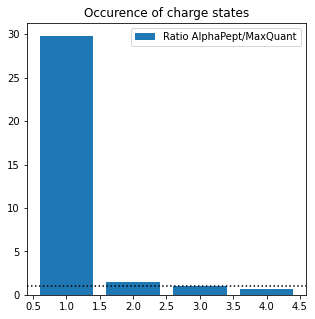

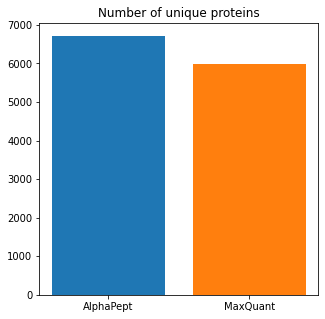

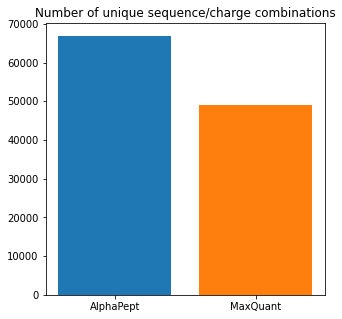

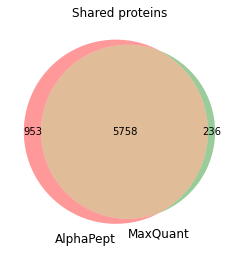

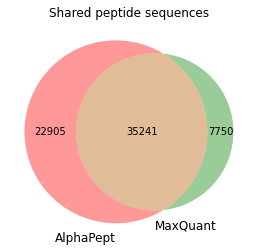

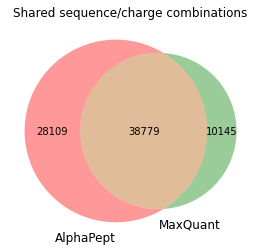

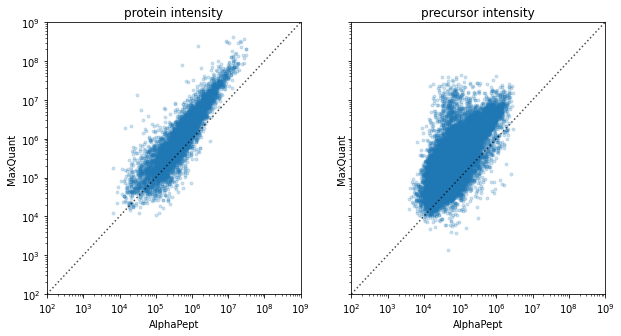

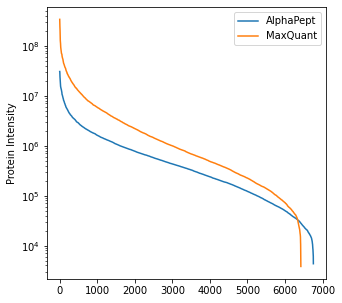

In [ ]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank

df1, df2 = prepare_files(os.path.join(TEST_DIR, "bruker_HeLa.ms_data.hdf"), os.path.join(tmp_folder,'bruker_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

# Quantification Test

This notebook will run `PXD006109` and `PXD010012` and compare the quantificaiton performance.

## PXD006109

In [ ]:
%run -i ../test_ci.py $tmp_folder PXD006109 
#test_ci.main(runtype="PXD006109", new_files=False)

['/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py', '--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"c2d05b11-57da-46c3-8668-d0a7e85a1f98"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/var/folders/m2/9tp69_c95995cmx5r1hl98qr0000gn/T/tmp-9645388iuQ06U1zlc.json'] 11
2021-05-10 16:37:37> Logging to /Users/constantin/alphapept/logs/log_20210510163737.txt.
2021-05-10 16:37:37> Platform information:
2021-05-10 16:37:37> system     - Darwin
2021-05-10 16:37:37> release    - 20.3.0
2021-05-10 16:37:37> version    - 10.16
2021-05-10 16:37:37> machine    - x86_64
2021-05-10 16:37:37> processor  - i386
2021-05-10 16:37:37> cpu count  - 8
2021-05-10 16:37:37> ram memory - 16.0/32.0 Gb (available/total)
2021-05-10 16:37:37> 
2021-05-10 16:37:37> Python information:
2021-05-10 16:37:37> SQLAlchemy     - 1.3.22
2021-05-10 16:37:37> alphapept      - 0.3.21
2021-05-10 16:37:37> biopython      - 

  0%|          | 0/1 [00:00<?, ?it/s]

2021-05-10 16:37:39> FASTA contains 43,752 entries.


100%|██████████| 1.0/1 [04:13<00:00, 86.11s/it]               

2021-05-10 16:42:11> Digested 43,752 proteins and generated 6,062,444 spectra
2021-05-10 16:43:15> Database saved to /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/temp/test_temp/database.hdf. Filesize of database is 2.33 GB


2021-05-10 16:43:33> Processing 6 files for step raw_conversion
AlphaPool was set to 8 processes. Setting max to 8.


100%|██████████| 1.0/1 [04:43<00:00, 283.93s/it]               


2021-05-10 16:48:21> Processing 6 files for step find_features
2021-05-10 16:48:21> Setting Process limit to 2
AlphaPool was set to 2 processes. Setting max to 2.


2021-05-10 17:02:57> Starting first search.
2021-05-10 17:02:57> Processing 6 files for step search_db
2021-05-10 17:02:57> Searching. Setting Process limit to 3.
AlphaPool was set to 3 processes. Setting max to 3.




100%|██████████| 1.0/1 [16:33<00:00, 993.06s/it]
100%|██████████| 1.0/1 [27:17<00:00, 1637.40s/it]


2021-05-10 17:05:14> First search complete.


  0%|          | 0/1 [00:00<?, ?it/s]

2021-05-10 17:05:15> Processing 6 files for step calibrate_hdf
AlphaPool was set to 8 processes. Setting max to 8.


 17%|█▋        | 0.16666666666666666/1 [00:14<01:12, 86.41s/it]

2021-05-10 17:05:29> Starting second search with DB.
2021-05-10 17:05:29> Processing 6 files for step search_db
2021-05-10 17:05:29> Searching. Setting Process limit to 2.
AlphaPool was set to 2 processes. Setting max to 2.


100%|██████████| 1.0/1 [01:23<00:00, 83.96s/it]                
100%|██████████| 1.0/1 [03:42<00:00, 222.95s/it]               


2021-05-10 17:06:59> Second search complete.


  0%|          | 0/1 [00:00<?, ?it/s]

2021-05-10 17:07:00> Processing 6 files for step score_hdf
AlphaPool was set to 8 processes. Setting max to 8.


 67%|██████▋   | 0.6666666666666666/1 [02:20<00:54, 164.81s/it] 

2021-05-10 17:09:21> Fasta dict with length 43,752, Pept dict with length 6,062,444
2021-05-10 17:09:21> Extracting protein groups.



100%|██████████| 1.0/1 [02:25<00:00, 145.67s/it]               



100%|██████████| 1.0/1 [11:50<00:00, 710.46s/it]





2021-05-10 17:21:24> Protein groups complete.
2021-05-10 17:21:25> NumExpr defaulting to 8 threads.
2021-05-10 17:21:34> Total deviation before calibration {'mz': 0.008127196662821343, 'rt': 7.775504908322703}
2021-05-10 17:21:34> Mean deviation before calibration {'mz': 0.0005418131108547562, 'rt': 0.5183669938881802}
2021-05-10 17:21:34> Solving equation system
2021-05-10 17:21:34> Regression score is 0.870784531191745
2021-05-10 17:21:34> Solving equation system complete.
2021-05-10 17:21:34> Applying offset
2021-05-10 17:21:34> Saving /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/./temp/./test_temp/PXD006109_HeLa12_1.ms_data.hdf - protein_fdr.
2021-05-10 17:21:34> Saving /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/./temp/./test_temp/PXD006109_HeLa12_1.ms_data.hdf - feature_table.
2021-05-10 17:21:34> Saving /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/./temp/./test_temp/PXD006109_HeLa12_2.ms_data.hdf - protein_fdr.
2021

  0%|          | 0/1 [00:00<?, ?it/s]

2021-05-10 17:21:49> Preparing protein table for parallel processing.


 20%|█▉        | 0.1963300258257442/1 [00:02<00:08, 11.05s/it] 

2021-05-10 17:21:51> Starting protein extraction for 7357 proteins.
AlphaPool was set to 8 processes. Setting max to 8.


100%|█████████▉| 0.9996737800733995/1 [02:37<00:00, 172.69s/it]

2021-05-10 17:24:32> LFQ complete.
2021-05-10 17:24:32> Exporting as csv.
2021-05-10 17:24:41> Saved df of length 187,329 saved to /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/temp/test_temp/results
2021-05-10 17:24:46> Settings saved to /Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/temp/test_temp/results.yaml
2021-05-10 17:24:46> Analysis complete.


FileNotFoundError: [Errno 2] No such file or directory: 'git branch --show-current'

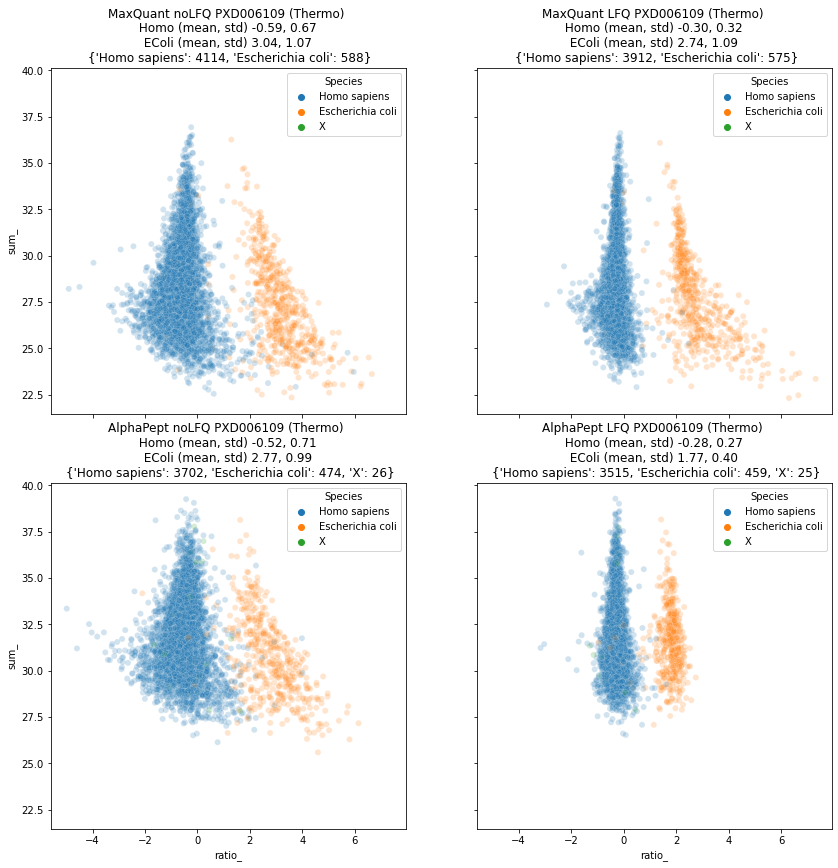

In [ ]:
import test_helper
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
test_helper.add_species_column(ref)
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = os.path.join(TEST_DIR, 'results.hdf') #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')


species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

## CV plot

<ipython-input-6-e7cc4d122219>:22: RuntimeWarning: invalid value encountered in true_divide
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-6-e7cc4d122219>:51: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)


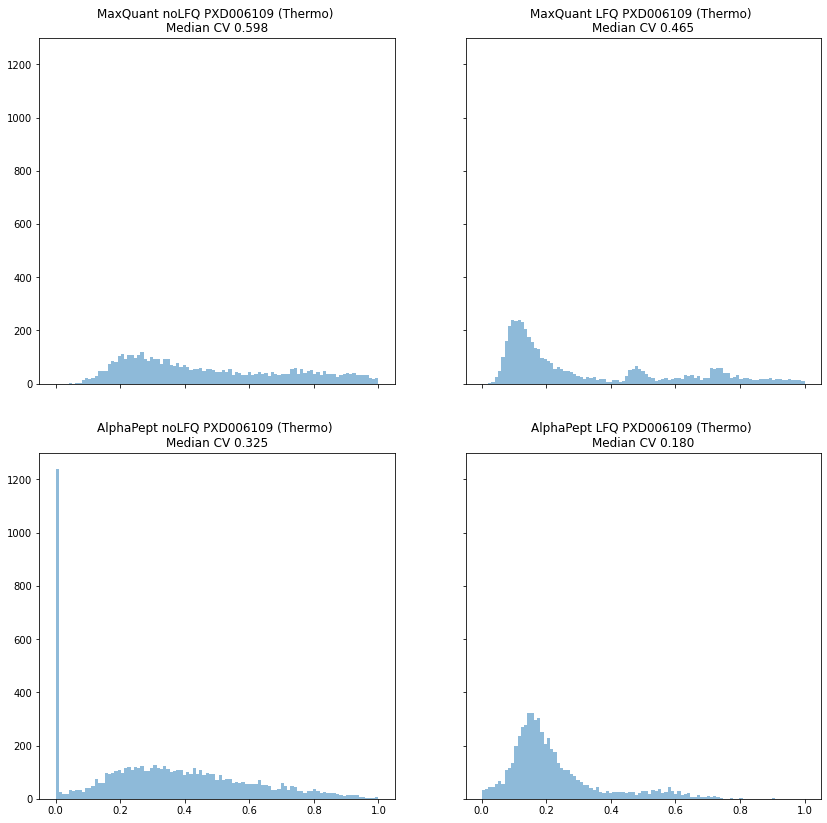

In [ ]:
bins = np.linspace(0,1,100)

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
test_helper.add_species_column(ref)
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[0,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[0,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

path = os.path.join(TEST_DIR,'results.hdf') #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[1,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[1,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

plt.show()

## Algorithm Test

Test performance of LFQ algorithm on MaxQuant evidence file.

In [ ]:
try: 
    import ipywidgets
except ModuleNotFoundError:
    !pip install ipywidgets

In [1]:
from alphapept.quantification import protein_profile_parallel_mq
import test_helper
import pandas as pd


evidence_path = os.path.join(tmp_folder,'PXD006109_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD006109_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
test_helper.add_species_column(ref)
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD006109'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'HeLa2' in _]
    ratio_columns = [_ for _ in ds if 'HeLa12' in _]
    test_helper.get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

NameError: name 'tmp_folder' is not defined

## Normalization Checks

### Check only the delayed normalization part

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/p

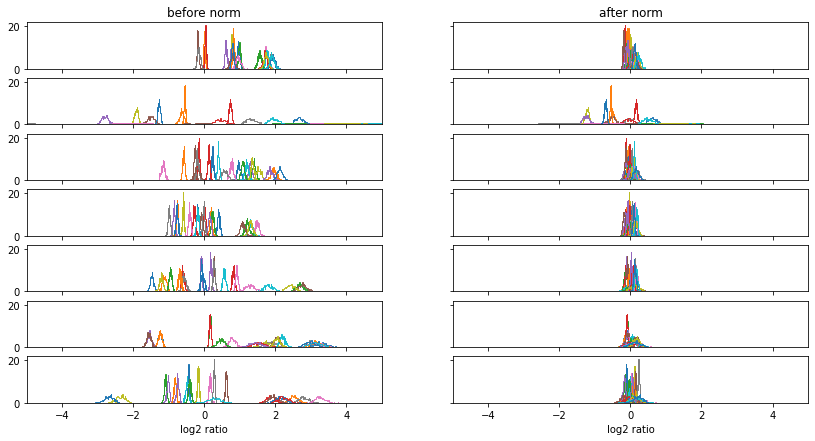

In [3]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import test_helper
from alphapept.quantification import delayed_normalization


def visualize_normalization(simulated_df, axis, value = "Intensity",show_per_colpair = True):
    
    shortnames = df["shortname"].unique()
    df["namefrac"] = [f"{n}_{f}" for n,f in zip(simulated_df["shortname"], simulated_df["fraction"])]
    simulated_reformat = pd.pivot_table(simulated_df, values=value, columns="namefrac" ,index=["protein", "precursor" ])
    
    for namepair in itertools.combinations(shortnames, 2):
        cols1 = [x for x in simulated_reformat.columns if namepair[0] in x]
        cols2 = [x for x in simulated_reformat.columns if namepair[1] in x]
        for colpair in itertools.product(cols1, cols2):
            fcs = np.log2(simulated_reformat[colpair[0]]) - np.log2(simulated_reformat[colpair[1]])
            axis.hist(fcs, histtype = 'step', bins = 50, label = f"{colpair}", density = True)
            axis.set_xlim(-5, 5)
            #plt.box(fcs)
        #plt.legend()
        #if show_per_colpair:
         #   plt.show()
    #plt.show()



samplenames = ["A1", "A2","B1"]
fractions = [3, 2, 3]

ntests = 7
fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize=(14,7), sharex=True,sharey=True)
count_axis = 0
axes[0][0].set_title("before norm")
axes[-1][0].set_xlabel('log2 ratio')
axes[0][1].set_title("after norm")
axes[-1][1].set_xlabel('log2 ratio')
for _ in range(ntests):
    df = test_helper.simulate_biased_peptides(5000, samplenames, fractions)
    df_del, normed = delayed_normalization(df, field ='Intensity')
    visualize_normalization(df, axes[count_axis][0],value = "Intensity", show_per_colpair = False)
    visualize_normalization(df_del, axes[count_axis][1],value = "Intensity_dn", show_per_colpair = False)
    count_axis+=1

### Check delayed normalization + protein intensity estimation

AlphaPool was set to 8 processes. Setting max to 8.


/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: De

AlphaPool was set to 8 processes. Setting max to 8.


/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/constantin/workspace/alphapept_untouched/alphapept/sandbox/test_helper.py:223: RuntimeWarning: Mean of empty slice
  e_coli_ratio = np.nanmean(e_coli[~np.isinf(e_coli)])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: De

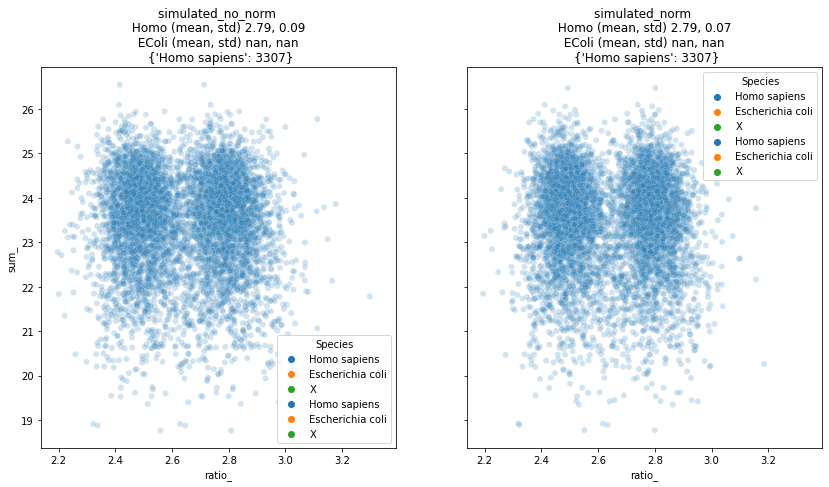

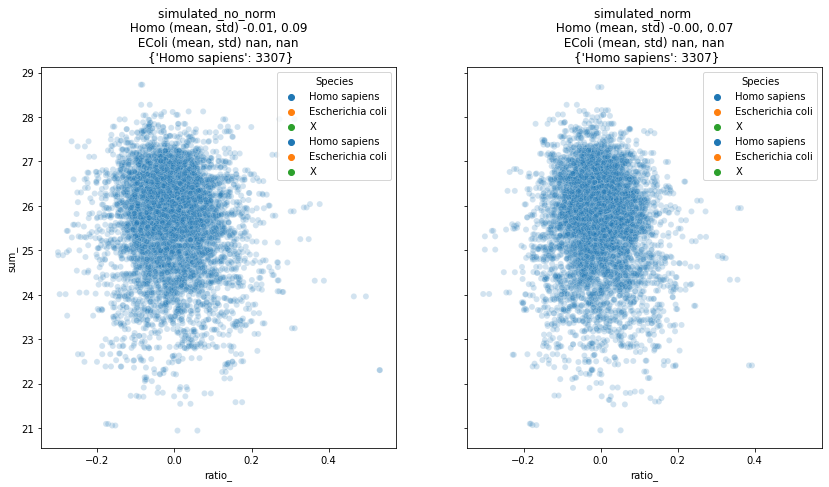

In [1]:
from alphapept.quantification import delayed_normalization, protein_profile_parallel
import test_helper
import pandas as pd
import matplotlib.pyplot as plt
import itertools

samplenames = ["A1", "A2", "B1"]
fractions = [1, 1, 1]
df = test_helper.simulate_biased_peptides(20000, samplenames, fractions)

df, normed = delayed_normalization(df, field ='Intensity')

for field in  ['Intensity', 'Intensity_dn']:
    #df = df[['protein', 'shortname', 'precursor', 'fraction', 'Intensity_dn']]
    pt = protein_profile_parallel(df, minimum_ratios=1, field=field)
    

    pt['Species'] = ["Homo sapiens" for x in range(len(pt.index))]
    pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
    lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

    test_id = 'PXD006109'

    fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

    ids = ["simulated_no_norm", "simulated_norm"]
    pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
    lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]



    for i, cols in enumerate([pre_lfq, lfq]):
        samplepairs = itertools.product([x for x in cols if "A" in x ], [x for x in cols if "B" in x ])

        for pair in samplepairs:
            base_columns = [pair[0]]
            ratio_columns = [pair[1]]
            test_helper.get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i], valid_filter = False)
        

## PXD010012

In [ ]:
%run -i ../test_ci.py $tmp_folder PXD010012

KeyboardInterrupt: 

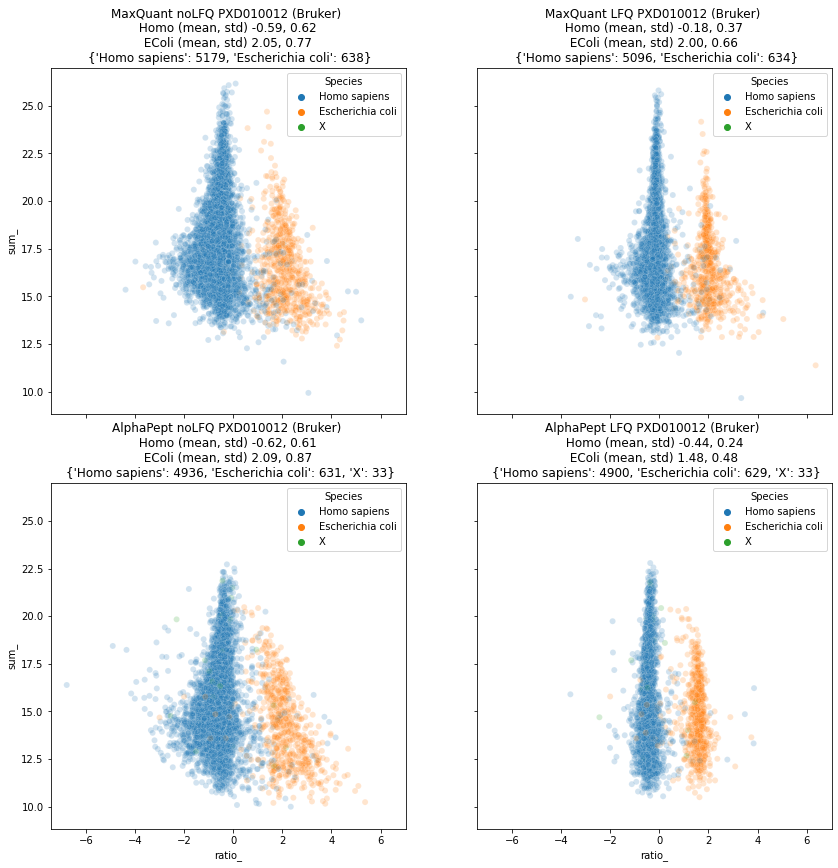

In [ ]:
from test_helper import get_plot_df
import matplotlib.pyplot as plt
import seaborn as sns
import os

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD010012_ref.txt'), sep='\t') 

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Base_{i}" for i in range(1,6)]
    ratio_columns = [f"{x}ntensity Ratio_{i}" for i in range(1,6)]

    id_ = 'MaxQuant ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = os.path.join(TEST_DIR, "results.hdf") #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD010012_CT_{i}_C1_01_Base{x}" for i in range(1,4)]
    ratio_columns = [f"PXD010012_CT_{i}_C2_01_Ratio{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

2021-05-09 09:29:33> Loading files


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2021-05-09 09:29:36> A total of 10 files.
2021-05-09 09:29:47> A total of 7,413 proteins.


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [18:35<00:00, 1115.49s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:26<00:00, 266.00s/it]


2021-05-09 09:30:00> Preparing protein table for parallel processing.
2021-05-09 09:30:10> Starting protein extraction for 7413 proteins.
AlphaPool was set to 24 processes. Setting max to 24.


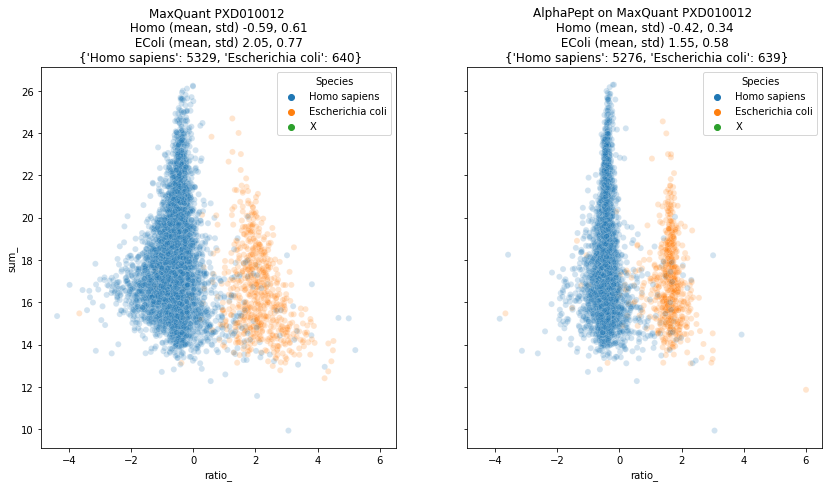

In [ ]:
from alphapept.quantification import protein_profile_parallel_mq
from test_helper import get_plot_df


evidence_path = os.path.join(tmp_folder,'PXD010012_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD010012_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD010012'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'Base' in _]
    ratio_columns = [_ for _ in ds if 'Ratio' in _]
    get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

### Large Fasta

In [ ]:
%run -i ../test_ci.py $tmp_folder thermo_hela_large_fasta

['../test_ci.py', 'thermo_hela_large_fasta'] 2
2021-05-09 09:32:30> Creating dir E:/test_temp/.
2021-05-09 09:32:59> Logging to C:\Users\admin\alphapept\logs\log_20210509093259.txt.
2021-05-09 09:32:59> Platform information:
2021-05-09 09:32:59> system     - Windows
2021-05-09 09:32:59> release    - 10
2021-05-09 09:32:59> version    - 10.0.18362
2021-05-09 09:32:59> machine    - AMD64
2021-05-09 09:32:59> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-09 09:32:59> cpu count  - 24
2021-05-09 09:32:59> ram memory - 112.2/127.7 Gb (available/total)
2021-05-09 09:32:59> 
2021-05-09 09:32:59> Python information:
2021-05-09 09:32:59> SQLAlchemy     - 1.3.22
2021-05-09 09:32:59> alphapept      - 0.3.20-dev0
2021-05-09 09:32:59> biopython      - 1.78
2021-05-09 09:32:59> click          - 7.1.2
2021-05-09 09:32:59> comtypes       - 1.1.7
2021-05-09 09:32:59> fastcore       - 1.3.5
2021-05-09 09:32:59> h5py           - 3.1.0
2021-05-09 09:32:59> lxml           - 4.6.2
2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 09:33:00> Processing 1 files for step raw_conversion
2021-05-09 09:33:00> File E:/test_temp/thermo_HeLa has extension .raw - converting from Thermo.
2021-05-09 09:35:12> File conversion complete. Extracted 120,226 precursors.
2021-05-09 09:35:18> File conversion of file E:/test_temp/thermo_HeLa.raw complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 09:35:18> Processing 1 files for step find_features
2021-05-09 09:35:18> No *.hdf file with features found for E:/test_temp/thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-09 09:35:19> Feature finding on E:/test_temp/thermo_HeLa.raw
2021-05-09 09:35:25> Number of hills 1,105,353, len = 17.35
2021-05-09 09:35:25> Repeating hill extraction with ppm_tol 5.87
2021-05-09 09:35:31> Number of hills 1,227,331, len = 19.44
2021-05-09 09:35:54> After split hill_ptrs 1,635,903
2021-05-09 09:35:55> After filter hill_ptrs 1,585,989


  0%|                                                                                            | 0/1 [02:55<?, ?it/s]


2021-05-09 09:39:01> Extracting hill stats complete
2021-05-09 09:39:23> Found 190,099 pre isotope patterns.
2021-05-09 09:42:29> Extracted 232,428 isotope patterns.
2021-05-09 09:42:31> Report complete.
2021-05-09 09:42:31> Matching features to query data.
2021-05-09 09:42:33> Saving feature table.
2021-05-09 09:42:33> Feature table saved to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-09 09:42:33> Saving features.
2021-05-09 09:42:33> Feature finding of file E:/test_temp/thermo_HeLa.raw complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 09:42:34> Starting first search.
2021-05-09 09:42:45> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': [], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-09 09:44:01> Block 1 of 565 complete - 0.18 % - created peptides 127,046 



  0%|                                                          | 0.0017699115044247787/1 [01:26<13:36:44, 49091.83s/it]

2021-05-09 09:44:01> Block 2 of 565 complete - 0.35 % - created peptides 137,528 



  0%|▏                                                          | 0.0035398230088495575/1 [01:27<5:36:54, 20286.21s/it]

2021-05-09 09:44:01> Block 3 of 565 complete - 0.53 % - created peptides 132,104 



  1%|▎                                                           | 0.005309734513274336/1 [01:27<3:03:55, 11093.95s/it]

2021-05-09 09:44:02> Block 4 of 565 complete - 0.71 % - created peptides 137,180 



  1%|▍                                                            | 0.007079646017699115/1 [01:28<1:54:32, 6921.82s/it]

2021-05-09 09:44:02> Block 5 of 565 complete - 0.88 % - created peptides 146,450 



  1%|▌                                                            | 0.008849557522123894/1 [01:28<1:14:17, 4496.94s/it]

2021-05-09 09:44:02> Block 6 of 565 complete - 1.06 % - created peptides 131,288 



  1%|▋                                                              | 0.010619469026548672/1 [01:29<50:03, 3036.08s/it]

2021-05-09 09:44:03> Block 7 of 565 complete - 1.24 % - created peptides 139,272 



  1%|▊                                                              | 0.012389380530973451/1 [01:29<34:44, 2110.78s/it]

2021-05-09 09:44:03> Block 8 of 565 complete - 1.42 % - created peptides 148,062 



  1%|▉                                                               | 0.01415929203539823/1 [01:29<25:06, 1527.79s/it]

2021-05-09 09:44:04> Block 9 of 565 complete - 1.59 % - created peptides 144,962 



  2%|█                                                               | 0.01592920353982301/1 [01:30<18:32, 1130.93s/it]

2021-05-09 09:44:05> Block 10 of 565 complete - 1.77 % - created peptides 128,102 


  0%|                                                                                            | 0/1 [08:48<?, ?it/s]

2021-05-09 09:44:07> Block 11 of 565 complete - 1.95 % - created peptides 154,422 



  2%|█▏                                                             | 0.019469026548672566/1 [01:33<17:47, 1088.22s/it]

2021-05-09 09:44:08> Block 12 of 565 complete - 2.12 % - created peptides 152,542 



  2%|█▎                                                             | 0.021238938053097345/1 [01:35<16:35, 1017.52s/it]

2021-05-09 09:44:09> Block 13 of 565 complete - 2.30 % - created peptides 162,268 



  2%|█▍                                                              | 0.023008849557522124/1 [01:36<13:31, 830.62s/it]

2021-05-09 09:44:10> Block 14 of 565 complete - 2.48 % - created peptides 166,952 



  2%|█▌                                                              | 0.024778761061946902/1 [01:37<12:55, 795.56s/it]

2021-05-09 09:44:11> Block 15 of 565 complete - 2.65 % - created peptides 169,706 



  3%|█▋                                                               | 0.02654867256637168/1 [01:38<11:22, 701.34s/it]

2021-05-09 09:44:12> Block 16 of 565 complete - 2.83 % - created peptides 165,090 



  3%|█▊                                                               | 0.02831858407079646/1 [01:39<11:35, 715.36s/it]

2021-05-09 09:44:13> Block 17 of 565 complete - 3.01 % - created peptides 169,476 



  3%|█▉                                                               | 0.03008849557522124/1 [01:40<11:48, 730.69s/it]

2021-05-09 09:44:15> Block 18 of 565 complete - 3.19 % - created peptides 170,424 



  3%|██                                                               | 0.03185840707964602/1 [01:41<10:47, 669.11s/it]

2021-05-09 09:44:16> Block 19 of 565 complete - 3.36 % - created peptides 170,850 



  3%|██▏                                                             | 0.033628318584070796/1 [01:43<11:29, 713.89s/it]

2021-05-09 09:44:17> Block 20 of 565 complete - 3.54 % - created peptides 175,666 



  4%|██▎                                                             | 0.035398230088495575/1 [01:44<11:14, 699.02s/it]

2021-05-09 09:44:18> Block 21 of 565 complete - 3.72 % - created peptides 175,436 



  4%|██▍                                                              | 0.03716814159292035/1 [01:46<12:08, 756.68s/it]

2021-05-09 09:44:20> Block 22 of 565 complete - 3.89 % - created peptides 176,298 



  4%|██▌                                                              | 0.03893805309734513/1 [01:47<12:21, 771.75s/it]

2021-05-09 09:44:21> Block 23 of 565 complete - 4.07 % - created peptides 187,342 



  4%|██▋                                                              | 0.04070796460176991/1 [01:49<13:16, 830.33s/it]

2021-05-09 09:44:23> Block 24 of 565 complete - 4.25 % - created peptides 199,478 



  4%|██▊                                                              | 0.04247787610619469/1 [01:51<14:22, 900.54s/it]

2021-05-09 09:44:26> Block 25 of 565 complete - 4.42 % - created peptides 128,288 



  4%|██▊                                                             | 0.04424778761061947/1 [01:54<19:15, 1208.60s/it]

2021-05-09 09:44:28> Block 26 of 565 complete - 4.60 % - created peptides 128,286 



  5%|██▉                                                             | 0.04601769911504425/1 [01:55<16:52, 1061.55s/it]

2021-05-09 09:44:30> Block 27 of 565 complete - 4.78 % - created peptides 141,820 



  5%|███                                                            | 0.047787610619469026/1 [01:58<18:36, 1172.02s/it]

2021-05-09 09:44:34> Block 28 of 565 complete - 4.96 % - created peptides 168,322 



  5%|███                                                            | 0.049557522123893805/1 [02:02<23:24, 1478.26s/it]

2021-05-09 09:44:36> Block 29 of 565 complete - 5.13 % - created peptides 129,354 



  5%|███▎                                                            | 0.05132743362831858/1 [02:04<22:51, 1446.09s/it]

2021-05-09 09:44:38> Block 30 of 565 complete - 5.31 % - created peptides 125,756 



  5%|███▍                                                            | 0.05309734513274336/1 [02:06<21:57, 1391.70s/it]

2021-05-09 09:44:41> Block 31 of 565 complete - 5.49 % - created peptides 158,152 



  5%|███▌                                                            | 0.05486725663716814/1 [02:09<22:30, 1429.41s/it]

2021-05-09 09:44:43> Block 32 of 565 complete - 5.66 % - created peptides 157,200 



  6%|███▌                                                            | 0.05663716814159292/1 [02:11<20:17, 1290.24s/it]

2021-05-09 09:44:45> Block 33 of 565 complete - 5.84 % - created peptides 140,770 



  6%|███▊                                                             | 0.0584070796460177/1 [02:13<20:24, 1300.34s/it]

2021-05-09 09:44:47> Block 34 of 565 complete - 6.02 % - created peptides 178,552 



  6%|███▊                                                            | 0.06017699115044248/1 [02:16<21:16, 1357.96s/it]

2021-05-09 09:44:50> Block 35 of 565 complete - 6.19 % - created peptides 143,322 



  6%|███▉                                                           | 0.061946902654867256/1 [02:18<21:09, 1352.82s/it]

2021-05-09 09:44:52> Block 36 of 565 complete - 6.37 % - created peptides 175,718 



  6%|████                                                            | 0.06371681415929203/1 [02:21<21:29, 1376.83s/it]

2021-05-09 09:44:55> Block 37 of 565 complete - 6.55 % - created peptides 165,622 



  7%|████▏                                                           | 0.06548672566371681/1 [02:23<20:51, 1339.30s/it]

2021-05-09 09:44:57> Block 38 of 565 complete - 6.73 % - created peptides 194,712 



  7%|████▎                                                           | 0.06725663716814159/1 [02:25<21:00, 1351.57s/it]

2021-05-09 09:45:00> Block 39 of 565 complete - 6.90 % - created peptides 209,708 



  7%|████▍                                                           | 0.06902654867256637/1 [02:28<20:55, 1349.00s/it]

2021-05-09 09:45:02> Block 40 of 565 complete - 7.08 % - created peptides 165,358 



  7%|████▌                                                           | 0.07079646017699115/1 [02:31<24:02, 1552.78s/it]

2021-05-09 09:45:05> Block 41 of 565 complete - 7.26 % - created peptides 218,752 



  7%|████▋                                                           | 0.07256637168141593/1 [02:34<24:59, 1617.05s/it]

2021-05-09 09:45:09> Block 42 of 565 complete - 7.43 % - created peptides 192,460 



  7%|████▊                                                            | 0.0743362831858407/1 [02:37<23:04, 1495.36s/it]

2021-05-09 09:45:11> Block 43 of 565 complete - 7.61 % - created peptides 200,506 



  8%|████▊                                                           | 0.07610619469026549/1 [02:40<25:53, 1681.85s/it]

2021-05-09 09:45:14> Block 44 of 565 complete - 7.79 % - created peptides 228,666 



  8%|████▉                                                           | 0.07787610619469026/1 [02:44<26:56, 1753.29s/it]

2021-05-09 09:45:18> Block 45 of 565 complete - 7.96 % - created peptides 206,448 



  8%|█████                                                           | 0.07964601769911504/1 [02:47<27:48, 1812.50s/it]

2021-05-09 09:45:21> Block 46 of 565 complete - 8.14 % - created peptides 175,354 



  8%|█████▏                                                          | 0.08141592920353982/1 [02:51<28:40, 1872.70s/it]

2021-05-09 09:45:25> Block 47 of 565 complete - 8.32 % - created peptides 206,142 



  8%|█████▍                                                           | 0.0831858407079646/1 [02:55<30:21, 1986.33s/it]

2021-05-09 09:45:29> Block 48 of 565 complete - 8.50 % - created peptides 201,770 



  8%|█████▍                                                          | 0.08495575221238938/1 [02:57<27:57, 1832.83s/it]

2021-05-09 09:45:32> Block 49 of 565 complete - 8.67 % - created peptides 145,306 



  9%|█████▌                                                          | 0.08672566371681416/1 [03:01<28:09, 1849.98s/it]

2021-05-09 09:45:35> Block 50 of 565 complete - 8.85 % - created peptides 134,764 



  9%|█████▋                                                          | 0.08849557522123894/1 [03:04<27:13, 1791.74s/it]

2021-05-09 09:45:38> Block 51 of 565 complete - 9.03 % - created peptides 155,056 



  9%|█████▊                                                          | 0.09026548672566372/1 [03:07<28:06, 1854.03s/it]

2021-05-09 09:45:41> Block 52 of 565 complete - 9.20 % - created peptides 137,326 



  9%|█████▉                                                           | 0.0920353982300885/1 [03:10<27:43, 1832.66s/it]

2021-05-09 09:45:44> Block 53 of 565 complete - 9.38 % - created peptides 194,544 



  9%|██████                                                          | 0.09380530973451327/1 [03:13<27:43, 1835.58s/it]

2021-05-09 09:45:48> Block 54 of 565 complete - 9.56 % - created peptides 169,056 



 10%|██████                                                          | 0.09557522123893805/1 [03:17<29:25, 1951.60s/it]

2021-05-09 09:45:52> Block 55 of 565 complete - 9.73 % - created peptides 146,186 



 10%|██████▏                                                         | 0.09734513274336283/1 [03:21<28:50, 1917.14s/it]

2021-05-09 09:45:55> Block 56 of 565 complete - 9.91 % - created peptides 165,250 



 10%|██████▎                                                         | 0.09911504424778761/1 [03:25<31:24, 2091.85s/it]

2021-05-09 09:45:59> Block 57 of 565 complete - 10.09 % - created peptides 193,910 



 10%|██████▍                                                         | 0.10088495575221239/1 [03:29<32:33, 2172.73s/it]

2021-05-09 09:46:04> Block 58 of 565 complete - 10.27 % - created peptides 203,844 



 10%|██████▌                                                         | 0.10265486725663717/1 [03:33<33:08, 2216.20s/it]

2021-05-09 09:46:08> Block 59 of 565 complete - 10.44 % - created peptides 186,584 



 10%|██████▋                                                         | 0.10442477876106195/1 [03:37<31:25, 2104.80s/it]

2021-05-09 09:46:11> Block 60 of 565 complete - 10.62 % - created peptides 137,840 



 11%|██████▊                                                         | 0.10619469026548672/1 [03:40<30:55, 2076.42s/it]

2021-05-09 09:46:14> Block 61 of 565 complete - 10.80 % - created peptides 160,196 



 11%|███████                                                          | 0.1079646017699115/1 [03:44<30:23, 2043.91s/it]

2021-05-09 09:46:18> Block 62 of 565 complete - 10.97 % - created peptides 179,292 



 11%|███████                                                         | 0.10973451327433628/1 [03:46<27:46, 1871.50s/it]

2021-05-09 09:46:21> Block 63 of 565 complete - 11.15 % - created peptides 162,158 



 11%|███████▏                                                        | 0.11150442477876106/1 [03:50<27:39, 1867.69s/it]

2021-05-09 09:46:24> Block 64 of 565 complete - 11.33 % - created peptides 164,802 



 11%|███████▏                                                        | 0.11327433628318584/1 [03:53<28:59, 1961.40s/it]

2021-05-09 09:46:28> Block 65 of 565 complete - 11.50 % - created peptides 177,248 



 12%|███████▎                                                        | 0.11504424778761062/1 [03:57<29:31, 2001.62s/it]

2021-05-09 09:46:31> Block 66 of 565 complete - 11.68 % - created peptides 169,422 



 12%|███████▌                                                         | 0.1168141592920354/1 [04:01<29:53, 2030.81s/it]

2021-05-09 09:46:35> Block 67 of 565 complete - 11.86 % - created peptides 220,488 



 12%|███████▌                                                        | 0.11858407079646018/1 [04:05<32:14, 2194.81s/it]

2021-05-09 09:46:40> Block 68 of 565 complete - 12.04 % - created peptides 194,890 



 12%|███████▋                                                        | 0.12035398230088495/1 [04:10<33:15, 2268.21s/it]

2021-05-09 09:46:44> Block 69 of 565 complete - 12.21 % - created peptides 187,296 



 12%|███████▊                                                        | 0.12212389380530973/1 [04:14<34:07, 2332.68s/it]

2021-05-09 09:46:48> Block 70 of 565 complete - 12.39 % - created peptides 142,288 



 12%|███████▉                                                        | 0.12389380530973451/1 [04:17<31:34, 2162.07s/it]

2021-05-09 09:46:52> Block 71 of 565 complete - 12.57 % - created peptides 206,060 



 13%|████████▏                                                        | 0.1256637168141593/1 [04:22<32:42, 2244.77s/it]

2021-05-09 09:46:56> Block 72 of 565 complete - 12.74 % - created peptides 146,908 



 13%|████████▏                                                       | 0.12743362831858407/1 [04:26<32:37, 2243.40s/it]

2021-05-09 09:47:00> Block 73 of 565 complete - 12.92 % - created peptides 228,188 



 13%|████████▎                                                       | 0.12920353982300886/1 [04:30<33:07, 2282.42s/it]

2021-05-09 09:47:04> Block 74 of 565 complete - 13.10 % - created peptides 178,688 



 13%|████████▍                                                       | 0.13097345132743363/1 [04:34<33:02, 2281.37s/it]

2021-05-09 09:47:08> Block 75 of 565 complete - 13.27 % - created peptides 222,770 



 13%|████████▍                                                       | 0.13274336283185842/1 [04:38<33:52, 2343.16s/it]

2021-05-09 09:47:12> Block 76 of 565 complete - 13.45 % - created peptides 145,962 



 13%|████████▌                                                       | 0.13451327433628318/1 [04:41<31:24, 2177.26s/it]

2021-05-09 09:47:16> Block 77 of 565 complete - 13.63 % - created peptides 188,230 



 14%|████████▋                                                       | 0.13628318584070798/1 [04:45<32:01, 2224.23s/it]

2021-05-09 09:47:20> Block 78 of 565 complete - 13.81 % - created peptides 192,956 



 14%|████████▊                                                       | 0.13805309734513274/1 [04:50<33:56, 2362.92s/it]

2021-05-09 09:47:24> Block 79 of 565 complete - 13.98 % - created peptides 145,176 



 14%|████████▉                                                       | 0.13982300884955753/1 [04:55<35:20, 2465.70s/it]

2021-05-09 09:47:29> Block 80 of 565 complete - 14.16 % - created peptides 177,384 



 14%|█████████▏                                                       | 0.1415929203539823/1 [04:58<32:46, 2291.44s/it]

2021-05-09 09:47:33> Block 81 of 565 complete - 14.34 % - created peptides 171,758 



 14%|█████████▎                                                       | 0.1433628318584071/1 [05:03<33:34, 2351.97s/it]

2021-05-09 09:47:37> Block 82 of 565 complete - 14.51 % - created peptides 163,786 



 15%|█████████▎                                                      | 0.14513274336283186/1 [05:07<34:09, 2398.00s/it]

2021-05-09 09:47:41> Block 83 of 565 complete - 14.69 % - created peptides 136,882 



 15%|█████████▍                                                      | 0.14690265486725665/1 [05:12<35:09, 2472.44s/it]

2021-05-09 09:47:46> Block 84 of 565 complete - 14.87 % - created peptides 185,878 



 15%|█████████▋                                                       | 0.1486725663716814/1 [05:16<33:35, 2367.86s/it]

2021-05-09 09:47:50> Block 85 of 565 complete - 15.04 % - created peptides 193,400 



 15%|█████████▊                                                       | 0.1504424778761062/1 [05:20<33:47, 2386.71s/it]

2021-05-09 09:47:54> Block 86 of 565 complete - 15.22 % - created peptides 176,468 



 15%|█████████▋                                                      | 0.15221238938053097/1 [05:25<35:38, 2522.32s/it]

2021-05-09 09:47:59> Block 87 of 565 complete - 15.40 % - created peptides 193,044 



 15%|█████████▊                                                      | 0.15398230088495576/1 [05:31<38:53, 2758.17s/it]

2021-05-09 09:48:05> Block 88 of 565 complete - 15.58 % - created peptides 175,900 



 16%|█████████▉                                                      | 0.15575221238938053/1 [05:34<35:08, 2497.93s/it]

2021-05-09 09:48:08> Block 89 of 565 complete - 15.75 % - created peptides 212,062 



 16%|██████████                                                      | 0.15752212389380532/1 [05:39<35:27, 2525.60s/it]

2021-05-09 09:48:13> Block 90 of 565 complete - 15.93 % - created peptides 156,596 



 16%|██████████▎                                                      | 0.1592920353982301/1 [05:44<36:07, 2578.67s/it]

2021-05-09 09:48:18> Block 91 of 565 complete - 16.11 % - created peptides 194,804 



 16%|██████████▎                                                     | 0.16106194690265488/1 [05:48<36:38, 2620.57s/it]

2021-05-09 09:48:23> Block 92 of 565 complete - 16.28 % - created peptides 171,056 



 16%|██████████▍                                                     | 0.16283185840707964/1 [05:52<34:32, 2475.28s/it]

2021-05-09 09:48:26> Block 93 of 565 complete - 16.46 % - created peptides 186,312 



 16%|██████████▌                                                     | 0.16460176991150444/1 [05:57<36:00, 2586.13s/it]

2021-05-09 09:48:31> Block 94 of 565 complete - 16.64 % - created peptides 144,748 



 17%|██████████▊                                                      | 0.1663716814159292/1 [06:02<36:59, 2662.20s/it]

2021-05-09 09:48:36> Block 95 of 565 complete - 16.81 % - created peptides 224,012 



 17%|███████████                                                       | 0.168141592920354/1 [06:06<34:11, 2466.38s/it]

2021-05-09 09:48:40> Block 96 of 565 complete - 16.99 % - created peptides 184,112 



 17%|██████████▊                                                     | 0.16991150442477876/1 [06:11<36:21, 2627.87s/it]

2021-05-09 09:48:45> Block 97 of 565 complete - 17.17 % - created peptides 146,002 



 17%|██████████▉                                                     | 0.17168141592920355/1 [06:17<38:59, 2824.30s/it]

2021-05-09 09:48:51> Block 98 of 565 complete - 17.35 % - created peptides 155,696 



 17%|███████████                                                     | 0.17345132743362832/1 [06:22<39:31, 2869.63s/it]

2021-05-09 09:48:56> Block 99 of 565 complete - 17.52 % - created peptides 139,790 



 18%|███████████▍                                                     | 0.1752212389380531/1 [06:26<36:48, 2677.14s/it]

2021-05-09 09:49:00> Block 100 of 565 complete - 17.70 % - created peptides 180,038 



 18%|███████████▎                                                    | 0.17699115044247787/1 [06:31<37:39, 2745.49s/it]

2021-05-09 09:49:05> Block 101 of 565 complete - 17.88 % - created peptides 181,724 



 18%|███████████▍                                                    | 0.17876106194690267/1 [06:36<38:17, 2797.73s/it]

2021-05-09 09:49:11> Block 102 of 565 complete - 18.05 % - created peptides 143,236 



 18%|███████████▌                                                    | 0.18053097345132743/1 [06:40<35:14, 2579.86s/it]

2021-05-09 09:49:14> Block 103 of 565 complete - 18.23 % - created peptides 181,992 



 18%|███████████▋                                                    | 0.18230088495575222/1 [06:45<36:16, 2661.68s/it]

2021-05-09 09:49:19> Block 104 of 565 complete - 18.41 % - created peptides 193,230 



 18%|████████████▏                                                     | 0.184070796460177/1 [06:51<38:17, 2815.63s/it]

2021-05-09 09:49:25> Block 105 of 565 complete - 18.58 % - created peptides 167,986 



 19%|███████████▉                                                    | 0.18584070796460178/1 [06:55<36:48, 2712.56s/it]

2021-05-09 09:49:29> Block 106 of 565 complete - 18.76 % - created peptides 151,414 



 19%|████████████                                                    | 0.18761061946902655/1 [07:01<38:15, 2825.83s/it]

2021-05-09 09:49:35> Block 107 of 565 complete - 18.94 % - created peptides 176,894 



 19%|████████████                                                    | 0.18938053097345134/1 [07:05<36:47, 2723.58s/it]

2021-05-09 09:49:39> Block 108 of 565 complete - 19.12 % - created peptides 151,844 



 19%|████████████▍                                                    | 0.1911504424778761/1 [07:10<37:25, 2775.77s/it]

2021-05-09 09:49:44> Block 109 of 565 complete - 19.29 % - created peptides 154,416 



 19%|████████████▌                                                    | 0.1929203539823009/1 [07:15<38:27, 2858.59s/it]

2021-05-09 09:49:50> Block 110 of 565 complete - 19.47 % - created peptides 164,012 



 19%|████████████▍                                                   | 0.19469026548672566/1 [07:20<36:12, 2697.93s/it]

2021-05-09 09:49:54> Block 111 of 565 complete - 19.65 % - created peptides 142,832 



 20%|████████████▌                                                   | 0.19646017699115045/1 [07:24<35:47, 2672.71s/it]

2021-05-09 09:49:58> Block 112 of 565 complete - 19.82 % - created peptides 150,538 



 20%|████████████▋                                                   | 0.19823008849557522/1 [07:29<36:07, 2703.88s/it]

2021-05-09 09:50:03> Block 113 of 565 complete - 20.00 % - created peptides 151,436 



 20%|████████████████                                                                | 0.2/1 [07:33<33:24, 2505.03s/it]

2021-05-09 09:50:07> Block 114 of 565 complete - 20.18 % - created peptides 147,372 



 20%|████████████▉                                                   | 0.20176991150442478/1 [07:38<36:05, 2713.30s/it]

2021-05-09 09:50:13> Block 115 of 565 complete - 20.35 % - created peptides 142,586 



 20%|█████████████                                                   | 0.20353982300884957/1 [07:45<38:55, 2932.49s/it]

2021-05-09 09:50:19> Block 116 of 565 complete - 20.53 % - created peptides 174,552 



 21%|█████████████▏                                                  | 0.20530973451327433/1 [07:48<35:59, 2717.33s/it]

2021-05-09 09:50:23> Block 117 of 565 complete - 20.71 % - created peptides 204,324 



 21%|█████████████▎                                                  | 0.20707964601769913/1 [07:54<37:52, 2866.57s/it]

2021-05-09 09:50:28> Block 118 of 565 complete - 20.88 % - created peptides 154,666 



 21%|█████████████▌                                                   | 0.2088495575221239/1 [07:58<35:29, 2691.18s/it]

2021-05-09 09:50:32> Block 119 of 565 complete - 21.06 % - created peptides 149,226 



 21%|█████████████▍                                                  | 0.21061946902654868/1 [08:04<36:41, 2788.83s/it]

2021-05-09 09:50:38> Block 120 of 565 complete - 21.24 % - created peptides 113,454 



 21%|█████████████▌                                                  | 0.21238938053097345/1 [08:07<34:03, 2593.98s/it]

2021-05-09 09:50:42> Block 121 of 565 complete - 21.42 % - created peptides 188,130 



 21%|█████████████▋                                                  | 0.21415929203539824/1 [08:13<35:50, 2736.18s/it]

2021-05-09 09:50:47> Block 122 of 565 complete - 21.59 % - created peptides 216,326 



 22%|██████████████▎                                                   | 0.215929203539823/1 [08:19<38:17, 2930.00s/it]

2021-05-09 09:50:53> Block 123 of 565 complete - 21.77 % - created peptides 169,568 



 22%|██████████████▏                                                  | 0.2176991150442478/1 [08:23<36:49, 2824.63s/it]

2021-05-09 09:50:58> Block 124 of 565 complete - 21.95 % - created peptides 206,672 



 22%|██████████████                                                  | 0.21946902654867256/1 [08:29<38:05, 2928.18s/it]

2021-05-09 09:51:03> Block 125 of 565 complete - 22.12 % - created peptides 234,426 



 22%|██████████████▏                                                 | 0.22123893805309736/1 [08:33<36:10, 2787.61s/it]

2021-05-09 09:51:07> Block 126 of 565 complete - 22.30 % - created peptides 218,852 



 22%|██████████████▎                                                 | 0.22300884955752212/1 [08:39<38:12, 2950.89s/it]

2021-05-09 09:51:13> Block 127 of 565 complete - 22.48 % - created peptides 184,658 



 22%|██████████████▌                                                  | 0.2247787610619469/1 [08:43<35:32, 2750.92s/it]

2021-05-09 09:51:17> Block 128 of 565 complete - 22.65 % - created peptides 175,844 



 23%|██████████████▍                                                 | 0.22654867256637168/1 [08:49<36:57, 2867.39s/it]

2021-05-09 09:51:23> Block 129 of 565 complete - 22.83 % - created peptides 153,580 



 23%|██████████████▌                                                 | 0.22831858407079647/1 [08:55<39:31, 3073.42s/it]

2021-05-09 09:51:29> Block 130 of 565 complete - 23.01 % - created peptides 184,916 



 23%|██████████████▋                                                 | 0.23008849557522124/1 [08:59<36:45, 2865.21s/it]

2021-05-09 09:51:33> Block 131 of 565 complete - 23.19 % - created peptides 142,226 



 23%|██████████████▊                                                 | 0.23185840707964603/1 [09:05<38:24, 2999.69s/it]

2021-05-09 09:51:39> Block 132 of 565 complete - 23.36 % - created peptides 159,916 



 23%|███████████████▏                                                 | 0.2336283185840708/1 [09:10<36:20, 2845.36s/it]

2021-05-09 09:51:44> Block 133 of 565 complete - 23.54 % - created peptides 178,748 



 24%|███████████████                                                 | 0.23539823008849559/1 [09:15<37:56, 2977.71s/it]

2021-05-09 09:51:50> Block 134 of 565 complete - 23.72 % - created peptides 169,772 



 24%|███████████████▏                                                | 0.23716814159292035/1 [09:19<34:42, 2729.99s/it]

2021-05-09 09:51:53> Block 135 of 565 complete - 23.89 % - created peptides 142,994 



 24%|███████████████▎                                                | 0.23893805309734514/1 [09:25<37:00, 2917.15s/it]

2021-05-09 09:51:59> Block 136 of 565 complete - 24.07 % - created peptides 139,332 



 24%|███████████████▋                                                 | 0.2407079646017699/1 [09:30<35:49, 2830.45s/it]

2021-05-09 09:52:04> Block 137 of 565 complete - 24.25 % - created peptides 184,988 



 24%|███████████████▊                                                 | 0.2424778761061947/1 [09:36<39:15, 3109.74s/it]

2021-05-09 09:52:11> Block 138 of 565 complete - 24.42 % - created peptides 181,504 



 24%|███████████████▋                                                | 0.24424778761061947/1 [09:43<41:24, 3286.98s/it]

2021-05-09 09:52:17> Block 139 of 565 complete - 24.60 % - created peptides 134,272 



 25%|███████████████▋                                                | 0.24601769911504426/1 [09:47<36:32, 2907.62s/it]

2021-05-09 09:52:21> Block 140 of 565 complete - 24.78 % - created peptides 137,610 



 25%|███████████████▊                                                | 0.24778761061946902/1 [09:51<35:18, 2815.99s/it]

2021-05-09 09:52:25> Block 141 of 565 complete - 24.96 % - created peptides 157,676 



 25%|███████████████▉                                                | 0.24955752212389382/1 [09:57<36:38, 2929.90s/it]

2021-05-09 09:52:31> Block 142 of 565 complete - 25.13 % - created peptides 138,982 



 25%|████████████████▎                                                | 0.2513274336283186/1 [10:04<39:50, 3193.34s/it]

2021-05-09 09:52:38> Block 143 of 565 complete - 25.31 % - created peptides 203,232 



 25%|████████████████▏                                               | 0.25309734513274335/1 [10:08<37:13, 2989.73s/it]

2021-05-09 09:52:42> Block 144 of 565 complete - 25.49 % - created peptides 140,928 



 25%|████████████████▎                                               | 0.25486725663716814/1 [10:14<38:56, 3136.17s/it]

2021-05-09 09:52:48> Block 145 of 565 complete - 25.66 % - created peptides 198,660 



 26%|████████████████▍                                               | 0.25663716814159293/1 [10:19<37:18, 3011.12s/it]

2021-05-09 09:52:53> Block 146 of 565 complete - 25.84 % - created peptides 210,870 



 26%|████████████████▊                                                | 0.2584070796460177/1 [10:23<35:10, 2845.62s/it]

2021-05-09 09:52:58> Block 147 of 565 complete - 26.02 % - created peptides 179,476 



 26%|████████████████▋                                               | 0.26017699115044246/1 [10:29<36:45, 2981.45s/it]

2021-05-09 09:53:03> Block 148 of 565 complete - 26.19 % - created peptides 184,404 



 26%|████████████████▊                                               | 0.26194690265486725/1 [10:36<39:10, 3184.30s/it]

2021-05-09 09:53:10> Block 149 of 565 complete - 26.37 % - created peptides 172,354 



 26%|████████████████▉                                               | 0.26371681415929205/1 [10:40<37:15, 3036.64s/it]

2021-05-09 09:53:15> Block 150 of 565 complete - 26.55 % - created peptides 169,640 



 27%|████████████████▉                                               | 0.26548672566371684/1 [10:45<35:52, 2930.80s/it]

2021-05-09 09:53:19> Block 151 of 565 complete - 26.73 % - created peptides 165,976 



 27%|█████████████████▎                                               | 0.2672566371681416/1 [10:52<38:54, 3186.57s/it]

2021-05-09 09:53:26> Block 152 of 565 complete - 26.90 % - created peptides 171,780 



 27%|█████████████████▏                                              | 0.26902654867256637/1 [10:56<36:08, 2966.33s/it]

2021-05-09 09:53:30> Block 153 of 565 complete - 27.08 % - created peptides 141,092 



 27%|█████████████████▎                                              | 0.27079646017699116/1 [11:02<37:23, 3076.57s/it]

2021-05-09 09:53:36> Block 154 of 565 complete - 27.26 % - created peptides 154,082 



 27%|█████████████████▍                                              | 0.27256637168141595/1 [11:06<34:41, 2861.67s/it]

2021-05-09 09:53:40> Block 155 of 565 complete - 27.43 % - created peptides 201,206 



 27%|█████████████████▊                                               | 0.2743362831858407/1 [11:12<36:43, 3036.42s/it]

2021-05-09 09:53:47> Block 156 of 565 complete - 27.61 % - created peptides 162,604 



 28%|█████████████████▉                                               | 0.2761061946902655/1 [11:17<34:58, 2898.38s/it]

2021-05-09 09:53:51> Block 157 of 565 complete - 27.79 % - created peptides 219,626 



 28%|██████████████████                                               | 0.2778761061946903/1 [11:24<38:02, 3161.28s/it]

2021-05-09 09:53:58> Block 158 of 565 complete - 27.96 % - created peptides 155,532 



 28%|█████████████████▉                                              | 0.27964601769911507/1 [11:28<35:06, 2924.16s/it]

2021-05-09 09:54:02> Block 159 of 565 complete - 28.14 % - created peptides 186,888 



 28%|██████████████████▎                                              | 0.2814159292035398/1 [11:34<36:40, 3062.58s/it]

2021-05-09 09:54:08> Block 160 of 565 complete - 28.32 % - created peptides 199,656 



 28%|██████████████████▍                                              | 0.2831858407079646/1 [11:39<35:26, 2967.09s/it]

2021-05-09 09:54:13> Block 161 of 565 complete - 28.50 % - created peptides 168,690 



 28%|██████████████████▌                                              | 0.2849557522123894/1 [11:45<37:19, 3132.28s/it]

2021-05-09 09:54:19> Block 162 of 565 complete - 28.67 % - created peptides 186,172 



 29%|██████████████████▋                                              | 0.2867256637168142/1 [11:50<35:48, 3012.23s/it]

2021-05-09 09:54:24> Block 163 of 565 complete - 28.85 % - created peptides 170,916 



 29%|██████████████████▊                                              | 0.2884955752212389/1 [11:57<40:04, 3378.93s/it]

2021-05-09 09:54:31> Block 164 of 565 complete - 29.03 % - created peptides 155,290 



 29%|██████████████████▊                                              | 0.2902654867256637/1 [12:02<38:12, 3229.87s/it]

2021-05-09 09:54:36> Block 165 of 565 complete - 29.20 % - created peptides 206,858 



 29%|██████████████████▉                                              | 0.2920353982300885/1 [12:07<35:40, 3022.90s/it]

2021-05-09 09:54:41> Block 166 of 565 complete - 29.38 % - created peptides 166,324 



 29%|███████████████████                                              | 0.2938053097345133/1 [12:13<38:20, 3258.24s/it]

2021-05-09 09:54:48> Block 167 of 565 complete - 29.56 % - created peptides 139,328 



 30%|██████████████████▉                                             | 0.29557522123893804/1 [12:18<35:50, 3053.33s/it]

2021-05-09 09:54:52> Block 168 of 565 complete - 29.73 % - created peptides 141,548 



 30%|███████████████████▎                                             | 0.2973451327433628/1 [12:25<38:17, 3269.37s/it]

2021-05-09 09:54:59> Block 169 of 565 complete - 29.91 % - created peptides 147,288 



 30%|███████████████████▍                                             | 0.2991150442477876/1 [12:30<37:12, 3185.54s/it]

2021-05-09 09:55:04> Block 170 of 565 complete - 30.09 % - created peptides 174,814 



 30%|███████████████████▌                                             | 0.3008849557522124/1 [12:37<40:25, 3468.80s/it]

2021-05-09 09:55:12> Block 171 of 565 complete - 30.27 % - created peptides 162,904 



 30%|███████████████████▎                                            | 0.30265486725663715/1 [12:42<37:21, 3214.22s/it]

2021-05-09 09:55:16> Block 172 of 565 complete - 30.44 % - created peptides 150,554 



 30%|███████████████████▍                                            | 0.30442477876106194/1 [12:50<40:57, 3532.91s/it]

2021-05-09 09:55:24> Block 173 of 565 complete - 30.62 % - created peptides 141,600 



 31%|███████████████████▌                                            | 0.30619469026548674/1 [12:54<37:49, 3270.85s/it]

2021-05-09 09:55:28> Block 174 of 565 complete - 30.80 % - created peptides 167,738 



 31%|███████████████████▋                                            | 0.30796460176991153/1 [12:59<34:58, 3032.59s/it]

2021-05-09 09:55:33> Block 175 of 565 complete - 30.97 % - created peptides 141,852 



 31%|███████████████████▊                                            | 0.30973451327433627/1 [13:06<39:13, 3410.20s/it]

2021-05-09 09:55:40> Block 176 of 565 complete - 31.15 % - created peptides 135,334 



 31%|███████████████████▉                                            | 0.31150442477876106/1 [13:11<36:25, 3174.15s/it]

2021-05-09 09:55:45> Block 177 of 565 complete - 31.33 % - created peptides 153,838 



 31%|████████████████████                                            | 0.31327433628318585/1 [13:19<40:27, 3535.25s/it]

2021-05-09 09:55:53> Block 178 of 565 complete - 31.50 % - created peptides 201,412 



 32%|████████████████████▏                                           | 0.31504424778761064/1 [13:23<37:29, 3284.28s/it]

2021-05-09 09:55:58> Block 179 of 565 complete - 31.68 % - created peptides 143,294 



 32%|████████████████████▌                                            | 0.3168141592920354/1 [13:28<35:37, 3128.66s/it]

2021-05-09 09:56:03> Block 180 of 565 complete - 31.86 % - created peptides 183,904 



 32%|████████████████████▋                                            | 0.3185840707964602/1 [13:35<37:56, 3340.57s/it]

2021-05-09 09:56:09> Block 181 of 565 complete - 32.04 % - created peptides 134,508 



 32%|████████████████████▌                                           | 0.32035398230088497/1 [13:40<35:21, 3121.26s/it]

2021-05-09 09:56:14> Block 182 of 565 complete - 32.21 % - created peptides 192,340 



 32%|████████████████████▌                                           | 0.32212389380530976/1 [13:47<38:15, 3386.92s/it]

2021-05-09 09:56:21> Block 183 of 565 complete - 32.39 % - created peptides 135,598 



 32%|█████████████████████                                            | 0.3238938053097345/1 [13:51<35:31, 3152.81s/it]

2021-05-09 09:56:26> Block 184 of 565 complete - 32.57 % - created peptides 168,362 



 33%|█████████████████████▏                                           | 0.3256637168141593/1 [13:56<33:29, 2980.07s/it]

2021-05-09 09:56:30> Block 185 of 565 complete - 32.74 % - created peptides 176,092 



 33%|█████████████████████▎                                           | 0.3274336283185841/1 [14:03<36:46, 3281.06s/it]

2021-05-09 09:56:37> Block 186 of 565 complete - 32.92 % - created peptides 168,138 



 33%|█████████████████████▍                                           | 0.3292035398230089/1 [14:08<35:02, 3134.73s/it]

2021-05-09 09:56:42> Block 187 of 565 complete - 33.10 % - created peptides 132,500 



 33%|█████████████████████▌                                           | 0.3309734513274336/1 [14:16<39:05, 3505.80s/it]

2021-05-09 09:56:50> Block 188 of 565 complete - 33.27 % - created peptides 167,084 



 33%|█████████████████████▋                                           | 0.3327433628318584/1 [14:21<36:49, 3311.66s/it]

2021-05-09 09:56:55> Block 189 of 565 complete - 33.45 % - created peptides 189,578 



 33%|█████████████████████▋                                           | 0.3345132743362832/1 [14:26<34:40, 3125.99s/it]

2021-05-09 09:57:00> Block 190 of 565 complete - 33.63 % - created peptides 149,212 



 34%|██████████████████████▏                                           | 0.336283185840708/1 [14:32<36:47, 3326.18s/it]

2021-05-09 09:57:06> Block 191 of 565 complete - 33.81 % - created peptides 173,698 



 34%|█████████████████████▉                                           | 0.3380530973451327/1 [14:37<33:50, 3067.64s/it]

2021-05-09 09:57:11> Block 192 of 565 complete - 33.98 % - created peptides 127,698 



 34%|██████████████████████                                           | 0.3398230088495575/1 [14:44<37:11, 3380.18s/it]

2021-05-09 09:57:18> Block 193 of 565 complete - 34.16 % - created peptides 174,424 



 34%|██████████████████████▏                                          | 0.3415929203539823/1 [14:48<34:21, 3130.94s/it]

2021-05-09 09:57:23> Block 194 of 565 complete - 34.34 % - created peptides 182,790 



 34%|██████████████████████▎                                          | 0.3433628318584071/1 [14:53<32:36, 2979.95s/it]

2021-05-09 09:57:27> Block 195 of 565 complete - 34.51 % - created peptides 144,944 



 35%|██████████████████████                                          | 0.34513274336283184/1 [14:59<34:19, 3145.59s/it]

2021-05-09 09:57:34> Block 196 of 565 complete - 34.69 % - created peptides 168,218 



 35%|██████████████████████▏                                         | 0.34690265486725663/1 [15:02<29:51, 2743.49s/it]

2021-05-09 09:57:37> Block 197 of 565 complete - 34.87 % - created peptides 154,970 



 35%|██████████████████████▋                                          | 0.3486725663716814/1 [15:05<25:52, 2383.14s/it]

2021-05-09 09:57:39> Block 198 of 565 complete - 35.04 % - created peptides 147,912 



 35%|██████████████████████▊                                          | 0.3504424778761062/1 [15:09<25:21, 2342.41s/it]

2021-05-09 09:57:43> Block 199 of 565 complete - 35.22 % - created peptides 167,140 



 35%|██████████████████████▌                                         | 0.35221238938053095/1 [15:11<21:46, 2016.26s/it]

2021-05-09 09:57:46> Block 200 of 565 complete - 35.40 % - created peptides 158,812 



 35%|██████████████████████▋                                         | 0.35398230088495575/1 [15:14<19:13, 1785.50s/it]

2021-05-09 09:57:48> Block 201 of 565 complete - 35.58 % - created peptides 145,506 



 36%|██████████████████████▊                                         | 0.35575221238938054/1 [15:17<20:25, 1902.19s/it]

2021-05-09 09:57:52> Block 202 of 565 complete - 35.75 % - created peptides 174,604 



 36%|██████████████████████▉                                         | 0.35752212389380533/1 [15:20<18:19, 1710.88s/it]

2021-05-09 09:57:54> Block 203 of 565 complete - 35.93 % - created peptides 175,698 



 36%|██████████████████████▉                                         | 0.35929203539823007/1 [15:22<16:49, 1576.11s/it]

2021-05-09 09:57:56> Block 204 of 565 complete - 36.11 % - created peptides 191,082 



 36%|███████████████████████                                         | 0.36106194690265486/1 [15:26<18:42, 1756.37s/it]

2021-05-09 09:58:00> Block 205 of 565 complete - 36.28 % - created peptides 179,054 



 36%|███████████████████████▏                                        | 0.36283185840707965/1 [15:28<17:06, 1611.27s/it]

2021-05-09 09:58:02> Block 206 of 565 complete - 36.46 % - created peptides 182,294 



 36%|███████████████████████▎                                        | 0.36460176991150445/1 [15:30<15:58, 1509.23s/it]

2021-05-09 09:58:05> Block 207 of 565 complete - 36.64 % - created peptides 156,208 



 37%|███████████████████████▊                                         | 0.3663716814159292/1 [15:34<18:00, 1705.97s/it]

2021-05-09 09:58:08> Block 208 of 565 complete - 36.81 % - created peptides 169,884 



 37%|████████████████████████▎                                         | 0.368141592920354/1 [15:36<16:36, 1577.56s/it]

2021-05-09 09:58:11> Block 209 of 565 complete - 36.99 % - created peptides 168,952 



 37%|███████████████████████▋                                        | 0.36991150442477877/1 [15:40<18:45, 1786.24s/it]

2021-05-09 09:58:15> Block 210 of 565 complete - 37.17 % - created peptides 174,964 



 37%|███████████████████████▊                                        | 0.37168141592920356/1 [15:43<17:15, 1648.47s/it]

2021-05-09 09:58:17> Block 211 of 565 complete - 37.35 % - created peptides 180,966 



 37%|████████████████████████▎                                        | 0.3734513274336283/1 [15:45<16:08, 1545.65s/it]

2021-05-09 09:58:19> Block 212 of 565 complete - 37.52 % - created peptides 193,382 



 38%|████████████████████████▍                                        | 0.3752212389380531/1 [15:49<18:23, 1766.31s/it]

2021-05-09 09:58:23> Block 213 of 565 complete - 37.70 % - created peptides 179,782 



 38%|████████████████████████▌                                        | 0.3769911504424779/1 [15:51<16:52, 1625.54s/it]

2021-05-09 09:58:26> Block 214 of 565 complete - 37.88 % - created peptides 178,484 



 38%|████████████████████████▌                                        | 0.3787610619469027/1 [15:54<15:47, 1525.61s/it]

2021-05-09 09:58:28> Block 215 of 565 complete - 38.05 % - created peptides 192,906 



 38%|████████████████████████▋                                        | 0.3805309734513274/1 [15:58<18:10, 1760.88s/it]

2021-05-09 09:58:32> Block 216 of 565 complete - 38.23 % - created peptides 173,452 



 38%|████████████████████████▊                                        | 0.3823008849557522/1 [16:00<16:47, 1631.72s/it]

2021-05-09 09:58:34> Block 217 of 565 complete - 38.41 % - created peptides 193,654 



 38%|█████████████████████████▎                                        | 0.384070796460177/1 [16:02<15:51, 1545.25s/it]

2021-05-09 09:58:37> Block 218 of 565 complete - 38.58 % - created peptides 180,300 



 39%|█████████████████████████                                        | 0.3858407079646018/1 [16:07<18:05, 1767.35s/it]

2021-05-09 09:58:41> Block 219 of 565 complete - 38.76 % - created peptides 176,500 



 39%|████████████████████████▊                                       | 0.38761061946902653/1 [16:09<16:44, 1640.34s/it]

2021-05-09 09:58:43> Block 220 of 565 complete - 38.94 % - created peptides 177,068 



 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [16:11<15:48, 1553.80s/it]

2021-05-09 09:58:46> Block 221 of 565 complete - 39.12 % - created peptides 176,072 



 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [16:15<17:56, 1767.86s/it]

2021-05-09 09:58:50> Block 222 of 565 complete - 39.29 % - created peptides 184,974 



 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [16:18<16:38, 1645.30s/it]

2021-05-09 09:58:52> Block 223 of 565 complete - 39.47 % - created peptides 158,126 



 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [16:20<15:42, 1557.07s/it]

2021-05-09 09:58:54> Block 224 of 565 complete - 39.65 % - created peptides 182,076 



 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [16:24<17:45, 1764.80s/it]

2021-05-09 09:58:58> Block 225 of 565 complete - 39.82 % - created peptides 158,570 



 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [16:26<16:27, 1640.94s/it]

2021-05-09 09:59:01> Block 226 of 565 complete - 40.00 % - created peptides 175,736 



 40%|████████████████████████████████                                                | 0.4/1 [16:31<18:29, 1848.68s/it]

2021-05-09 09:59:05> Block 227 of 565 complete - 40.18 % - created peptides 183,834 



 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [16:33<16:59, 1703.94s/it]

2021-05-09 09:59:07> Block 228 of 565 complete - 40.35 % - created peptides 157,580 



 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [16:35<15:56, 1603.52s/it]

2021-05-09 09:59:10> Block 229 of 565 complete - 40.53 % - created peptides 180,538 



 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [16:40<17:59, 1814.60s/it]

2021-05-09 09:59:14> Block 230 of 565 complete - 40.71 % - created peptides 196,050 



 41%|██████████████████████████                                      | 0.40707964601769914/1 [16:42<16:37, 1681.74s/it]

2021-05-09 09:59:16> Block 231 of 565 complete - 40.88 % - created peptides 122,564 



 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [16:44<15:36, 1584.95s/it]

2021-05-09 09:59:19> Block 232 of 565 complete - 41.06 % - created peptides 165,030 



 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [16:48<17:36, 1793.27s/it]

2021-05-09 09:59:23> Block 233 of 565 complete - 41.24 % - created peptides 191,452 



 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [16:51<16:21, 1670.86s/it]

2021-05-09 09:59:25> Block 234 of 565 complete - 41.42 % - created peptides 179,984 



 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [16:53<15:26, 1581.59s/it]

2021-05-09 09:59:28> Block 235 of 565 complete - 41.59 % - created peptides 135,818 



 42%|███████████████████████████▍                                      | 0.415929203539823/1 [16:57<17:18, 1777.28s/it]

2021-05-09 09:59:32> Block 236 of 565 complete - 41.77 % - created peptides 177,106 



 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [17:00<16:06, 1659.29s/it]

2021-05-09 09:59:34> Block 237 of 565 complete - 41.95 % - created peptides 135,418 



 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [17:04<17:54, 1851.01s/it]

2021-05-09 09:59:38> Block 238 of 565 complete - 42.12 % - created peptides 148,188 



 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [17:06<16:26, 1705.35s/it]

2021-05-09 09:59:40> Block 239 of 565 complete - 42.30 % - created peptides 183,002 



 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [17:09<15:30, 1612.09s/it]

2021-05-09 09:59:43> Block 240 of 565 complete - 42.48 % - created peptides 202,424 



 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [17:13<17:19, 1806.36s/it]

2021-05-09 09:59:47> Block 241 of 565 complete - 42.65 % - created peptides 150,532 



 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [17:15<16:03, 1679.84s/it]

2021-05-09 09:59:49> Block 242 of 565 complete - 42.83 % - created peptides 179,420 



 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [17:19<17:51, 1874.56s/it]

2021-05-09 09:59:53> Block 243 of 565 complete - 43.01 % - created peptides 175,112 



 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [17:22<16:25, 1729.42s/it]

2021-05-09 09:59:56> Block 244 of 565 complete - 43.19 % - created peptides 156,824 



 43%|████████████████████████████▌                                     | 0.431858407079646/1 [17:24<15:26, 1630.15s/it]

2021-05-09 09:59:58> Block 245 of 565 complete - 43.36 % - created peptides 174,396 



 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [17:28<17:12, 1822.97s/it]

2021-05-09 10:00:02> Block 246 of 565 complete - 43.54 % - created peptides 190,642 



 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [17:31<15:56, 1694.75s/it]

2021-05-09 10:00:05> Block 247 of 565 complete - 43.72 % - created peptides 167,206 



 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [17:33<15:04, 1606.93s/it]

2021-05-09 10:00:07> Block 248 of 565 complete - 43.89 % - created peptides 160,198 



 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [17:37<16:43, 1788.07s/it]

2021-05-09 10:00:11> Block 249 of 565 complete - 44.07 % - created peptides 226,752 



 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [17:40<15:38, 1677.58s/it]

2021-05-09 10:00:14> Block 250 of 565 complete - 44.25 % - created peptides 159,084 



 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [17:44<17:13, 1853.23s/it]

2021-05-09 10:00:18> Block 251 of 565 complete - 44.42 % - created peptides 166,632 



 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [17:46<15:54, 1717.88s/it]

2021-05-09 10:00:20> Block 252 of 565 complete - 44.60 % - created peptides 144,180 



 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [17:50<17:34, 1903.65s/it]

2021-05-09 10:00:24> Block 253 of 565 complete - 44.78 % - created peptides 151,366 



 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [17:53<16:08, 1753.90s/it]

2021-05-09 10:00:27> Block 254 of 565 complete - 44.96 % - created peptides 169,408 



 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [17:55<15:06, 1647.64s/it]

2021-05-09 10:00:29> Block 255 of 565 complete - 45.13 % - created peptides 166,444 



 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [17:59<16:48, 1838.90s/it]

2021-05-09 10:00:33> Block 256 of 565 complete - 45.31 % - created peptides 189,728 



 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [18:02<15:35, 1710.24s/it]

2021-05-09 10:00:36> Block 257 of 565 complete - 45.49 % - created peptides 167,588 



 45%|█████████████████████████████                                   | 0.45486725663716815/1 [18:06<17:15, 1900.00s/it]

2021-05-09 10:00:40> Block 258 of 565 complete - 45.66 % - created peptides 189,964 



 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [18:08<15:54, 1756.45s/it]

2021-05-09 10:00:43> Block 259 of 565 complete - 45.84 % - created peptides 165,502 



 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [18:11<14:55, 1654.19s/it]

2021-05-09 10:00:45> Block 260 of 565 complete - 46.02 % - created peptides 177,366 



 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [18:15<16:34, 1841.78s/it]

2021-05-09 10:00:49> Block 261 of 565 complete - 46.19 % - created peptides 163,376 



 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [18:17<15:22, 1714.53s/it]

2021-05-09 10:00:52> Block 262 of 565 complete - 46.37 % - created peptides 181,382 



 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [18:22<16:58, 1898.48s/it]

2021-05-09 10:00:56> Block 263 of 565 complete - 46.55 % - created peptides 191,944 



 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [18:24<15:40, 1758.85s/it]

2021-05-09 10:00:58> Block 264 of 565 complete - 46.73 % - created peptides 158,298 



 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [18:27<14:44, 1660.57s/it]

2021-05-09 10:01:01> Block 265 of 565 complete - 46.90 % - created peptides 151,640 



 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [18:31<16:15, 1837.70s/it]

2021-05-09 10:01:05> Block 266 of 565 complete - 47.08 % - created peptides 164,174 



 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [18:33<15:13, 1726.04s/it]

2021-05-09 10:01:07> Block 267 of 565 complete - 47.26 % - created peptides 190,752 



 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [18:37<16:42, 1901.10s/it]

2021-05-09 10:01:12> Block 268 of 565 complete - 47.43 % - created peptides 160,772 



 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [18:40<15:25, 1760.13s/it]

2021-05-09 10:01:14> Block 269 of 565 complete - 47.61 % - created peptides 164,384 



 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [18:44<16:57, 1942.21s/it]

2021-05-09 10:01:18> Block 270 of 565 complete - 47.79 % - created peptides 180,480 



 48%|███████████████████████████████                                  | 0.4778761061946903/1 [18:47<15:33, 1788.85s/it]

2021-05-09 10:01:21> Block 271 of 565 complete - 47.96 % - created peptides 167,188 



 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [18:49<14:36, 1685.34s/it]

2021-05-09 10:01:23> Block 272 of 565 complete - 48.14 % - created peptides 184,794 



 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [18:53<16:05, 1861.85s/it]

2021-05-09 10:01:27> Block 273 of 565 complete - 48.32 % - created peptides 179,182 



 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [18:56<14:56, 1735.02s/it]

2021-05-09 10:01:30> Block 274 of 565 complete - 48.50 % - created peptides 167,936 



 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [19:00<16:22, 1908.18s/it]

2021-05-09 10:01:34> Block 275 of 565 complete - 48.67 % - created peptides 169,696 



 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [19:02<15:07, 1768.46s/it]

2021-05-09 10:01:37> Block 276 of 565 complete - 48.85 % - created peptides 182,602 



 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [19:06<16:36, 1947.59s/it]

2021-05-09 10:01:41> Block 277 of 565 complete - 49.03 % - created peptides 166,152 



 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [19:09<15:16, 1798.17s/it]

2021-05-09 10:01:43> Block 278 of 565 complete - 49.20 % - created peptides 181,812 



 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [19:12<14:20, 1694.43s/it]

2021-05-09 10:01:46> Block 279 of 565 complete - 49.38 % - created peptides 183,856 



 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [19:16<15:45, 1868.75s/it]

2021-05-09 10:01:50> Block 280 of 565 complete - 49.56 % - created peptides 176,426 



 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [19:18<14:39, 1743.51s/it]

2021-05-09 10:01:52> Block 281 of 565 complete - 49.73 % - created peptides 185,468 



 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [19:22<16:01, 1912.04s/it]

2021-05-09 10:01:57> Block 282 of 565 complete - 49.91 % - created peptides 172,908 



 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [19:25<14:50, 1777.71s/it]

2021-05-09 10:01:59> Block 283 of 565 complete - 50.09 % - created peptides 169,586 



 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [19:29<16:11, 1946.29s/it]

2021-05-09 10:02:03> Block 284 of 565 complete - 50.27 % - created peptides 165,918 



 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [19:32<14:57, 1803.78s/it]

2021-05-09 10:02:06> Block 285 of 565 complete - 50.44 % - created peptides 168,472 



 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [19:34<14:02, 1700.43s/it]

2021-05-09 10:02:08> Block 286 of 565 complete - 50.62 % - created peptides 185,790 



 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [19:38<15:21, 1865.65s/it]

2021-05-09 10:02:12> Block 287 of 565 complete - 50.80 % - created peptides 189,212 



 51%|█████████████████████████████████                                | 0.5079646017699115/1 [19:41<14:19, 1746.56s/it]

2021-05-09 10:02:15> Block 288 of 565 complete - 50.97 % - created peptides 191,784 



 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [19:45<15:31, 1900.35s/it]

2021-05-09 10:02:19> Block 289 of 565 complete - 51.15 % - created peptides 185,196 



 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [19:47<14:26, 1773.96s/it]

2021-05-09 10:02:22> Block 290 of 565 complete - 51.33 % - created peptides 168,182 



 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [19:51<15:38, 1928.81s/it]

2021-05-09 10:02:26> Block 291 of 565 complete - 51.50 % - created peptides 168,070 



 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [19:54<14:29, 1792.63s/it]

2021-05-09 10:02:28> Block 292 of 565 complete - 51.68 % - created peptides 168,122 



 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [19:58<15:38, 1943.15s/it]

2021-05-09 10:02:32> Block 293 of 565 complete - 51.86 % - created peptides 159,194 



 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [20:01<14:30, 1808.80s/it]

2021-05-09 10:02:35> Block 294 of 565 complete - 52.04 % - created peptides 191,652 



 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [20:05<15:40, 1961.21s/it]

2021-05-09 10:02:39> Block 295 of 565 complete - 52.21 % - created peptides 181,462 



 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [20:08<14:29, 1820.28s/it]

2021-05-09 10:02:42> Block 296 of 565 complete - 52.39 % - created peptides 176,548 



 52%|██████████████████████████████████                               | 0.5238938053097345/1 [20:12<15:40, 1975.54s/it]

2021-05-09 10:02:46> Block 297 of 565 complete - 52.57 % - created peptides 172,108 



 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [20:14<14:28, 1831.75s/it]

2021-05-09 10:02:49> Block 298 of 565 complete - 52.74 % - created peptides 192,734 



 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [20:19<15:42, 1994.89s/it]

2021-05-09 10:02:53> Block 299 of 565 complete - 52.92 % - created peptides 180,480 



 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [20:21<14:28, 1845.20s/it]

2021-05-09 10:02:55> Block 300 of 565 complete - 53.10 % - created peptides 185,678 



 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [20:24<13:36, 1740.69s/it]

2021-05-09 10:02:58> Block 301 of 565 complete - 53.27 % - created peptides 182,438 



 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [20:28<14:45, 1895.91s/it]

2021-05-09 10:03:02> Block 302 of 565 complete - 53.45 % - created peptides 142,920 



 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [20:30<13:46, 1775.20s/it]

2021-05-09 10:03:05> Block 303 of 565 complete - 53.63 % - created peptides 166,884 



 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [20:34<14:49, 1917.88s/it]

2021-05-09 10:03:09> Block 304 of 565 complete - 53.81 % - created peptides 150,246 



 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [20:37<13:48, 1792.86s/it]

2021-05-09 10:03:11> Block 305 of 565 complete - 53.98 % - created peptides 172,714 



 54%|███████████████████████████████████                              | 0.5398230088495575/1 [20:41<14:46, 1925.83s/it]

2021-05-09 10:03:15> Block 306 of 565 complete - 54.16 % - created peptides 173,880 



 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [20:45<15:43, 2058.27s/it]

2021-05-09 10:03:19> Block 307 of 565 complete - 54.34 % - created peptides 183,358 



 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [20:48<14:25, 1895.12s/it]

2021-05-09 10:03:22> Block 308 of 565 complete - 54.51 % - created peptides 181,168 



 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [20:51<13:28, 1778.17s/it]

2021-05-09 10:03:25> Block 309 of 565 complete - 54.69 % - created peptides 172,852 



 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [20:55<14:31, 1922.52s/it]

2021-05-09 10:03:29> Block 310 of 565 complete - 54.87 % - created peptides 176,134 



 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [20:57<13:31, 1798.31s/it]

2021-05-09 10:03:31> Block 311 of 565 complete - 55.04 % - created peptides 195,560 



 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [21:01<14:29, 1933.21s/it]

2021-05-09 10:03:35> Block 312 of 565 complete - 55.22 % - created peptides 157,206 



 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [21:05<15:24, 2064.11s/it]

2021-05-09 10:03:40> Block 313 of 565 complete - 55.40 % - created peptides 194,688 



 55%|████████████████████████████████████                             | 0.5539823008849557/1 [21:08<14:07, 1900.85s/it]

2021-05-09 10:03:42> Block 314 of 565 complete - 55.58 % - created peptides 178,262 



 56%|████████████████████████████████████                             | 0.5557522123893806/1 [21:11<13:12, 1784.48s/it]

2021-05-09 10:03:45> Block 315 of 565 complete - 55.75 % - created peptides 117,910 



 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [21:15<14:09, 1920.30s/it]

2021-05-09 10:03:49> Block 316 of 565 complete - 55.93 % - created peptides 117,542 



 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [21:19<15:04, 2051.71s/it]

2021-05-09 10:03:53> Block 317 of 565 complete - 56.11 % - created peptides 172,416 



 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [21:22<13:56, 1904.70s/it]

2021-05-09 10:03:56> Block 318 of 565 complete - 56.28 % - created peptides 195,188 



 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [21:26<14:58, 2055.17s/it]

2021-05-09 10:04:00> Block 319 of 565 complete - 56.46 % - created peptides 168,214 



 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [21:29<13:45, 1894.96s/it]

2021-05-09 10:04:03> Block 320 of 565 complete - 56.64 % - created peptides 179,504 



 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [21:31<12:55, 1787.92s/it]

2021-05-09 10:04:06> Block 321 of 565 complete - 56.81 % - created peptides 176,096 



 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [21:35<13:50, 1923.29s/it]

2021-05-09 10:04:10> Block 322 of 565 complete - 56.99 % - created peptides 184,028 



 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [21:40<14:45, 2059.98s/it]

2021-05-09 10:04:14> Block 323 of 565 complete - 57.17 % - created peptides 184,024 



 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [21:42<13:33, 1898.42s/it]

2021-05-09 10:04:16> Block 324 of 565 complete - 57.35 % - created peptides 174,352 



 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [21:46<14:29, 2039.26s/it]

2021-05-09 10:04:21> Block 325 of 565 complete - 57.52 % - created peptides 165,158 



 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [21:49<13:24, 1894.42s/it]

2021-05-09 10:04:23> Block 326 of 565 complete - 57.70 % - created peptides 184,296 



 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [21:53<14:23, 2041.77s/it]

2021-05-09 10:04:28> Block 327 of 565 complete - 57.88 % - created peptides 201,460 



 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [21:56<13:10, 1876.83s/it]

2021-05-09 10:04:30> Block 328 of 565 complete - 58.05 % - created peptides 169,718 



 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [22:00<14:09, 2025.95s/it]

2021-05-09 10:04:34> Block 329 of 565 complete - 58.23 % - created peptides 193,524 



 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [22:03<13:00, 1867.67s/it]

2021-05-09 10:04:37> Block 330 of 565 complete - 58.41 % - created peptides 190,082 



 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [22:07<13:55, 2008.66s/it]

2021-05-09 10:04:41> Block 331 of 565 complete - 58.58 % - created peptides 173,048 



 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [22:10<12:48, 1856.00s/it]

2021-05-09 10:04:44> Block 332 of 565 complete - 58.76 % - created peptides 176,092 



 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [22:14<13:44, 1999.17s/it]

2021-05-09 10:04:48> Block 333 of 565 complete - 58.94 % - created peptides 187,124 



 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [22:16<12:40, 1852.41s/it]

2021-05-09 10:04:51> Block 334 of 565 complete - 59.12 % - created peptides 181,610 



 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [22:21<13:35, 1995.16s/it]

2021-05-09 10:04:55> Block 335 of 565 complete - 59.29 % - created peptides 192,494 



 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [22:23<12:34, 1852.34s/it]

2021-05-09 10:04:58> Block 336 of 565 complete - 59.47 % - created peptides 182,826 



 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [22:27<13:27, 1993.32s/it]

2021-05-09 10:05:02> Block 337 of 565 complete - 59.65 % - created peptides 179,736 



 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [22:30<12:25, 1847.24s/it]

2021-05-09 10:05:04> Block 338 of 565 complete - 59.82 % - created peptides 188,382 



 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [22:34<13:18, 1986.92s/it]

2021-05-09 10:05:08> Block 339 of 565 complete - 60.00 % - created peptides 155,074 



 60%|████████████████████████████████████████████████                                | 0.6/1 [22:37<12:17, 1843.91s/it]

2021-05-09 10:05:11> Block 340 of 565 complete - 60.18 % - created peptides 192,370 



 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [22:41<13:10, 1984.21s/it]

2021-05-09 10:05:15> Block 341 of 565 complete - 60.35 % - created peptides 182,952 



 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [22:44<12:11, 1845.20s/it]

2021-05-09 10:05:18> Block 342 of 565 complete - 60.53 % - created peptides 171,772 



 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [22:48<13:00, 1976.65s/it]

2021-05-09 10:05:22> Block 343 of 565 complete - 60.71 % - created peptides 176,228 



 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [22:50<12:02, 1838.08s/it]

2021-05-09 10:05:25> Block 344 of 565 complete - 60.88 % - created peptides 171,126 



 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [22:54<12:48, 1964.10s/it]

2021-05-09 10:05:29> Block 345 of 565 complete - 61.06 % - created peptides 161,876 



 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [22:57<11:52, 1829.81s/it]

2021-05-09 10:05:31> Block 346 of 565 complete - 61.24 % - created peptides 191,910 



 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [23:01<12:36, 1952.21s/it]

2021-05-09 10:05:35> Block 347 of 565 complete - 61.42 % - created peptides 161,394 



 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [23:04<11:44, 1824.69s/it]

2021-05-09 10:05:38> Block 348 of 565 complete - 61.59 % - created peptides 173,198 



 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [23:08<12:22, 1932.15s/it]

2021-05-09 10:05:42> Block 349 of 565 complete - 61.77 % - created peptides 179,718 



 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [23:12<12:59, 2038.00s/it]

2021-05-09 10:05:46> Block 350 of 565 complete - 61.95 % - created peptides 169,970 



 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [23:14<11:59, 1890.02s/it]

2021-05-09 10:05:49> Block 351 of 565 complete - 62.12 % - created peptides 186,248 



 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [23:18<12:38, 2001.55s/it]

2021-05-09 10:05:53> Block 352 of 565 complete - 62.30 % - created peptides 195,710 



 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [23:21<11:41, 1860.51s/it]

2021-05-09 10:05:55> Block 353 of 565 complete - 62.48 % - created peptides 180,542 



 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [23:25<12:18, 1969.36s/it]

2021-05-09 10:05:59> Block 354 of 565 complete - 62.65 % - created peptides 182,682 



 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [23:29<12:54, 2074.98s/it]

2021-05-09 10:06:03> Block 355 of 565 complete - 62.83 % - created peptides 165,020 



 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [23:32<11:50, 1911.05s/it]

2021-05-09 10:06:06> Block 356 of 565 complete - 63.01 % - created peptides 178,182 



 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [23:36<12:28, 2024.65s/it]

2021-05-09 10:06:10> Block 357 of 565 complete - 63.19 % - created peptides 167,994 



 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [23:39<11:31, 1878.84s/it]

2021-05-09 10:06:13> Block 358 of 565 complete - 63.36 % - created peptides 163,802 



 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [23:43<12:09, 1990.31s/it]

2021-05-09 10:06:17> Block 359 of 565 complete - 63.54 % - created peptides 160,448 



 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [23:45<11:15, 1852.71s/it]

2021-05-09 10:06:20> Block 360 of 565 complete - 63.72 % - created peptides 180,452 



 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [23:49<11:50, 1956.92s/it]

2021-05-09 10:06:23> Block 361 of 565 complete - 63.89 % - created peptides 190,954 



 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [23:53<12:24, 2061.09s/it]

2021-05-09 10:06:27> Block 362 of 565 complete - 64.07 % - created peptides 182,160 



 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [23:56<11:24, 1904.61s/it]

2021-05-09 10:06:30> Block 363 of 565 complete - 64.25 % - created peptides 176,858 



 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [24:00<11:58, 2008.73s/it]

2021-05-09 10:06:34> Block 364 of 565 complete - 64.42 % - created peptides 194,012 



 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [24:03<11:05, 1871.37s/it]

2021-05-09 10:06:37> Block 365 of 565 complete - 64.60 % - created peptides 170,728 



 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [24:07<11:37, 1970.01s/it]

2021-05-09 10:06:41> Block 366 of 565 complete - 64.78 % - created peptides 191,954 



 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [24:11<12:09, 2071.01s/it]

2021-05-09 10:06:45> Block 367 of 565 complete - 64.96 % - created peptides 177,302 



 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [24:13<11:14, 1925.74s/it]

2021-05-09 10:06:48> Block 368 of 565 complete - 65.13 % - created peptides 182,690 



 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [24:17<11:45, 2024.28s/it]

2021-05-09 10:06:52> Block 369 of 565 complete - 65.31 % - created peptides 178,934 



 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [24:20<10:52, 1881.14s/it]

2021-05-09 10:06:54> Block 370 of 565 complete - 65.49 % - created peptides 171,122 



 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [24:24<11:19, 1969.62s/it]

2021-05-09 10:06:58> Block 371 of 565 complete - 65.66 % - created peptides 179,532 



 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [24:28<11:46, 2056.83s/it]

2021-05-09 10:07:02> Block 372 of 565 complete - 65.84 % - created peptides 194,964 



 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [24:31<10:51, 1906.77s/it]

2021-05-09 10:07:05> Block 373 of 565 complete - 66.02 % - created peptides 177,446 



 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [24:35<11:18, 1996.96s/it]

2021-05-09 10:07:09> Block 374 of 565 complete - 66.19 % - created peptides 194,664 



 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [24:39<11:43, 2080.82s/it]

2021-05-09 10:07:13> Block 375 of 565 complete - 66.37 % - created peptides 173,778 



 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [24:42<10:47, 1924.04s/it]

2021-05-09 10:07:16> Block 376 of 565 complete - 66.55 % - created peptides 188,190 



 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [24:45<11:13, 2011.95s/it]

2021-05-09 10:07:20> Block 377 of 565 complete - 66.73 % - created peptides 175,264 



 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [24:49<11:38, 2098.07s/it]

2021-05-09 10:07:24> Block 378 of 565 complete - 66.90 % - created peptides 195,460 



 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [24:52<10:42, 1940.20s/it]

2021-05-09 10:07:27> Block 379 of 565 complete - 67.08 % - created peptides 181,442 



 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [24:56<11:09, 2032.26s/it]

2021-05-09 10:07:30> Block 380 of 565 complete - 67.26 % - created peptides 170,680 



 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [24:59<10:18, 1890.01s/it]

2021-05-09 10:07:33> Block 381 of 565 complete - 67.43 % - created peptides 189,218 



 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [25:03<10:43, 1976.46s/it]

2021-05-09 10:07:37> Block 382 of 565 complete - 67.61 % - created peptides 170,214 



 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [25:07<11:06, 2057.30s/it]

2021-05-09 10:07:41> Block 383 of 565 complete - 67.79 % - created peptides 199,456 



 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [25:10<10:14, 1908.20s/it]

2021-05-09 10:07:44> Block 384 of 565 complete - 67.96 % - created peptides 173,598 



 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [25:13<10:37, 1989.62s/it]

2021-05-09 10:07:48> Block 385 of 565 complete - 68.14 % - created peptides 207,126 



 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [25:17<10:57, 2063.70s/it]

2021-05-09 10:07:52> Block 386 of 565 complete - 68.32 % - created peptides 168,752 



 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [25:20<10:06, 1914.71s/it]

2021-05-09 10:07:54> Block 387 of 565 complete - 68.50 % - created peptides 163,962 



 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [25:24<10:26, 1988.01s/it]

2021-05-09 10:07:58> Block 388 of 565 complete - 68.67 % - created peptides 188,618 



 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [25:28<10:46, 2064.06s/it]

2021-05-09 10:08:02> Block 389 of 565 complete - 68.85 % - created peptides 177,362 



 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [25:32<11:04, 2132.39s/it]

2021-05-09 10:08:06> Block 390 of 565 complete - 69.03 % - created peptides 201,870 



 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [25:35<10:08, 1965.65s/it]

2021-05-09 10:08:09> Block 391 of 565 complete - 69.20 % - created peptides 185,496 



 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [25:39<10:29, 2045.49s/it]

2021-05-09 10:08:13> Block 392 of 565 complete - 69.38 % - created peptides 200,512 



 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [25:43<10:50, 2125.40s/it]

2021-05-09 10:08:17> Block 393 of 565 complete - 69.56 % - created peptides 152,336 



 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [25:46<09:56, 1960.34s/it]

2021-05-09 10:08:20> Block 394 of 565 complete - 69.73 % - created peptides 187,272 



 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [25:50<10:18, 2045.00s/it]

2021-05-09 10:08:24> Block 395 of 565 complete - 69.91 % - created peptides 171,286 



 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [25:52<09:33, 1906.40s/it]

2021-05-09 10:08:27> Block 396 of 565 complete - 70.09 % - created peptides 189,362 



 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [25:56<09:53, 1985.28s/it]

2021-05-09 10:08:31> Block 397 of 565 complete - 70.27 % - created peptides 202,378 



 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [26:00<10:10, 2054.34s/it]

2021-05-09 10:08:34> Block 398 of 565 complete - 70.44 % - created peptides 177,912 



 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [26:04<10:27, 2122.22s/it]

2021-05-09 10:08:38> Block 399 of 565 complete - 70.62 % - created peptides 195,928 



 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [26:07<09:35, 1958.06s/it]

2021-05-09 10:08:41> Block 400 of 565 complete - 70.80 % - created peptides 174,168 



 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [26:11<09:53, 2031.22s/it]

2021-05-09 10:08:45> Block 401 of 565 complete - 70.97 % - created peptides 205,700 



 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [26:15<10:10, 2102.46s/it]

2021-05-09 10:08:49> Block 402 of 565 complete - 71.15 % - created peptides 181,930 



 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [26:18<09:22, 1948.16s/it]

2021-05-09 10:08:52> Block 403 of 565 complete - 71.33 % - created peptides 193,998 



 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [26:22<09:38, 2018.08s/it]

2021-05-09 10:08:56> Block 404 of 565 complete - 71.50 % - created peptides 174,736 



 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [26:26<09:53, 2084.16s/it]

2021-05-09 10:09:00> Block 405 of 565 complete - 71.68 % - created peptides 185,536 



 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [26:28<09:07, 1932.61s/it]

2021-05-09 10:09:03> Block 406 of 565 complete - 71.86 % - created peptides 171,264 



 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [26:32<09:21, 1993.85s/it]

2021-05-09 10:09:06> Block 407 of 565 complete - 72.04 % - created peptides 189,818 



 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [26:36<09:34, 2055.39s/it]

2021-05-09 10:09:10> Block 408 of 565 complete - 72.21 % - created peptides 163,194 



 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [26:40<09:46, 2111.01s/it]

2021-05-09 10:09:14> Block 409 of 565 complete - 72.39 % - created peptides 180,714 



 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [26:43<08:59, 1953.52s/it]

2021-05-09 10:09:17> Block 410 of 565 complete - 72.57 % - created peptides 170,800 



 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [26:47<09:12, 2013.05s/it]

2021-05-09 10:09:21> Block 411 of 565 complete - 72.74 % - created peptides 176,190 



 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [26:50<09:22, 2063.88s/it]

2021-05-09 10:09:25> Block 412 of 565 complete - 72.92 % - created peptides 164,870 



 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [26:54<09:33, 2117.50s/it]

2021-05-09 10:09:29> Block 413 of 565 complete - 73.10 % - created peptides 188,102 



 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [26:57<08:47, 1960.46s/it]

2021-05-09 10:09:32> Block 414 of 565 complete - 73.27 % - created peptides 178,818 



 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [27:01<08:59, 2020.24s/it]

2021-05-09 10:09:35> Block 415 of 565 complete - 73.45 % - created peptides 163,266 



 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [27:05<09:12, 2079.61s/it]

2021-05-09 10:09:39> Block 416 of 565 complete - 73.63 % - created peptides 187,100 



 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [27:09<09:20, 2123.96s/it]

2021-05-09 10:09:43> Block 417 of 565 complete - 73.81 % - created peptides 173,250 



 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [27:13<09:28, 2171.68s/it]

2021-05-09 10:09:47> Block 418 of 565 complete - 73.98 % - created peptides 173,558 



 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [27:16<08:40, 1998.82s/it]

2021-05-09 10:09:50> Block 419 of 565 complete - 74.16 % - created peptides 169,690 



 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [27:20<08:52, 2059.00s/it]

2021-05-09 10:09:54> Block 420 of 565 complete - 74.34 % - created peptides 164,558 



 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [27:24<09:03, 2117.77s/it]

2021-05-09 10:09:58> Block 421 of 565 complete - 74.51 % - created peptides 185,364 



 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [27:27<08:20, 1962.76s/it]

2021-05-09 10:10:01> Block 422 of 565 complete - 74.69 % - created peptides 180,054 



 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [27:30<08:30, 2015.94s/it]

2021-05-09 10:10:05> Block 423 of 565 complete - 74.87 % - created peptides 193,132 



 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [27:34<08:39, 2068.18s/it]

2021-05-09 10:10:08> Block 424 of 565 complete - 75.04 % - created peptides 176,034 



 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [27:38<08:47, 2113.39s/it]

2021-05-09 10:10:12> Block 425 of 565 complete - 75.22 % - created peptides 189,132 



 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [27:42<08:55, 2161.94s/it]

2021-05-09 10:10:16> Block 426 of 565 complete - 75.40 % - created peptides 168,168 



 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [27:45<08:10, 1995.40s/it]

2021-05-09 10:10:19> Block 427 of 565 complete - 75.58 % - created peptides 182,936 



 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [27:49<08:20, 2048.51s/it]

2021-05-09 10:10:23> Block 428 of 565 complete - 75.75 % - created peptides 161,878 



 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [27:53<08:28, 2096.81s/it]

2021-05-09 10:10:27> Block 429 of 565 complete - 75.93 % - created peptides 165,018 



 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [27:57<08:36, 2145.49s/it]

2021-05-09 10:10:31> Block 430 of 565 complete - 76.11 % - created peptides 170,524 



 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [28:00<07:54, 1985.43s/it]

2021-05-09 10:10:34> Block 431 of 565 complete - 76.28 % - created peptides 193,404 



 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [28:03<08:02, 2034.47s/it]

2021-05-09 10:10:38> Block 432 of 565 complete - 76.46 % - created peptides 181,248 



 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [28:07<08:08, 2077.14s/it]

2021-05-09 10:10:42> Block 433 of 565 complete - 76.64 % - created peptides 183,330 



 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [28:11<08:15, 2119.00s/it]

2021-05-09 10:10:45> Block 434 of 565 complete - 76.81 % - created peptides 179,524 



 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [28:15<08:21, 2164.42s/it]

2021-05-09 10:10:49> Block 435 of 565 complete - 76.99 % - created peptides 167,600 



 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [28:18<07:39, 1999.01s/it]

2021-05-09 10:10:52> Block 436 of 565 complete - 77.17 % - created peptides 164,856 



 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [28:22<07:46, 2042.22s/it]

2021-05-09 10:10:56> Block 437 of 565 complete - 77.35 % - created peptides 179,824 



 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [28:26<07:51, 2081.94s/it]

2021-05-09 10:11:00> Block 438 of 565 complete - 77.52 % - created peptides 176,806 



 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [28:30<07:56, 2121.75s/it]

2021-05-09 10:11:04> Block 439 of 565 complete - 77.70 % - created peptides 180,262 



 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [28:34<08:01, 2157.40s/it]

2021-05-09 10:11:08> Block 440 of 565 complete - 77.88 % - created peptides 166,354 



 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [28:36<07:21, 1994.50s/it]

2021-05-09 10:11:11> Block 441 of 565 complete - 78.05 % - created peptides 177,388 



 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [28:40<07:26, 2033.32s/it]

2021-05-09 10:11:14> Block 442 of 565 complete - 78.23 % - created peptides 163,266 



 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [28:44<07:29, 2064.97s/it]

2021-05-09 10:11:18> Block 443 of 565 complete - 78.41 % - created peptides 178,918 



 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [28:48<07:32, 2094.55s/it]

2021-05-09 10:11:22> Block 444 of 565 complete - 78.58 % - created peptides 174,704 



 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [28:52<07:33, 2118.45s/it]

2021-05-09 10:11:26> Block 445 of 565 complete - 78.76 % - created peptides 178,710 



 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [28:56<07:36, 2147.94s/it]

2021-05-09 10:11:30> Block 446 of 565 complete - 78.94 % - created peptides 202,316 



 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [29:00<07:38, 2179.03s/it]

2021-05-09 10:11:34> Block 447 of 565 complete - 79.12 % - created peptides 171,160 



 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [29:02<06:59, 2010.33s/it]

2021-05-09 10:11:37> Block 448 of 565 complete - 79.29 % - created peptides 170,412 



 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [29:06<07:02, 2042.23s/it]

2021-05-09 10:11:40> Block 449 of 565 complete - 79.47 % - created peptides 172,640 



 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [29:10<07:04, 2068.95s/it]

2021-05-09 10:11:44> Block 450 of 565 complete - 79.65 % - created peptides 179,758 



 80%|███████████████████████████████████████████████████▊             | 0.7964601769911505/1 [29:14<07:06, 2094.94s/it]

2021-05-09 10:11:48> Block 451 of 565 complete - 79.82 % - created peptides 104,606 



 80%|███████████████████████████████████████████████████▉             | 0.7982300884955752/1 [29:18<07:06, 2112.97s/it]

2021-05-09 10:11:52> Block 452 of 565 complete - 80.00 % - created peptides 180,756 



 80%|████████████████████████████████████████████████████████████████                | 0.8/1 [29:21<07:06, 2133.31s/it]

2021-05-09 10:11:56> Block 453 of 565 complete - 80.18 % - created peptides 185,498 



 80%|████████████████████████████████████████████████████             | 0.8017699115044248/1 [29:25<07:08, 2162.48s/it]

2021-05-09 10:12:00> Block 454 of 565 complete - 80.35 % - created peptides 181,474 



 80%|████████████████████████████████████████████████████▏            | 0.8035398230088495/1 [29:29<07:09, 2184.57s/it]

2021-05-09 10:12:04> Block 455 of 565 complete - 80.53 % - created peptides 190,610 



 81%|████████████████████████████████████████████████████▎            | 0.8053097345132744/1 [29:32<06:32, 2016.58s/it]

2021-05-09 10:12:06> Block 456 of 565 complete - 80.71 % - created peptides 180,448 



 81%|████████████████████████████████████████████████████▍            | 0.8070796460176991/1 [29:36<06:35, 2048.89s/it]

2021-05-09 10:12:10> Block 457 of 565 complete - 80.88 % - created peptides 174,952 



 81%|████████████████████████████████████████████████████▌            | 0.8088495575221238/1 [29:40<06:36, 2071.74s/it]

2021-05-09 10:12:14> Block 458 of 565 complete - 81.06 % - created peptides 167,402 



 81%|████████████████████████████████████████████████████▋            | 0.8106194690265487/1 [29:44<06:35, 2089.81s/it]

2021-05-09 10:12:18> Block 459 of 565 complete - 81.24 % - created peptides 184,178 



 81%|████████████████████████████████████████████████████▊            | 0.8123893805309734/1 [29:47<06:34, 2102.74s/it]

2021-05-09 10:12:22> Block 460 of 565 complete - 81.42 % - created peptides 170,152 



 81%|████████████████████████████████████████████████████▉            | 0.8141592920353983/1 [29:51<06:34, 2121.42s/it]

2021-05-09 10:12:25> Block 461 of 565 complete - 81.59 % - created peptides 184,188 



 82%|█████████████████████████████████████████████████████▊            | 0.815929203539823/1 [29:55<06:34, 2140.93s/it]

2021-05-09 10:12:29> Block 462 of 565 complete - 81.77 % - created peptides 175,256 



 82%|█████████████████████████████████████████████████████▏           | 0.8176991150442477/1 [29:59<06:31, 2149.67s/it]

2021-05-09 10:12:33> Block 463 of 565 complete - 81.95 % - created peptides 163,724 



 82%|█████████████████████████████████████████████████████▎           | 0.8194690265486726/1 [30:03<06:30, 2162.54s/it]

2021-05-09 10:12:37> Block 464 of 565 complete - 82.12 % - created peptides 181,322 



 82%|█████████████████████████████████████████████████████▍           | 0.8212389380530973/1 [30:07<06:29, 2177.74s/it]

2021-05-09 10:12:41> Block 465 of 565 complete - 82.30 % - created peptides 173,858 



 82%|█████████████████████████████████████████████████████▍           | 0.8230088495575221/1 [30:11<06:28, 2197.11s/it]

2021-05-09 10:12:45> Block 466 of 565 complete - 82.48 % - created peptides 182,394 



 82%|█████████████████████████████████████████████████████▌           | 0.8247787610619469/1 [30:14<05:55, 2029.39s/it]

2021-05-09 10:12:48> Block 467 of 565 complete - 82.65 % - created peptides 171,998 



 83%|█████████████████████████████████████████████████████▋           | 0.8265486725663717/1 [30:17<05:56, 2053.09s/it]

2021-05-09 10:12:51> Block 468 of 565 complete - 82.83 % - created peptides 173,668 



 83%|█████████████████████████████████████████████████████▊           | 0.8283185840707965/1 [30:21<05:54, 2065.90s/it]

2021-05-09 10:12:55> Block 469 of 565 complete - 83.01 % - created peptides 176,986 



 83%|█████████████████████████████████████████████████████▉           | 0.8300884955752212/1 [30:25<05:52, 2076.37s/it]

2021-05-09 10:12:59> Block 470 of 565 complete - 83.19 % - created peptides 165,102 



 83%|██████████████████████████████████████████████████████▉           | 0.831858407079646/1 [30:28<05:51, 2088.36s/it]

2021-05-09 10:13:03> Block 471 of 565 complete - 83.36 % - created peptides 192,092 



 83%|██████████████████████████████████████████████████████▏          | 0.8336283185840708/1 [30:33<06:16, 2265.98s/it]

2021-05-09 10:13:07> Block 472 of 565 complete - 83.54 % - created peptides 179,220 



 84%|██████████████████████████████████████████████████████▎          | 0.8353982300884956/1 [30:36<05:42, 2077.99s/it]

2021-05-09 10:13:10> Block 473 of 565 complete - 83.72 % - created peptides 164,454 



 84%|██████████████████████████████████████████████████████▍          | 0.8371681415929203/1 [30:40<05:39, 2086.59s/it]

2021-05-09 10:13:14> Block 474 of 565 complete - 83.89 % - created peptides 183,010 



 84%|██████████████████████████████████████████████████████▌          | 0.8389380530973451/1 [30:43<05:36, 2087.68s/it]

2021-05-09 10:13:18> Block 475 of 565 complete - 84.07 % - created peptides 164,184 



 84%|██████████████████████████████████████████████████████▋          | 0.8407079646017699/1 [30:48<05:58, 2253.19s/it]

2021-05-09 10:13:22> Block 476 of 565 complete - 84.25 % - created peptides 151,082 



 84%|██████████████████████████████████████████████████████▊          | 0.8424778761061947/1 [30:51<05:26, 2075.12s/it]

2021-05-09 10:13:25> Block 477 of 565 complete - 84.42 % - created peptides 173,350 



 84%|██████████████████████████████████████████████████████▉          | 0.8442477876106195/1 [30:56<05:50, 2250.72s/it]

2021-05-09 10:13:30> Block 478 of 565 complete - 84.60 % - created peptides 180,166 



 85%|██████████████████████████████████████████████████████▉          | 0.8460176991150442/1 [30:59<05:18, 2066.86s/it]

2021-05-09 10:13:33> Block 479 of 565 complete - 84.78 % - created peptides 171,042 



 85%|███████████████████████████████████████████████████████          | 0.8477876106194691/1 [31:03<05:41, 2246.15s/it]

2021-05-09 10:13:38> Block 480 of 565 complete - 84.96 % - created peptides 172,464 



 85%|███████████████████████████████████████████████████████▏         | 0.8495575221238938/1 [31:06<05:10, 2064.45s/it]

2021-05-09 10:13:41> Block 481 of 565 complete - 85.13 % - created peptides 186,242 



 85%|███████████████████████████████████████████████████████▎         | 0.8513274336283185/1 [31:11<05:33, 2242.41s/it]

2021-05-09 10:13:45> Block 482 of 565 complete - 85.31 % - created peptides 169,482 



 85%|███████████████████████████████████████████████████████▍         | 0.8530973451327434/1 [31:14<05:02, 2060.85s/it]

2021-05-09 10:13:48> Block 483 of 565 complete - 85.49 % - created peptides 183,630 



 85%|███████████████████████████████████████████████████████▌         | 0.8548672566371681/1 [31:19<05:24, 2238.12s/it]

2021-05-09 10:13:53> Block 484 of 565 complete - 85.66 % - created peptides 192,218 



 86%|████████████████████████████████████████████████████████▌         | 0.856637168141593/1 [31:22<04:55, 2060.78s/it]

2021-05-09 10:13:56> Block 485 of 565 complete - 85.84 % - created peptides 179,348 



 86%|███████████████████████████████████████████████████████▊         | 0.8584070796460177/1 [31:26<05:16, 2237.50s/it]

2021-05-09 10:14:00> Block 486 of 565 complete - 86.02 % - created peptides 174,808 



 86%|███████████████████████████████████████████████████████▉         | 0.8601769911504424/1 [31:29<04:48, 2060.57s/it]

2021-05-09 10:14:03> Block 487 of 565 complete - 86.19 % - created peptides 174,724 



 86%|████████████████████████████████████████████████████████         | 0.8619469026548673/1 [31:34<05:07, 2228.95s/it]

2021-05-09 10:14:08> Block 488 of 565 complete - 86.37 % - created peptides 176,138 



 86%|█████████████████████████████████████████████████████████         | 0.863716814159292/1 [31:38<05:02, 2221.75s/it]

2021-05-09 10:14:12> Block 489 of 565 complete - 86.55 % - created peptides 174,564 



 87%|████████████████████████████████████████████████████████▎        | 0.8654867256637168/1 [31:42<04:59, 2222.95s/it]

2021-05-09 10:14:16> Block 490 of 565 complete - 86.73 % - created peptides 164,332 



 87%|████████████████████████████████████████████████████████▎        | 0.8672566371681416/1 [31:45<04:32, 2050.56s/it]

2021-05-09 10:14:19> Block 491 of 565 complete - 86.90 % - created peptides 174,438 



 87%|████████████████████████████████████████████████████████▍        | 0.8690265486725663/1 [31:49<04:50, 2219.06s/it]

2021-05-09 10:14:23> Block 492 of 565 complete - 87.08 % - created peptides 194,946 



 87%|████████████████████████████████████████████████████████▌        | 0.8707964601769912/1 [31:53<04:46, 2218.90s/it]

2021-05-09 10:14:27> Block 493 of 565 complete - 87.26 % - created peptides 177,074 



 87%|████████████████████████████████████████████████████████▋        | 0.8725663716814159/1 [31:56<04:21, 2049.72s/it]

2021-05-09 10:14:30> Block 494 of 565 complete - 87.43 % - created peptides 165,866 



 87%|████████████████████████████████████████████████████████▊        | 0.8743362831858407/1 [32:01<04:38, 2212.70s/it]

2021-05-09 10:14:35> Block 495 of 565 complete - 87.61 % - created peptides 148,136 



 88%|████████████████████████████████████████████████████████▉        | 0.8761061946902655/1 [32:04<04:32, 2203.04s/it]

2021-05-09 10:14:39> Block 496 of 565 complete - 87.79 % - created peptides 183,108 



 88%|█████████████████████████████████████████████████████████        | 0.8778761061946903/1 [32:08<04:28, 2202.01s/it]

2021-05-09 10:14:43> Block 497 of 565 complete - 87.96 % - created peptides 169,212 



 88%|██████████████████████████████████████████████████████████        | 0.879646017699115/1 [32:12<04:24, 2196.24s/it]

2021-05-09 10:14:46> Block 498 of 565 complete - 88.14 % - created peptides 163,254 



 88%|█████████████████████████████████████████████████████████▎       | 0.8814159292035398/1 [32:16<04:20, 2198.15s/it]

2021-05-09 10:14:50> Block 499 of 565 complete - 88.32 % - created peptides 176,634 



 88%|█████████████████████████████████████████████████████████▍       | 0.8831858407079646/1 [32:20<04:16, 2194.70s/it]

2021-05-09 10:14:54> Block 500 of 565 complete - 88.50 % - created peptides 113,722 



 88%|█████████████████████████████████████████████████████████▌       | 0.8849557522123894/1 [32:24<04:12, 2192.89s/it]

2021-05-09 10:14:58> Block 501 of 565 complete - 88.67 % - created peptides 189,214 



 89%|█████████████████████████████████████████████████████████▋       | 0.8867256637168142/1 [32:28<04:08, 2197.01s/it]

2021-05-09 10:15:02> Block 502 of 565 complete - 88.85 % - created peptides 156,386 



 89%|█████████████████████████████████████████████████████████▊       | 0.8884955752212389/1 [32:32<04:05, 2198.84s/it]

2021-05-09 10:15:06> Block 503 of 565 complete - 89.03 % - created peptides 169,954 



 89%|█████████████████████████████████████████████████████████▊       | 0.8902654867256637/1 [32:36<04:01, 2201.26s/it]

2021-05-09 10:15:10> Block 504 of 565 complete - 89.20 % - created peptides 188,284 



 89%|█████████████████████████████████████████████████████████▉       | 0.8920353982300885/1 [32:39<03:40, 2039.93s/it]

2021-05-09 10:15:13> Block 505 of 565 complete - 89.38 % - created peptides 169,074 



 89%|██████████████████████████████████████████████████████████       | 0.8938053097345132/1 [32:43<03:54, 2205.17s/it]

2021-05-09 10:15:17> Block 506 of 565 complete - 89.56 % - created peptides 169,982 



 90%|██████████████████████████████████████████████████████████▏      | 0.8955752212389381/1 [32:47<03:49, 2193.17s/it]

2021-05-09 10:15:21> Block 507 of 565 complete - 89.73 % - created peptides 178,618 



 90%|██████████████████████████████████████████████████████████▎      | 0.8973451327433628/1 [32:51<03:43, 2180.40s/it]

2021-05-09 10:15:25> Block 508 of 565 complete - 89.91 % - created peptides 186,300 



 90%|██████████████████████████████████████████████████████████▍      | 0.8991150442477877/1 [32:55<03:38, 2168.13s/it]

2021-05-09 10:15:29> Block 509 of 565 complete - 90.09 % - created peptides 174,252 



 90%|██████████████████████████████████████████████████████████▌      | 0.9008849557522124/1 [32:58<03:33, 2153.52s/it]

2021-05-09 10:15:33> Block 510 of 565 complete - 90.27 % - created peptides 166,118 



 90%|██████████████████████████████████████████████████████████▋      | 0.9026548672566371/1 [33:02<03:27, 2136.52s/it]

2021-05-09 10:15:36> Block 511 of 565 complete - 90.44 % - created peptides 173,068 



 90%|███████████████████████████████████████████████████████████▋      | 0.904424778761062/1 [33:07<03:36, 2265.04s/it]

2021-05-09 10:15:41> Block 512 of 565 complete - 90.62 % - created peptides 177,238 



 91%|██████████████████████████████████████████████████████████▉      | 0.9061946902654867/1 [33:10<03:29, 2234.55s/it]

2021-05-09 10:15:45> Block 513 of 565 complete - 90.80 % - created peptides 197,376 



 91%|███████████████████████████████████████████████████████████      | 0.9079646017699115/1 [33:14<03:23, 2213.62s/it]

2021-05-09 10:15:48> Block 514 of 565 complete - 90.97 % - created peptides 173,924 



 91%|███████████████████████████████████████████████████████████▏     | 0.9097345132743363/1 [33:18<03:17, 2190.30s/it]

2021-05-09 10:15:52> Block 515 of 565 complete - 91.15 % - created peptides 184,070 



 91%|████████████████████████████████████████████████████████████▏     | 0.911504424778761/1 [33:22<03:12, 2170.00s/it]

2021-05-09 10:15:56> Block 516 of 565 complete - 91.33 % - created peptides 179,866 



 91%|███████████████████████████████████████████████████████████▎     | 0.9132743362831859/1 [33:25<03:06, 2146.00s/it]

2021-05-09 10:16:00> Block 517 of 565 complete - 91.50 % - created peptides 196,564 



 92%|███████████████████████████████████████████████████████████▍     | 0.9150442477876106/1 [33:30<03:13, 2273.64s/it]

2021-05-09 10:16:04> Block 518 of 565 complete - 91.68 % - created peptides 163,062 



 92%|███████████████████████████████████████████████████████████▌     | 0.9168141592920354/1 [33:34<03:06, 2247.86s/it]

2021-05-09 10:16:08> Block 519 of 565 complete - 91.86 % - created peptides 195,408 



 92%|███████████████████████████████████████████████████████████▋     | 0.9185840707964602/1 [33:38<03:00, 2218.49s/it]

2021-05-09 10:16:12> Block 520 of 565 complete - 92.04 % - created peptides 151,784 



 92%|███████████████████████████████████████████████████████████▊     | 0.9203539823008849/1 [33:41<02:54, 2187.87s/it]

2021-05-09 10:16:16> Block 521 of 565 complete - 92.21 % - created peptides 143,670 



 92%|███████████████████████████████████████████████████████████▉     | 0.9221238938053097/1 [33:45<02:48, 2161.74s/it]

2021-05-09 10:16:19> Block 522 of 565 complete - 92.39 % - created peptides 153,340 



 92%|████████████████████████████████████████████████████████████     | 0.9238938053097345/1 [33:49<02:42, 2130.05s/it]

2021-05-09 10:16:23> Block 523 of 565 complete - 92.57 % - created peptides 182,168 



 93%|████████████████████████████████████████████████████████████▏    | 0.9256637168141593/1 [33:53<02:46, 2242.55s/it]

2021-05-09 10:16:27> Block 524 of 565 complete - 92.74 % - created peptides 210,576 



 93%|████████████████████████████████████████████████████████████▎    | 0.9274336283185841/1 [33:57<02:40, 2205.13s/it]

2021-05-09 10:16:31> Block 525 of 565 complete - 92.92 % - created peptides 157,028 



 93%|████████████████████████████████████████████████████████████▍    | 0.9292035398230089/1 [34:01<02:33, 2166.52s/it]

2021-05-09 10:16:35> Block 526 of 565 complete - 93.10 % - created peptides 144,380 



 93%|████████████████████████████████████████████████████████████▌    | 0.9309734513274336/1 [34:05<02:36, 2268.09s/it]

2021-05-09 10:16:39> Block 527 of 565 complete - 93.27 % - created peptides 160,652 



 93%|████████████████████████████████████████████████████████████▋    | 0.9327433628318584/1 [34:09<02:29, 2222.38s/it]

2021-05-09 10:16:43> Block 528 of 565 complete - 93.45 % - created peptides 151,312 



 93%|████████████████████████████████████████████████████████████▋    | 0.9345132743362832/1 [34:13<02:23, 2186.54s/it]

2021-05-09 10:16:47> Block 529 of 565 complete - 93.63 % - created peptides 138,750 



 94%|████████████████████████████████████████████████████████████▊    | 0.9362831858407079/1 [34:17<02:26, 2296.36s/it]

2021-05-09 10:16:51> Block 530 of 565 complete - 93.81 % - created peptides 188,360 



 94%|████████████████████████████████████████████████████████████▉    | 0.9380530973451328/1 [34:21<02:19, 2256.51s/it]

2021-05-09 10:16:55> Block 531 of 565 complete - 93.98 % - created peptides 176,592 



 94%|█████████████████████████████████████████████████████████████    | 0.9398230088495575/1 [34:25<02:13, 2216.32s/it]

2021-05-09 10:16:59> Block 532 of 565 complete - 94.16 % - created peptides 164,006 



 94%|█████████████████████████████████████████████████████████████▏   | 0.9415929203539823/1 [34:28<02:07, 2183.42s/it]

2021-05-09 10:17:03> Block 533 of 565 complete - 94.34 % - created peptides 172,504 



 94%|█████████████████████████████████████████████████████████████▎   | 0.9433628318584071/1 [34:32<02:01, 2150.35s/it]

2021-05-09 10:17:06> Block 534 of 565 complete - 94.51 % - created peptides 127,268 



 95%|█████████████████████████████████████████████████████████████▍   | 0.9451327433628318/1 [34:36<02:02, 2238.10s/it]

2021-05-09 10:17:11> Block 535 of 565 complete - 94.69 % - created peptides 127,320 



 95%|█████████████████████████████████████████████████████████████▌   | 0.9469026548672567/1 [34:40<01:56, 2189.90s/it]

2021-05-09 10:17:14> Block 536 of 565 complete - 94.87 % - created peptides 133,148 



 95%|█████████████████████████████████████████████████████████████▋   | 0.9486725663716814/1 [34:44<01:57, 2286.95s/it]

2021-05-09 10:17:19> Block 537 of 565 complete - 95.04 % - created peptides 143,742 



 95%|█████████████████████████████████████████████████████████████▊   | 0.9504424778761061/1 [34:48<01:50, 2236.12s/it]

2021-05-09 10:17:22> Block 538 of 565 complete - 95.22 % - created peptides 135,148 



 95%|██████████████████████████████████████████████████████████████▊   | 0.952212389380531/1 [34:52<01:44, 2193.16s/it]

2021-05-09 10:17:26> Block 539 of 565 complete - 95.40 % - created peptides 173,058 



 95%|██████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [34:56<01:45, 2295.15s/it]

2021-05-09 10:17:31> Block 540 of 565 complete - 95.58 % - created peptides 134,364 



 96%|██████████████████████████████████████████████████████████████   | 0.9557522123893806/1 [35:00<01:39, 2244.29s/it]

2021-05-09 10:17:34> Block 541 of 565 complete - 95.75 % - created peptides 143,080 



 96%|██████████████████████████████████████████████████████████████▏  | 0.9575221238938053/1 [35:04<01:33, 2197.92s/it]

2021-05-09 10:17:38> Block 542 of 565 complete - 95.93 % - created peptides 135,078 



 96%|████████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [35:07<01:27, 2152.96s/it]

2021-05-09 10:17:42> Block 543 of 565 complete - 96.11 % - created peptides 190,820 



 96%|██████████████████████████████████████████████████████████████▍  | 0.9610619469026549/1 [35:12<01:27, 2236.81s/it]

2021-05-09 10:17:46> Block 544 of 565 complete - 96.28 % - created peptides 140,938 



 96%|██████████████████████████████████████████████████████████████▌  | 0.9628318584070796/1 [35:15<01:21, 2180.71s/it]

2021-05-09 10:17:50> Block 545 of 565 complete - 96.46 % - created peptides 131,634 



 96%|██████████████████████████████████████████████████████████████▋  | 0.9646017699115044/1 [35:20<01:19, 2254.75s/it]

2021-05-09 10:17:54> Block 546 of 565 complete - 96.64 % - created peptides 154,724 



 97%|██████████████████████████████████████████████████████████████▊  | 0.9663716814159292/1 [35:23<01:13, 2196.24s/it]

2021-05-09 10:17:58> Block 547 of 565 complete - 96.81 % - created peptides 186,486 



 97%|███████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [35:28<01:12, 2269.68s/it]

2021-05-09 10:18:02> Block 548 of 565 complete - 96.99 % - created peptides 139,432 



 97%|███████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [35:31<01:06, 2214.48s/it]

2021-05-09 10:18:06> Block 549 of 565 complete - 97.17 % - created peptides 208,286 



 97%|███████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [35:36<01:04, 2293.09s/it]

2021-05-09 10:18:10> Block 550 of 565 complete - 97.35 % - created peptides 165,762 



 97%|███████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [35:39<00:59, 2224.53s/it]

2021-05-09 10:18:14> Block 551 of 565 complete - 97.52 % - created peptides 156,992 



 98%|███████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [35:44<00:56, 2286.66s/it]

2021-05-09 10:18:18> Block 552 of 565 complete - 97.70 % - created peptides 165,610 



 98%|███████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [35:47<00:51, 2218.94s/it]

2021-05-09 10:18:22> Block 553 of 565 complete - 97.88 % - created peptides 193,426 



 98%|███████████████████████████████████████████████████████████████▌ | 0.9787610619469026/1 [35:52<00:48, 2275.74s/it]

2021-05-09 10:18:26> Block 554 of 565 complete - 98.05 % - created peptides 191,014 



 98%|███████████████████████████████████████████████████████████████▋ | 0.9805309734513274/1 [35:56<00:45, 2349.46s/it]

2021-05-09 10:18:30> Block 555 of 565 complete - 98.23 % - created peptides 140,632 



 98%|███████████████████████████████████████████████████████████████▊ | 0.9823008849557522/1 [36:00<00:40, 2278.86s/it]

2021-05-09 10:18:34> Block 556 of 565 complete - 98.41 % - created peptides 176,008 



 98%|████████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [36:03<00:35, 2216.26s/it]

2021-05-09 10:18:38> Block 557 of 565 complete - 98.58 % - created peptides 145,078 



 99%|████████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [36:08<00:32, 2282.93s/it]

2021-05-09 10:18:42> Block 558 of 565 complete - 98.76 % - created peptides 98,584 



 99%|████████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [36:11<00:27, 2213.96s/it]

2021-05-09 10:18:46> Block 559 of 565 complete - 98.94 % - created peptides 137,830 



 99%|████████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [36:16<00:24, 2275.19s/it]

2021-05-09 10:18:50> Block 560 of 565 complete - 99.12 % - created peptides 189,792 



 99%|████████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [36:20<00:20, 2345.66s/it]

2021-05-09 10:18:54> Block 561 of 565 complete - 99.29 % - created peptides 174,544 



 99%|████████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [36:24<00:16, 2273.72s/it]

2021-05-09 10:18:58> Block 562 of 565 complete - 99.47 % - created peptides 145,692 



 99%|████████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [36:28<00:11, 2210.87s/it]

2021-05-09 10:19:02> Block 563 of 565 complete - 99.65 % - created peptides 163,882 



100%|████████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [36:32<00:07, 2257.85s/it]

2021-05-09 10:19:06> Block 564 of 565 complete - 99.82 % - created peptides 216,562 



100%|████████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [36:36<00:04, 2312.35s/it]

2021-05-09 10:19:10> Block 565 of 565 complete - 100.00 % - created peptides 233,154 



100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [36:40<00:00, 2236.27s/it]

2021-05-09 10:19:17> Complete. Created peptides 97,157,892
2021-05-09 10:19:17> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 10:19:17> Processing 1 files for step calibrate_hdf
2021-05-09 10:19:19> Scoring using X-Tandem
2021-05-09 10:19:20> 32,644 target (326 decoy) of 74179 PSMs. fdr 0.009987 for a cutoff of 26.94 (set fdr was 0.01)
2021-05-09 10:19:21> Calibration of file E:/test_temp/thermo_HeLa.ms_data.hdf complete.
2021-05-09 10:19:21> Calibrating fragments
2021-05-09 10:19:21> No ions to calibrate fragment masses found




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 10:19:21> Starting second search with DB.
2021-05-09 10:19:21> Starting second search.


  0%|                                                                                            | 0/1 [00:07<?, ?it/s]


2021-05-09 10:19:32> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': [], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-09 10:20:45> Block 1 of 565 complete - 0.18 % - created peptides 127,046 




  0%|                                                          | 0.0017699115044247787/1 [01:23<13:02:35, 47038.81s/it]

2021-05-09 10:20:45> Block 2 of 565 complete - 0.35 % - created peptides 131,288 


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [38:12<00:00, 2292.08s/it]


  0%|▏                                                          | 0.0035398230088495575/1 [01:24<5:28:32, 19782.82s/it]

2021-05-09 10:20:46> Block 3 of 565 complete - 0.53 % - created peptides 137,180 
2021-05-09 10:20:46> Block 4 of 565 complete - 0.71 % - created peptides 132,104 




  1%|▍                                                            | 0.007079646017699115/1 [01:24<2:02:32, 7404.70s/it]

2021-05-09 10:20:46> Block 5 of 565 complete - 0.88 % - created peptides 139,272 
2021-05-09 10:20:47> Block 6 of 565 complete - 1.06 % - created peptides 137,528 




  1%|▋                                                            | 0.010619469026548672/1 [01:25<1:05:45, 3987.39s/it]

2021-05-09 10:20:47> Block 7 of 565 complete - 1.24 % - created peptides 144,962 




  1%|▊                                                              | 0.012389380530973451/1 [01:25<50:21, 3059.80s/it]

2021-05-09 10:20:47> Block 8 of 565 complete - 1.42 % - created peptides 146,450 




  1%|▉                                                               | 0.01415929203539823/1 [01:26<37:34, 2286.37s/it]

2021-05-09 10:20:48> Block 9 of 565 complete - 1.59 % - created peptides 148,062 




  2%|█                                                               | 0.01592920353982301/1 [01:26<28:00, 1708.17s/it]

2021-05-09 10:20:49> Block 10 of 565 complete - 1.77 % - created peptides 128,102 




  2%|█                                                              | 0.017699115044247787/1 [01:27<24:17, 1483.31s/it]

2021-05-09 10:20:49> Block 11 of 565 complete - 1.95 % - created peptides 154,422 




  2%|█▏                                                             | 0.019469026548672566/1 [01:28<17:51, 1093.09s/it]

2021-05-09 10:20:50> Block 12 of 565 complete - 2.12 % - created peptides 152,542 




  2%|█▎                                                              | 0.021238938053097345/1 [01:28<14:31, 890.31s/it]

2021-05-09 10:20:51> Block 13 of 565 complete - 2.30 % - created peptides 169,476 




  2%|█▍                                                              | 0.023008849557522124/1 [01:29<12:20, 758.10s/it]

2021-05-09 10:20:51> Block 14 of 565 complete - 2.48 % - created peptides 162,268 




  2%|█▌                                                              | 0.024778761061946902/1 [01:29<09:27, 581.71s/it]

2021-05-09 10:20:51> Block 15 of 565 complete - 2.65 % - created peptides 166,952 




  3%|█▋                                                               | 0.02654867256637168/1 [01:30<07:19, 450.99s/it]

2021-05-09 10:20:52> Block 16 of 565 complete - 2.83 % - created peptides 165,090 




  3%|█▊                                                               | 0.02831858407079646/1 [01:30<05:54, 364.67s/it]

2021-05-09 10:20:52> Block 17 of 565 complete - 3.01 % - created peptides 170,424 




  3%|█▉                                                               | 0.03008849557522124/1 [01:31<06:08, 379.55s/it]

2021-05-09 10:20:53> Block 18 of 565 complete - 3.19 % - created peptides 169,706 




  3%|██                                                               | 0.03185840707964602/1 [01:31<05:09, 319.52s/it]

2021-05-09 10:20:53> Block 19 of 565 complete - 3.36 % - created peptides 170,850 




  3%|██▏                                                             | 0.033628318584070796/1 [01:31<04:28, 278.33s/it]

2021-05-09 10:20:53> Block 20 of 565 complete - 3.54 % - created peptides 175,666 




  4%|██▎                                                             | 0.035398230088495575/1 [01:32<04:07, 256.22s/it]

2021-05-09 10:20:54> Block 21 of 565 complete - 3.72 % - created peptides 175,436 




  4%|██▍                                                              | 0.03716814159292035/1 [01:33<04:57, 309.11s/it]

2021-05-09 10:20:54> Block 22 of 565 complete - 3.89 % - created peptides 187,342 




  4%|██▌                                                              | 0.03893805309734513/1 [01:33<04:25, 276.02s/it]

2021-05-09 10:20:55> Block 23 of 565 complete - 4.07 % - created peptides 176,298 




  4%|██▋                                                              | 0.04070796460176991/1 [01:33<04:15, 265.93s/it]

2021-05-09 10:20:55> Block 24 of 565 complete - 4.25 % - created peptides 199,478 




  4%|██▊                                                              | 0.04247787610619469/1 [01:34<04:00, 250.96s/it]

2021-05-09 10:21:09> Block 25 of 565 complete - 4.42 % - created peptides 128,288 




  4%|██▊                                                             | 0.04424778761061947/1 [01:48<40:13, 2524.96s/it]

2021-05-09 10:21:11> Block 26 of 565 complete - 4.60 % - created peptides 128,286 




  5%|██▉                                                             | 0.04601769911504425/1 [01:50<34:27, 2166.74s/it]

2021-05-09 10:21:12> Block 27 of 565 complete - 4.78 % - created peptides 141,820 




  5%|███                                                            | 0.047787610619469026/1 [01:51<25:59, 1637.34s/it]

2021-05-09 10:21:13> Block 28 of 565 complete - 4.96 % - created peptides 168,322 




  5%|███                                                            | 0.049557522123893805/1 [01:52<23:05, 1458.06s/it]

2021-05-09 10:21:15> Block 29 of 565 complete - 5.13 % - created peptides 129,354 




  5%|███▎                                                            | 0.05132743362831858/1 [01:53<18:21, 1161.22s/it]

2021-05-09 10:21:15> Block 30 of 565 complete - 5.31 % - created peptides 125,756 




  5%|███▍                                                             | 0.05309734513274336/1 [01:54<14:16, 904.19s/it]

2021-05-09 10:21:16> Block 31 of 565 complete - 5.49 % - created peptides 158,152 




  5%|███▌                                                             | 0.05486725663716814/1 [01:55<12:26, 789.81s/it]

2021-05-09 10:21:17> Block 32 of 565 complete - 5.66 % - created peptides 175,718 




  6%|███▋                                                             | 0.05663716814159292/1 [01:55<10:02, 638.97s/it]

2021-05-09 10:21:17> Block 33 of 565 complete - 5.84 % - created peptides 140,770 




  6%|███▊                                                              | 0.0584070796460177/1 [01:56<09:58, 636.06s/it]

2021-05-09 10:21:18> Block 34 of 565 complete - 6.02 % - created peptides 157,200 




  6%|███▉                                                             | 0.06017699115044248/1 [01:57<08:21, 533.99s/it]

2021-05-09 10:21:19> Block 35 of 565 complete - 6.19 % - created peptides 143,322 




  6%|███▉                                                            | 0.061946902654867256/1 [01:57<07:20, 469.80s/it]

2021-05-09 10:21:21> Block 36 of 565 complete - 6.37 % - created peptides 165,622 




  6%|████▏                                                            | 0.06371681415929203/1 [02:00<11:01, 706.53s/it]

2021-05-09 10:21:22> Block 37 of 565 complete - 6.55 % - created peptides 165,358 




  7%|████▎                                                            | 0.06548672566371681/1 [02:00<09:17, 596.32s/it]

2021-05-09 10:21:22> Block 38 of 565 complete - 6.73 % - created peptides 178,552 




  7%|████▎                                                            | 0.06725663716814159/1 [02:01<07:57, 511.75s/it]

2021-05-09 10:21:23> Block 39 of 565 complete - 6.90 % - created peptides 194,712 




  7%|████▍                                                            | 0.06902654867256637/1 [02:03<09:59, 643.78s/it]

2021-05-09 10:21:24> Block 40 of 565 complete - 7.08 % - created peptides 218,752 




  7%|████▌                                                            | 0.07079646017699115/1 [02:03<08:36, 556.12s/it]

2021-05-09 10:21:25> Block 41 of 565 complete - 7.26 % - created peptides 175,354 




  7%|████▋                                                            | 0.07256637168141593/1 [02:04<09:16, 599.68s/it]

2021-05-09 10:21:26> Block 42 of 565 complete - 7.43 % - created peptides 209,708 




  7%|████▉                                                             | 0.0743362831858407/1 [02:05<08:04, 523.19s/it]

2021-05-09 10:21:27> Block 43 of 565 complete - 7.61 % - created peptides 192,460 




  8%|████▉                                                            | 0.07610619469026549/1 [02:06<08:29, 551.38s/it]

2021-05-09 10:21:28> Block 44 of 565 complete - 7.79 % - created peptides 228,666 




  8%|█████                                                            | 0.07787610619469026/1 [02:07<07:50, 510.46s/it]

2021-05-09 10:21:29> Block 45 of 565 complete - 7.96 % - created peptides 200,506 




  8%|█████▏                                                           | 0.07964601769911504/1 [02:08<08:37, 562.80s/it]

2021-05-09 10:21:30> Block 46 of 565 complete - 8.14 % - created peptides 206,142 




  8%|█████▎                                                           | 0.08141592920353982/1 [02:09<07:46, 507.91s/it]

2021-05-09 10:21:31> Block 47 of 565 complete - 8.32 % - created peptides 201,770 




  8%|█████▍                                                            | 0.0831858407079646/1 [02:09<07:25, 485.69s/it]

2021-05-09 10:21:31> Block 48 of 565 complete - 8.50 % - created peptides 206,448 




  8%|█████▌                                                           | 0.08495575221238938/1 [02:11<08:08, 534.16s/it]

2021-05-09 10:21:37> Block 49 of 565 complete - 8.67 % - created peptides 145,306 




  9%|█████▌                                                          | 0.08672566371681416/1 [02:16<19:51, 1304.24s/it]

2021-05-09 10:21:38> Block 50 of 565 complete - 8.85 % - created peptides 134,764 




  9%|█████▋                                                          | 0.08849557522123894/1 [02:17<16:44, 1102.44s/it]

2021-05-09 10:21:40> Block 51 of 565 complete - 9.03 % - created peptides 137,326 




  9%|█████▊                                                          | 0.09026548672566372/1 [02:19<16:41, 1101.31s/it]

2021-05-09 10:21:41> Block 52 of 565 complete - 9.20 % - created peptides 155,056 




  9%|██████                                                            | 0.0920353982300885/1 [02:20<13:27, 889.81s/it]

2021-05-09 10:21:43> Block 53 of 565 complete - 9.38 % - created peptides 194,544 




  9%|██████                                                          | 0.09380530973451327/1 [02:22<15:33, 1029.65s/it]

2021-05-09 10:21:45> Block 54 of 565 complete - 9.56 % - created peptides 169,056 




 10%|██████▏                                                          | 0.09557522123893805/1 [02:24<14:17, 947.61s/it]

2021-05-09 10:21:46> Block 55 of 565 complete - 9.73 % - created peptides 165,250 




 10%|██████▎                                                          | 0.09734513274336283/1 [02:25<14:15, 948.10s/it]

2021-05-09 10:21:47> Block 56 of 565 complete - 9.91 % - created peptides 146,186 




 10%|██████▍                                                          | 0.09911504424778761/1 [02:26<12:03, 803.40s/it]

2021-05-09 10:21:48> Block 57 of 565 complete - 10.09 % - created peptides 186,584 




 10%|██████▌                                                          | 0.10088495575221239/1 [02:27<11:55, 795.75s/it]

2021-05-09 10:21:49> Block 58 of 565 complete - 10.27 % - created peptides 193,910 




 10%|██████▋                                                          | 0.10265486725663717/1 [02:28<10:21, 693.04s/it]

2021-05-09 10:21:50> Block 59 of 565 complete - 10.44 % - created peptides 137,840 




 10%|██████▊                                                          | 0.10442477876106195/1 [02:30<11:31, 772.61s/it]

2021-05-09 10:21:52> Block 60 of 565 complete - 10.62 % - created peptides 203,844 




 11%|██████▉                                                          | 0.10619469026548672/1 [02:31<11:21, 762.59s/it]

2021-05-09 10:21:53> Block 61 of 565 complete - 10.80 % - created peptides 160,196 




 11%|███████▏                                                          | 0.1079646017699115/1 [02:33<11:22, 765.12s/it]

2021-05-09 10:21:55> Block 62 of 565 complete - 10.97 % - created peptides 179,292 




 11%|███████▏                                                         | 0.10973451327433628/1 [02:34<10:15, 691.17s/it]

2021-05-09 10:21:55> Block 63 of 565 complete - 11.15 % - created peptides 164,802 




 11%|███████▏                                                         | 0.11150442477876106/1 [02:35<10:35, 714.86s/it]

2021-05-09 10:21:57> Block 64 of 565 complete - 11.33 % - created peptides 169,422 




 11%|███████▎                                                         | 0.11327433628318584/1 [02:36<11:08, 754.36s/it]

2021-05-09 10:21:58> Block 65 of 565 complete - 11.50 % - created peptides 162,158 




 12%|███████▍                                                         | 0.11504424778761062/1 [02:37<10:14, 694.02s/it]

2021-05-09 10:21:59> Block 66 of 565 complete - 11.68 % - created peptides 220,488 




 12%|███████▋                                                          | 0.1168141592920354/1 [02:39<10:35, 720.11s/it]

2021-05-09 10:22:01> Block 67 of 565 complete - 11.86 % - created peptides 177,248 




 12%|███████▋                                                         | 0.11858407079646018/1 [02:40<10:15, 698.27s/it]

2021-05-09 10:22:02> Block 68 of 565 complete - 12.04 % - created peptides 206,060 




 12%|███████▊                                                         | 0.12035398230088495/1 [02:42<11:10, 761.79s/it]

2021-05-09 10:22:03> Block 69 of 565 complete - 12.21 % - created peptides 194,890 




 12%|███████▉                                                         | 0.12212389380530973/1 [02:42<10:05, 690.06s/it]

2021-05-09 10:22:04> Block 70 of 565 complete - 12.39 % - created peptides 187,296 




 12%|████████                                                         | 0.12389380530973451/1 [02:44<10:20, 707.74s/it]

2021-05-09 10:22:06> Block 71 of 565 complete - 12.57 % - created peptides 142,288 




 13%|████████▎                                                         | 0.1256637168141593/1 [02:45<10:44, 736.90s/it]

2021-05-09 10:22:08> Block 72 of 565 complete - 12.74 % - created peptides 228,188 




 13%|████████▎                                                        | 0.12743362831858407/1 [02:47<12:25, 854.42s/it]

2021-05-09 10:22:09> Block 73 of 565 complete - 12.92 % - created peptides 146,908 




 13%|████████▍                                                        | 0.12920353982300886/1 [02:49<12:03, 830.87s/it]

2021-05-09 10:22:10> Block 74 of 565 complete - 13.10 % - created peptides 178,688 




 13%|████████▌                                                        | 0.13097345132743363/1 [02:50<12:16, 847.60s/it]

2021-05-09 10:22:12> Block 75 of 565 complete - 13.27 % - created peptides 222,770 




 13%|████████▋                                                        | 0.13274336283185842/1 [02:51<11:19, 783.77s/it]

2021-05-09 10:22:13> Block 76 of 565 complete - 13.45 % - created peptides 145,962 




 13%|████████▋                                                        | 0.13451327433628318/1 [02:53<11:37, 805.96s/it]

2021-05-09 10:22:15> Block 77 of 565 complete - 13.63 % - created peptides 192,956 




 14%|████████▊                                                        | 0.13628318584070798/1 [02:54<12:01, 834.83s/it]

2021-05-09 10:22:16> Block 78 of 565 complete - 13.81 % - created peptides 145,176 




 14%|████████▉                                                        | 0.13805309734513274/1 [02:55<10:48, 751.94s/it]

2021-05-09 10:22:17> Block 79 of 565 complete - 13.98 % - created peptides 171,758 




 14%|█████████                                                        | 0.13982300884955753/1 [02:57<11:30, 802.51s/it]

2021-05-09 10:22:19> Block 80 of 565 complete - 14.16 % - created peptides 188,230 




 14%|█████████▎                                                        | 0.1415929203539823/1 [02:59<12:05, 845.42s/it]

2021-05-09 10:22:21> Block 81 of 565 complete - 14.34 % - created peptides 177,384 




 14%|█████████▍                                                        | 0.1433628318584071/1 [03:00<11:33, 810.02s/it]

2021-05-09 10:22:22> Block 82 of 565 complete - 14.51 % - created peptides 136,882 




 15%|█████████▍                                                       | 0.14513274336283186/1 [03:02<12:15, 860.19s/it]

2021-05-09 10:22:24> Block 83 of 565 complete - 14.69 % - created peptides 163,786 




 15%|█████████▌                                                       | 0.14690265486725665/1 [03:03<12:34, 884.52s/it]

2021-05-09 10:22:26> Block 84 of 565 complete - 14.87 % - created peptides 193,044 




 15%|█████████▊                                                        | 0.1486725663716814/1 [03:05<13:12, 931.09s/it]

2021-05-09 10:22:27> Block 85 of 565 complete - 15.04 % - created peptides 193,400 




 15%|█████████▉                                                        | 0.1504424778761062/1 [03:07<13:02, 921.26s/it]

2021-05-09 10:22:29> Block 86 of 565 complete - 15.22 % - created peptides 185,878 




 15%|█████████▉                                                       | 0.15221238938053097/1 [03:09<13:23, 948.22s/it]

2021-05-09 10:22:30> Block 87 of 565 complete - 15.40 % - created peptides 176,468 




 15%|██████████                                                       | 0.15398230088495576/1 [03:10<12:13, 866.61s/it]

2021-05-09 10:22:32> Block 88 of 565 complete - 15.58 % - created peptides 212,062 




 16%|██████████                                                       | 0.15575221238938053/1 [03:12<12:42, 903.53s/it]

2021-05-09 10:22:33> Block 89 of 565 complete - 15.75 % - created peptides 175,900 




 16%|██████████▏                                                      | 0.15752212389380532/1 [03:13<12:50, 913.99s/it]

2021-05-09 10:22:35> Block 90 of 565 complete - 15.93 % - created peptides 156,596 




 16%|██████████▌                                                       | 0.1592920353982301/1 [03:15<13:31, 965.23s/it]

2021-05-09 10:22:37> Block 91 of 565 complete - 16.11 % - created peptides 194,804 




 16%|██████████▍                                                      | 0.16106194690265488/1 [03:16<12:16, 877.91s/it]

2021-05-09 10:22:38> Block 92 of 565 complete - 16.28 % - created peptides 186,312 




 16%|██████████▌                                                      | 0.16283185840707964/1 [03:18<12:47, 916.65s/it]

2021-05-09 10:22:40> Block 93 of 565 complete - 16.46 % - created peptides 184,112 




 16%|██████████▋                                                      | 0.16460176991150444/1 [03:20<13:33, 974.12s/it]

2021-05-09 10:22:42> Block 94 of 565 complete - 16.64 % - created peptides 171,056 




 17%|██████████▉                                                       | 0.1663716814159292/1 [03:21<12:19, 886.96s/it]

2021-05-09 10:22:43> Block 95 of 565 complete - 16.81 % - created peptides 224,012 




 17%|███████████▎                                                       | 0.168141592920354/1 [03:23<12:44, 919.47s/it]

2021-05-09 10:22:45> Block 96 of 565 complete - 16.99 % - created peptides 144,748 




 17%|███████████                                                      | 0.16991150442477876/1 [03:25<13:22, 967.02s/it]

2021-05-09 10:22:47> Block 97 of 565 complete - 17.17 % - created peptides 146,002 




 17%|███████████▏                                                     | 0.17168141592920355/1 [03:26<12:30, 906.10s/it]

2021-05-09 10:22:48> Block 98 of 565 complete - 17.35 % - created peptides 155,696 




 17%|███████████▎                                                     | 0.17345132743362832/1 [03:28<12:58, 941.62s/it]

2021-05-09 10:22:50> Block 99 of 565 complete - 17.52 % - created peptides 139,790 




 18%|███████████▌                                                      | 0.1752212389380531/1 [03:30<13:14, 963.04s/it]

2021-05-09 10:22:52> Block 100 of 565 complete - 17.70 % - created peptides 180,038 




 18%|███████████▌                                                     | 0.17699115044247787/1 [03:31<12:25, 906.17s/it]

2021-05-09 10:22:53> Block 101 of 565 complete - 17.88 % - created peptides 181,724 




 18%|███████████▌                                                     | 0.17876106194690267/1 [03:33<12:48, 935.88s/it]

2021-05-09 10:22:55> Block 102 of 565 complete - 18.05 % - created peptides 143,236 




 18%|███████████▋                                                     | 0.18053097345132743/1 [03:35<12:57, 949.16s/it]

2021-05-09 10:22:57> Block 103 of 565 complete - 18.23 % - created peptides 193,230 




 18%|███████████▋                                                    | 0.18230088495575222/1 [03:37<13:37, 1000.32s/it]

2021-05-09 10:22:59> Block 104 of 565 complete - 18.41 % - created peptides 181,992 




 18%|████████████▎                                                      | 0.184070796460177/1 [03:38<13:05, 962.63s/it]

2021-05-09 10:23:00> Block 105 of 565 complete - 18.58 % - created peptides 151,414 




 19%|████████████                                                     | 0.18584070796460178/1 [03:40<13:17, 979.19s/it]

2021-05-09 10:23:02> Block 106 of 565 complete - 18.76 % - created peptides 167,986 




 19%|████████████▏                                                    | 0.18761061946902655/1 [03:42<13:19, 983.60s/it]

2021-05-09 10:23:04> Block 107 of 565 complete - 18.94 % - created peptides 176,894 




 19%|████████████                                                    | 0.18938053097345134/1 [03:44<14:02, 1039.46s/it]

2021-05-09 10:23:06> Block 108 of 565 complete - 19.12 % - created peptides 151,844 




 19%|████████████▍                                                    | 0.1911504424778761/1 [03:46<15:05, 1119.60s/it]

2021-05-09 10:23:08> Block 109 of 565 complete - 19.29 % - created peptides 150,538 




 19%|████████████▌                                                    | 0.1929203539823009/1 [03:48<13:52, 1031.20s/it]

2021-05-09 10:23:10> Block 110 of 565 complete - 19.47 % - created peptides 164,012 




 19%|████████████▍                                                   | 0.19469026548672566/1 [03:50<14:44, 1098.51s/it]

2021-05-09 10:23:12> Block 111 of 565 complete - 19.65 % - created peptides 142,832 




 20%|████████████▌                                                   | 0.19646017699115045/1 [03:52<14:40, 1096.36s/it]

2021-05-09 10:23:14> Block 112 of 565 complete - 19.82 % - created peptides 154,416 




 20%|████████████▋                                                   | 0.19823008849557522/1 [03:54<14:29, 1083.94s/it]

2021-05-09 10:23:16> Block 113 of 565 complete - 20.00 % - created peptides 151,436 




 20%|████████████████                                                                | 0.2/1 [03:55<13:21, 1001.49s/it]

2021-05-09 10:23:17> Block 114 of 565 complete - 20.18 % - created peptides 147,372 




 20%|████████████▉                                                   | 0.20176991150442478/1 [03:57<13:24, 1007.87s/it]

2021-05-09 10:23:19> Block 115 of 565 complete - 20.35 % - created peptides 142,586 




 20%|█████████████                                                   | 0.20353982300884957/1 [03:59<13:26, 1012.05s/it]

2021-05-09 10:23:21> Block 116 of 565 complete - 20.53 % - created peptides 204,324 




 21%|█████████████▏                                                  | 0.20530973451327433/1 [04:01<13:37, 1028.37s/it]

2021-05-09 10:23:23> Block 117 of 565 complete - 20.71 % - created peptides 174,552 




 21%|█████████████▎                                                  | 0.20707964601769913/1 [04:03<13:50, 1047.34s/it]

2021-05-09 10:23:24> Block 118 of 565 complete - 20.88 % - created peptides 154,666 




 21%|█████████████▌                                                   | 0.2088495575221239/1 [04:05<14:02, 1065.21s/it]

2021-05-09 10:23:26> Block 119 of 565 complete - 21.06 % - created peptides 216,326 




 21%|█████████████▍                                                  | 0.21061946902654868/1 [04:07<14:27, 1099.09s/it]

2021-05-09 10:23:29> Block 120 of 565 complete - 21.24 % - created peptides 149,226 




 21%|█████████████▌                                                  | 0.21238938053097345/1 [04:09<14:24, 1097.11s/it]

2021-05-09 10:23:30> Block 121 of 565 complete - 21.42 % - created peptides 234,426 




 21%|█████████████▋                                                  | 0.21415929203539824/1 [04:11<15:14, 1164.09s/it]

2021-05-09 10:23:33> Block 122 of 565 complete - 21.59 % - created peptides 218,852 




 22%|██████████████▎                                                   | 0.215929203539823/1 [04:12<13:54, 1063.74s/it]

2021-05-09 10:23:34> Block 123 of 565 complete - 21.77 % - created peptides 113,454 




 22%|██████████████▏                                                  | 0.2176991150442478/1 [04:15<14:23, 1103.44s/it]

2021-05-09 10:23:36> Block 124 of 565 complete - 21.95 % - created peptides 184,658 




 22%|██████████████                                                  | 0.21946902654867256/1 [04:17<15:02, 1155.97s/it]

2021-05-09 10:23:39> Block 125 of 565 complete - 22.12 % - created peptides 169,568 




 22%|██████████████▏                                                 | 0.22123893805309736/1 [04:19<15:03, 1160.01s/it]

2021-05-09 10:23:41> Block 126 of 565 complete - 22.30 % - created peptides 188,130 




 22%|██████████████▎                                                 | 0.22300884955752212/1 [04:20<13:51, 1069.88s/it]

2021-05-09 10:23:42> Block 127 of 565 complete - 22.48 % - created peptides 206,672 




 22%|██████████████▌                                                  | 0.2247787610619469/1 [04:23<15:23, 1191.80s/it]

2021-05-09 10:23:45> Block 128 of 565 complete - 22.65 % - created peptides 175,844 




 23%|██████████████▍                                                 | 0.22654867256637168/1 [04:25<15:10, 1176.73s/it]

2021-05-09 10:23:47> Block 129 of 565 complete - 22.83 % - created peptides 153,580 




 23%|██████████████▌                                                 | 0.22831858407079647/1 [04:27<15:17, 1188.63s/it]

2021-05-09 10:23:49> Block 130 of 565 complete - 23.01 % - created peptides 184,916 




 23%|██████████████▋                                                 | 0.23008849557522124/1 [04:29<14:42, 1146.82s/it]

2021-05-09 10:23:51> Block 131 of 565 complete - 23.19 % - created peptides 142,226 




 23%|██████████████▊                                                 | 0.23185840707964603/1 [04:31<14:23, 1124.32s/it]

2021-05-09 10:23:53> Block 132 of 565 complete - 23.36 % - created peptides 159,916 




 23%|███████████████▏                                                 | 0.2336283185840708/1 [04:33<15:08, 1185.08s/it]

2021-05-09 10:23:55> Block 133 of 565 complete - 23.54 % - created peptides 178,748 




 24%|███████████████                                                 | 0.23539823008849559/1 [04:35<14:51, 1166.03s/it]

2021-05-09 10:23:57> Block 134 of 565 complete - 23.72 % - created peptides 169,772 




 24%|███████████████▏                                                | 0.23716814159292035/1 [04:38<15:16, 1201.35s/it]

2021-05-09 10:23:59> Block 135 of 565 complete - 23.89 % - created peptides 184,988 




 24%|███████████████▎                                                | 0.23893805309734514/1 [04:40<16:06, 1270.39s/it]

2021-05-09 10:24:02> Block 136 of 565 complete - 24.07 % - created peptides 142,994 




 24%|███████████████▋                                                 | 0.2407079646017699/1 [04:42<14:52, 1175.29s/it]

2021-05-09 10:24:04> Block 137 of 565 complete - 24.25 % - created peptides 139,332 




 24%|███████████████▊                                                 | 0.2424778761061947/1 [04:44<15:05, 1195.16s/it]

2021-05-09 10:24:06> Block 138 of 565 complete - 24.42 % - created peptides 134,272 




 24%|███████████████▋                                                | 0.24424778761061947/1 [04:46<15:18, 1215.28s/it]

2021-05-09 10:24:08> Block 139 of 565 complete - 24.60 % - created peptides 181,504 




 25%|███████████████▋                                                | 0.24601769911504426/1 [04:48<15:02, 1197.56s/it]

2021-05-09 10:24:10> Block 140 of 565 complete - 24.78 % - created peptides 137,610 




 25%|███████████████▊                                                | 0.24778761061946902/1 [04:51<15:31, 1238.62s/it]

2021-05-09 10:24:12> Block 141 of 565 complete - 24.96 % - created peptides 157,676 




 25%|███████████████▉                                                | 0.24955752212389382/1 [04:53<15:27, 1235.82s/it]

2021-05-09 10:24:15> Block 142 of 565 complete - 25.13 % - created peptides 138,982 




 25%|████████████████▎                                                | 0.2513274336283186/1 [04:55<15:41, 1257.38s/it]

2021-05-09 10:24:17> Block 143 of 565 complete - 25.31 % - created peptides 203,232 




 25%|████████████████▏                                               | 0.25309734513274335/1 [04:57<15:43, 1263.54s/it]

2021-05-09 10:24:19> Block 144 of 565 complete - 25.49 % - created peptides 140,928 




 25%|████████████████▎                                               | 0.25486725663716814/1 [04:59<15:25, 1242.08s/it]

2021-05-09 10:24:21> Block 145 of 565 complete - 25.66 % - created peptides 184,404 




 26%|████████████████▍                                               | 0.25663716814159293/1 [05:01<14:12, 1147.19s/it]

2021-05-09 10:24:23> Block 146 of 565 complete - 25.84 % - created peptides 179,476 




 26%|████████████████▊                                                | 0.2584070796460177/1 [05:03<14:34, 1178.78s/it]

2021-05-09 10:24:25> Block 147 of 565 complete - 26.02 % - created peptides 172,354 




 26%|████████████████▋                                               | 0.26017699115044246/1 [05:05<14:45, 1196.70s/it]

2021-05-09 10:24:27> Block 148 of 565 complete - 26.19 % - created peptides 210,870 




 26%|████████████████▊                                               | 0.26194690265486725/1 [05:08<15:17, 1242.61s/it]

2021-05-09 10:24:30> Block 149 of 565 complete - 26.37 % - created peptides 198,660 




 26%|████████████████▉                                               | 0.26371681415929205/1 [05:10<15:31, 1265.24s/it]

2021-05-09 10:24:32> Block 150 of 565 complete - 26.55 % - created peptides 171,780 




 27%|████████████████▉                                               | 0.26548672566371684/1 [05:12<14:34, 1190.44s/it]

2021-05-09 10:24:34> Block 151 of 565 complete - 26.73 % - created peptides 169,640 




 27%|█████████████████▎                                               | 0.2672566371681416/1 [05:14<14:33, 1192.29s/it]

2021-05-09 10:24:36> Block 152 of 565 complete - 26.90 % - created peptides 165,976 




 27%|█████████████████▏                                              | 0.26902654867256637/1 [05:16<14:54, 1223.12s/it]

2021-05-09 10:24:38> Block 153 of 565 complete - 27.08 % - created peptides 141,092 




 27%|█████████████████▎                                              | 0.27079646017699116/1 [05:19<15:32, 1278.52s/it]

2021-05-09 10:24:41> Block 154 of 565 complete - 27.26 % - created peptides 154,082 




 27%|█████████████████▍                                              | 0.27256637168141595/1 [05:20<14:04, 1160.97s/it]

2021-05-09 10:24:42> Block 155 of 565 complete - 27.43 % - created peptides 201,206 




 27%|█████████████████▊                                               | 0.2743362831858407/1 [05:23<14:42, 1216.04s/it]

2021-05-09 10:24:45> Block 156 of 565 complete - 27.61 % - created peptides 162,604 




 28%|█████████████████▉                                               | 0.2761061946902655/1 [05:25<14:38, 1214.25s/it]

2021-05-09 10:24:47> Block 157 of 565 complete - 27.79 % - created peptides 219,626 




 28%|██████████████████                                               | 0.2778761061946903/1 [05:27<15:16, 1269.45s/it]

2021-05-09 10:24:49> Block 158 of 565 complete - 27.96 % - created peptides 155,532 




 28%|█████████████████▉                                              | 0.27964601769911507/1 [05:30<15:08, 1261.79s/it]

2021-05-09 10:24:52> Block 159 of 565 complete - 28.14 % - created peptides 186,888 




 28%|██████████████████▎                                              | 0.2814159292035398/1 [05:32<14:28, 1207.94s/it]

2021-05-09 10:24:53> Block 160 of 565 complete - 28.32 % - created peptides 199,656 




 28%|██████████████████▍                                              | 0.2831858407079646/1 [05:34<14:55, 1249.13s/it]

2021-05-09 10:24:56> Block 161 of 565 complete - 28.50 % - created peptides 168,690 




 28%|██████████████████▌                                              | 0.2849557522123894/1 [05:36<15:20, 1287.64s/it]

2021-05-09 10:24:58> Block 162 of 565 complete - 28.67 % - created peptides 170,916 




 29%|██████████████████▋                                              | 0.2867256637168142/1 [05:39<15:59, 1345.18s/it]

2021-05-09 10:25:01> Block 163 of 565 complete - 28.85 % - created peptides 186,172 




 29%|██████████████████▊                                              | 0.2884955752212389/1 [05:41<15:35, 1315.14s/it]

2021-05-09 10:25:03> Block 164 of 565 complete - 29.03 % - created peptides 155,290 




 29%|██████████████████▊                                              | 0.2902654867256637/1 [05:44<16:03, 1357.46s/it]

2021-05-09 10:25:06> Block 165 of 565 complete - 29.20 % - created peptides 166,324 




 29%|██████████████████▉                                              | 0.2920353982300885/1 [05:46<15:41, 1330.52s/it]

2021-05-09 10:25:08> Block 166 of 565 complete - 29.38 % - created peptides 206,858 




 29%|███████████████████                                              | 0.2938053097345133/1 [05:49<16:21, 1389.61s/it]

2021-05-09 10:25:11> Block 167 of 565 complete - 29.56 % - created peptides 139,328 




 30%|██████████████████▉                                             | 0.29557522123893804/1 [05:51<14:59, 1276.95s/it]

2021-05-09 10:25:12> Block 168 of 565 complete - 29.73 % - created peptides 141,548 




 30%|███████████████████▎                                             | 0.2973451327433628/1 [05:53<15:29, 1323.14s/it]

2021-05-09 10:25:15> Block 169 of 565 complete - 29.91 % - created peptides 174,814 




 30%|███████████████████▍                                             | 0.2991150442477876/1 [05:56<15:48, 1353.75s/it]

2021-05-09 10:25:17> Block 170 of 565 complete - 30.09 % - created peptides 147,288 




 30%|███████████████████▌                                             | 0.3008849557522124/1 [05:58<16:07, 1384.49s/it]

2021-05-09 10:25:20> Block 171 of 565 complete - 30.27 % - created peptides 162,904 




 30%|███████████████████▎                                            | 0.30265486725663715/1 [06:01<16:26, 1414.52s/it]

2021-05-09 10:25:23> Block 172 of 565 complete - 30.44 % - created peptides 167,738 




 30%|███████████████████▍                                            | 0.30442477876106194/1 [06:03<16:29, 1422.23s/it]

2021-05-09 10:25:25> Block 173 of 565 complete - 30.62 % - created peptides 141,600 




 31%|███████████████████▌                                            | 0.30619469026548674/1 [06:05<14:57, 1293.35s/it]

2021-05-09 10:25:27> Block 174 of 565 complete - 30.80 % - created peptides 150,554 




 31%|███████████████████▋                                            | 0.30796460176991153/1 [06:08<15:24, 1335.57s/it]

2021-05-09 10:25:30> Block 175 of 565 complete - 30.97 % - created peptides 153,838 




 31%|███████████████████▊                                            | 0.30973451327433627/1 [06:10<15:37, 1358.90s/it]

2021-05-09 10:25:32> Block 176 of 565 complete - 31.15 % - created peptides 135,334 




 31%|███████████████████▉                                            | 0.31150442477876106/1 [06:13<15:53, 1384.91s/it]

2021-05-09 10:25:35> Block 177 of 565 complete - 31.33 % - created peptides 201,412 




 31%|████████████████████                                            | 0.31327433628318585/1 [06:15<14:42, 1284.47s/it]

2021-05-09 10:25:36> Block 178 of 565 complete - 31.50 % - created peptides 141,852 




 32%|████████████████████▏                                           | 0.31504424778761064/1 [06:17<14:48, 1297.48s/it]

2021-05-09 10:25:39> Block 179 of 565 complete - 31.68 % - created peptides 143,294 




 32%|████████████████████▌                                            | 0.3168141592920354/1 [06:19<15:09, 1331.94s/it]

2021-05-09 10:25:41> Block 180 of 565 complete - 31.86 % - created peptides 183,904 




 32%|████████████████████▋                                            | 0.3185840707964602/1 [06:22<15:22, 1353.86s/it]

2021-05-09 10:25:44> Block 181 of 565 complete - 32.04 % - created peptides 134,508 




 32%|████████████████████▌                                           | 0.32035398230088497/1 [06:25<15:47, 1393.55s/it]

2021-05-09 10:25:46> Block 182 of 565 complete - 32.21 % - created peptides 192,340 




 32%|████████████████████▌                                           | 0.32212389380530976/1 [06:26<14:44, 1305.42s/it]

2021-05-09 10:25:48> Block 183 of 565 complete - 32.39 % - created peptides 176,092 




 32%|█████████████████████                                            | 0.3238938053097345/1 [06:29<14:59, 1329.75s/it]

2021-05-09 10:25:51> Block 184 of 565 complete - 32.57 % - created peptides 168,362 




 33%|█████████████████████▏                                           | 0.3256637168141593/1 [06:31<15:13, 1354.72s/it]

2021-05-09 10:25:53> Block 185 of 565 complete - 32.74 % - created peptides 135,598 




 33%|█████████████████████▎                                           | 0.3274336283185841/1 [06:34<15:54, 1418.63s/it]

2021-05-09 10:25:56> Block 186 of 565 complete - 32.92 % - created peptides 167,084 




 33%|█████████████████████▍                                           | 0.3292035398230089/1 [06:37<16:54, 1512.69s/it]

2021-05-09 10:25:59> Block 187 of 565 complete - 33.10 % - created peptides 132,500 




 33%|█████████████████████▌                                           | 0.3309734513274336/1 [06:40<17:11, 1542.18s/it]

2021-05-09 10:26:02> Block 188 of 565 complete - 33.27 % - created peptides 149,212 




 33%|█████████████████████▋                                           | 0.3327433628318584/1 [06:42<16:14, 1460.41s/it]

2021-05-09 10:26:04> Block 189 of 565 complete - 33.45 % - created peptides 168,138 




 33%|█████████████████████▋                                           | 0.3345132743362832/1 [06:45<16:13, 1463.30s/it]

2021-05-09 10:26:07> Block 190 of 565 complete - 33.63 % - created peptides 127,698 




 34%|██████████████████████▏                                           | 0.336283185840708/1 [06:48<17:00, 1536.80s/it]

2021-05-09 10:26:10> Block 191 of 565 complete - 33.81 % - created peptides 189,578 




 34%|█████████████████████▉                                           | 0.3380530973451327/1 [06:51<16:53, 1531.45s/it]

2021-05-09 10:26:13> Block 192 of 565 complete - 33.98 % - created peptides 173,698 




 34%|██████████████████████                                           | 0.3398230088495575/1 [06:53<15:41, 1425.65s/it]

2021-05-09 10:26:15> Block 193 of 565 complete - 34.16 % - created peptides 182,790 




 34%|██████████████████████▏                                          | 0.3415929203539823/1 [06:56<17:13, 1570.23s/it]

2021-05-09 10:26:18> Block 194 of 565 complete - 34.34 % - created peptides 174,424 




 34%|██████████████████████▎                                          | 0.3433628318584071/1 [06:59<16:51, 1541.02s/it]

2021-05-09 10:26:21> Block 195 of 565 complete - 34.51 % - created peptides 144,944 




 35%|██████████████████████                                          | 0.34513274336283184/1 [07:02<17:07, 1569.57s/it]

2021-05-09 10:26:24> Block 196 of 565 complete - 34.69 % - created peptides 168,218 




 35%|██████████████████████▏                                         | 0.34690265486725663/1 [07:04<16:33, 1521.41s/it]

2021-05-09 10:26:26> Block 197 of 565 complete - 34.87 % - created peptides 147,912 




 35%|██████████████████████▋                                          | 0.3486725663716814/1 [07:06<15:06, 1391.51s/it]

2021-05-09 10:26:28> Block 198 of 565 complete - 35.04 % - created peptides 154,970 




 35%|██████████████████████▊                                          | 0.3504424778761062/1 [07:09<15:28, 1429.80s/it]

2021-05-09 10:26:31> Block 199 of 565 complete - 35.22 % - created peptides 167,140 




 35%|██████████████████████▌                                         | 0.35221238938053095/1 [07:11<15:37, 1447.49s/it]

2021-05-09 10:26:33> Block 200 of 565 complete - 35.40 % - created peptides 174,604 




 35%|██████████████████████▋                                         | 0.35398230088495575/1 [07:14<16:09, 1501.31s/it]

2021-05-09 10:26:36> Block 201 of 565 complete - 35.58 % - created peptides 158,812 




 36%|██████████████████████▊                                         | 0.35575221238938054/1 [07:16<15:17, 1424.36s/it]

2021-05-09 10:26:38> Block 202 of 565 complete - 35.75 % - created peptides 175,698 




 36%|██████████████████████▉                                         | 0.35752212389380533/1 [07:19<15:29, 1446.40s/it]

2021-05-09 10:26:41> Block 203 of 565 complete - 35.93 % - created peptides 179,054 




 36%|██████████████████████▉                                         | 0.35929203539823007/1 [07:22<15:34, 1459.05s/it]

2021-05-09 10:26:44> Block 204 of 565 complete - 36.11 % - created peptides 191,082 




 36%|███████████████████████                                         | 0.36106194690265486/1 [07:24<15:42, 1475.02s/it]

2021-05-09 10:26:46> Block 205 of 565 complete - 36.28 % - created peptides 145,506 




 36%|███████████████████████▏                                        | 0.36283185840707965/1 [07:27<14:42, 1384.93s/it]

2021-05-09 10:26:48> Block 206 of 565 complete - 36.46 % - created peptides 182,294 




 36%|███████████████████████▎                                        | 0.36460176991150445/1 [07:29<15:28, 1461.97s/it]

2021-05-09 10:26:51> Block 207 of 565 complete - 36.64 % - created peptides 156,208 




 37%|███████████████████████▊                                         | 0.3663716814159292/1 [07:32<15:21, 1454.18s/it]

2021-05-09 10:26:54> Block 208 of 565 complete - 36.81 % - created peptides 169,884 




 37%|████████████████████████▎                                         | 0.368141592920354/1 [07:35<16:01, 1521.52s/it]

2021-05-09 10:26:57> Block 209 of 565 complete - 36.99 % - created peptides 168,952 




 37%|███████████████████████▋                                        | 0.36991150442477877/1 [07:38<16:15, 1547.68s/it]

2021-05-09 10:27:00> Block 210 of 565 complete - 37.17 % - created peptides 174,964 




 37%|███████████████████████▊                                        | 0.37168141592920356/1 [07:40<15:04, 1439.69s/it]

2021-05-09 10:27:02> Block 211 of 565 complete - 37.35 % - created peptides 180,966 




 37%|████████████████████████▎                                        | 0.3734513274336283/1 [07:43<15:33, 1490.64s/it]

2021-05-09 10:27:05> Block 212 of 565 complete - 37.52 % - created peptides 193,382 




 38%|████████████████████████▍                                        | 0.3752212389380531/1 [07:46<16:09, 1552.33s/it]

2021-05-09 10:27:08> Block 213 of 565 complete - 37.70 % - created peptides 179,782 




 38%|████████████████████████▌                                        | 0.3769911504424779/1 [07:49<16:35, 1598.58s/it]

2021-05-09 10:27:11> Block 214 of 565 complete - 37.88 % - created peptides 178,484 




 38%|████████████████████████▌                                        | 0.3787610619469027/1 [07:52<16:41, 1612.59s/it]

2021-05-09 10:27:14> Block 215 of 565 complete - 38.05 % - created peptides 192,906 




 38%|████████████████████████▋                                        | 0.3805309734513274/1 [07:54<15:15, 1477.09s/it]

2021-05-09 10:27:16> Block 216 of 565 complete - 38.23 % - created peptides 173,452 




 38%|████████████████████████▊                                        | 0.3823008849557522/1 [07:57<15:34, 1513.07s/it]

2021-05-09 10:27:18> Block 217 of 565 complete - 38.41 % - created peptides 193,654 




 38%|█████████████████████████▎                                        | 0.384070796460177/1 [08:00<16:03, 1564.31s/it]

2021-05-09 10:27:21> Block 218 of 565 complete - 38.58 % - created peptides 176,500 




 39%|█████████████████████████                                        | 0.3858407079646018/1 [08:01<14:30, 1417.11s/it]

2021-05-09 10:27:23> Block 219 of 565 complete - 38.76 % - created peptides 180,300 




 39%|████████████████████████▊                                       | 0.38761061946902653/1 [08:04<14:53, 1458.50s/it]

2021-05-09 10:27:26> Block 220 of 565 complete - 38.94 % - created peptides 177,068 




 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [08:07<15:10, 1491.07s/it]

2021-05-09 10:27:29> Block 221 of 565 complete - 39.12 % - created peptides 176,072 




 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [08:10<15:49, 1559.76s/it]

2021-05-09 10:27:32> Block 222 of 565 complete - 39.29 % - created peptides 184,974 




 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [08:13<16:25, 1623.57s/it]

2021-05-09 10:27:35> Block 223 of 565 complete - 39.47 % - created peptides 158,126 




 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [08:16<15:53, 1575.50s/it]

2021-05-09 10:27:38> Block 224 of 565 complete - 39.65 % - created peptides 158,570 




 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [08:19<15:53, 1580.49s/it]

2021-05-09 10:27:40> Block 225 of 565 complete - 39.82 % - created peptides 182,076 




 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [08:22<16:34, 1652.02s/it]

2021-05-09 10:27:44> Block 226 of 565 complete - 40.00 % - created peptides 183,834 




 40%|████████████████████████████████                                                | 0.4/1 [08:25<16:17, 1629.00s/it]

2021-05-09 10:27:46> Block 227 of 565 complete - 40.18 % - created peptides 157,580 




 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [08:28<16:26, 1649.83s/it]

2021-05-09 10:27:49> Block 228 of 565 complete - 40.35 % - created peptides 175,736 




 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [08:30<15:47, 1588.82s/it]

2021-05-09 10:27:52> Block 229 of 565 complete - 40.53 % - created peptides 180,538 




 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [08:33<16:27, 1660.96s/it]

2021-05-09 10:27:55> Block 230 of 565 complete - 40.71 % - created peptides 196,050 




 41%|██████████████████████████                                      | 0.40707964601769914/1 [08:37<16:55, 1712.83s/it]

2021-05-09 10:27:58> Block 231 of 565 complete - 40.88 % - created peptides 165,030 




 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [08:39<16:29, 1674.48s/it]

2021-05-09 10:28:01> Block 232 of 565 complete - 41.06 % - created peptides 122,564 




 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [08:42<15:11, 1545.78s/it]

2021-05-09 10:28:03> Block 233 of 565 complete - 41.24 % - created peptides 191,452 




 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [08:45<15:42, 1604.40s/it]

2021-05-09 10:28:07> Block 234 of 565 complete - 41.42 % - created peptides 135,818 




 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [08:48<16:58, 1739.12s/it]

2021-05-09 10:28:10> Block 235 of 565 complete - 41.59 % - created peptides 179,984 




 42%|███████████████████████████▍                                      | 0.415929203539823/1 [08:51<16:52, 1733.60s/it]

2021-05-09 10:28:13> Block 236 of 565 complete - 41.77 % - created peptides 135,418 




 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [08:54<16:45, 1727.37s/it]

2021-05-09 10:28:16> Block 237 of 565 complete - 41.95 % - created peptides 148,188 




 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [08:57<15:16, 1578.69s/it]

2021-05-09 10:28:18> Block 238 of 565 complete - 42.12 % - created peptides 177,106 




 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [09:00<15:51, 1643.40s/it]

2021-05-09 10:28:22> Block 239 of 565 complete - 42.30 % - created peptides 150,532 




 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [09:03<16:09, 1680.48s/it]

2021-05-09 10:28:25> Block 240 of 565 complete - 42.48 % - created peptides 183,002 




 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [09:06<16:21, 1705.61s/it]

2021-05-09 10:28:28> Block 241 of 565 complete - 42.65 % - created peptides 202,424 




 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [09:08<15:09, 1585.47s/it]

2021-05-09 10:28:30> Block 242 of 565 complete - 42.83 % - created peptides 179,420 




 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [09:11<15:10, 1592.94s/it]

2021-05-09 10:28:33> Block 243 of 565 complete - 43.01 % - created peptides 175,112 




 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [09:14<15:50, 1668.33s/it]

2021-05-09 10:28:36> Block 244 of 565 complete - 43.19 % - created peptides 174,396 




 43%|████████████████████████████▌                                     | 0.431858407079646/1 [09:18<16:16, 1718.59s/it]

2021-05-09 10:28:40> Block 245 of 565 complete - 43.36 % - created peptides 190,642 




 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [09:21<16:36, 1758.63s/it]

2021-05-09 10:28:43> Block 246 of 565 complete - 43.54 % - created peptides 226,752 




 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [09:23<15:28, 1644.45s/it]

2021-05-09 10:28:45> Block 247 of 565 complete - 43.72 % - created peptides 156,824 




 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [09:26<15:37, 1665.95s/it]

2021-05-09 10:28:48> Block 248 of 565 complete - 43.89 % - created peptides 160,198 




 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [09:30<15:55, 1703.35s/it]

2021-05-09 10:28:51> Block 249 of 565 complete - 44.07 % - created peptides 167,206 




 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [09:32<14:41, 1576.55s/it]

2021-05-09 10:28:54> Block 250 of 565 complete - 44.25 % - created peptides 144,180 




 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [09:35<14:37, 1574.70s/it]

2021-05-09 10:28:57> Block 251 of 565 complete - 44.42 % - created peptides 159,084 




 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [09:38<14:59, 1618.44s/it]

2021-05-09 10:29:00> Block 252 of 565 complete - 44.60 % - created peptides 166,632 




 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [09:41<15:03, 1631.45s/it]

2021-05-09 10:29:03> Block 253 of 565 complete - 44.78 % - created peptides 189,728 




 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [09:44<15:39, 1702.05s/it]

2021-05-09 10:29:06> Block 254 of 565 complete - 44.96 % - created peptides 169,408 




 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [09:46<14:21, 1564.68s/it]

2021-05-09 10:29:08> Block 255 of 565 complete - 45.13 % - created peptides 151,366 




 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [09:49<14:58, 1637.62s/it]

2021-05-09 10:29:11> Block 256 of 565 complete - 45.31 % - created peptides 166,444 




 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [09:53<15:35, 1710.07s/it]

2021-05-09 10:29:15> Block 257 of 565 complete - 45.49 % - created peptides 167,588 




 45%|█████████████████████████████                                   | 0.45486725663716815/1 [09:55<14:41, 1616.13s/it]

2021-05-09 10:29:17> Block 258 of 565 complete - 45.66 % - created peptides 189,964 




 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [09:58<15:01, 1659.96s/it]

2021-05-09 10:29:20> Block 259 of 565 complete - 45.84 % - created peptides 165,502 




 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [10:02<15:33, 1722.78s/it]

2021-05-09 10:29:23> Block 260 of 565 complete - 46.02 % - created peptides 177,366 




 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [10:05<15:55, 1769.14s/it]

2021-05-09 10:29:27> Block 261 of 565 complete - 46.19 % - created peptides 151,640 




 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [10:07<14:27, 1611.61s/it]

2021-05-09 10:29:29> Block 262 of 565 complete - 46.37 % - created peptides 163,376 




 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [10:10<15:12, 1701.24s/it]

2021-05-09 10:29:32> Block 263 of 565 complete - 46.55 % - created peptides 158,298 




 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [10:14<16:16, 1827.33s/it]

2021-05-09 10:29:36> Block 264 of 565 complete - 46.73 % - created peptides 181,382 




 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [10:17<14:59, 1687.97s/it]

2021-05-09 10:29:39> Block 265 of 565 complete - 46.90 % - created peptides 191,944 




 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [10:20<15:12, 1718.56s/it]

2021-05-09 10:29:42> Block 266 of 565 complete - 47.08 % - created peptides 190,752 




 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [10:23<15:47, 1791.30s/it]

2021-05-09 10:29:45> Block 267 of 565 complete - 47.26 % - created peptides 164,174 




 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [10:27<15:59, 1818.46s/it]

2021-05-09 10:29:48> Block 268 of 565 complete - 47.43 % - created peptides 164,384 




 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [10:29<14:36, 1667.96s/it]

2021-05-09 10:29:51> Block 269 of 565 complete - 47.61 % - created peptides 160,772 




 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [10:32<14:59, 1717.63s/it]

2021-05-09 10:29:54> Block 270 of 565 complete - 47.79 % - created peptides 184,794 




 48%|███████████████████████████████                                  | 0.4778761061946903/1 [10:35<15:10, 1744.43s/it]

2021-05-09 10:29:57> Block 271 of 565 complete - 47.96 % - created peptides 167,188 




 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [10:38<14:05, 1624.75s/it]

2021-05-09 10:30:00> Block 272 of 565 complete - 48.14 % - created peptides 179,182 




 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [10:41<14:32, 1682.12s/it]

2021-05-09 10:30:03> Block 273 of 565 complete - 48.32 % - created peptides 180,480 




 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [10:44<14:37, 1698.86s/it]

2021-05-09 10:30:06> Block 274 of 565 complete - 48.50 % - created peptides 169,696 




 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [10:46<13:38, 1589.94s/it]

2021-05-09 10:30:08> Block 275 of 565 complete - 48.67 % - created peptides 167,936 




 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [10:49<13:58, 1632.90s/it]

2021-05-09 10:30:11> Block 276 of 565 complete - 48.85 % - created peptides 182,602 




 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [10:53<15:06, 1772.40s/it]

2021-05-09 10:30:15> Block 277 of 565 complete - 49.03 % - created peptides 166,152 




 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [10:57<15:28, 1820.79s/it]

2021-05-09 10:30:18> Block 278 of 565 complete - 49.20 % - created peptides 183,856 




 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [10:59<14:36, 1725.26s/it]

2021-05-09 10:30:21> Block 279 of 565 complete - 49.38 % - created peptides 176,426 




 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [11:03<15:09, 1796.22s/it]

2021-05-09 10:30:25> Block 280 of 565 complete - 49.56 % - created peptides 181,812 




 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [11:06<15:37, 1857.75s/it]

2021-05-09 10:30:28> Block 281 of 565 complete - 49.73 % - created peptides 169,586 




 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [11:09<14:14, 1699.80s/it]

2021-05-09 10:30:31> Block 282 of 565 complete - 49.91 % - created peptides 185,468 




 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [11:12<14:42, 1762.03s/it]

2021-05-09 10:30:34> Block 283 of 565 complete - 50.09 % - created peptides 172,908 




 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [11:15<14:44, 1772.71s/it]

2021-05-09 10:30:37> Block 284 of 565 complete - 50.27 % - created peptides 165,918 




 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [11:19<15:28, 1867.80s/it]

2021-05-09 10:30:41> Block 285 of 565 complete - 50.44 % - created peptides 168,472 




 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [11:22<14:28, 1751.58s/it]

2021-05-09 10:30:43> Block 286 of 565 complete - 50.62 % - created peptides 189,212 




 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [11:25<15:01, 1825.26s/it]

2021-05-09 10:30:47> Block 287 of 565 complete - 50.80 % - created peptides 185,790 




 51%|█████████████████████████████████                                | 0.5079646017699115/1 [11:28<15:06, 1842.06s/it]

2021-05-09 10:30:50> Block 288 of 565 complete - 50.97 % - created peptides 191,784 




 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [11:31<14:04, 1722.10s/it]

2021-05-09 10:30:53> Block 289 of 565 complete - 51.15 % - created peptides 168,182 




 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [11:34<14:36, 1793.96s/it]

2021-05-09 10:30:56> Block 290 of 565 complete - 51.33 % - created peptides 168,070 




 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [11:39<15:58, 1969.74s/it]

2021-05-09 10:31:01> Block 291 of 565 complete - 51.50 % - created peptides 185,196 




 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [11:43<16:29, 2041.38s/it]

2021-05-09 10:31:04> Block 292 of 565 complete - 51.68 % - created peptides 168,122 




 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [11:45<14:58, 1860.39s/it]

2021-05-09 10:31:07> Block 293 of 565 complete - 51.86 % - created peptides 181,462 




 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [11:49<15:39, 1952.48s/it]

2021-05-09 10:31:11> Block 294 of 565 complete - 52.04 % - created peptides 159,194 




 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [11:53<15:45, 1971.80s/it]

2021-05-09 10:31:14> Block 295 of 565 complete - 52.21 % - created peptides 191,652 




 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [11:55<14:37, 1835.75s/it]

2021-05-09 10:31:17> Block 296 of 565 complete - 52.39 % - created peptides 192,734 




 52%|██████████████████████████████████                               | 0.5238938053097345/1 [11:59<14:59, 1888.62s/it]

2021-05-09 10:31:21> Block 297 of 565 complete - 52.57 % - created peptides 185,678 




 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [12:02<15:18, 1937.04s/it]

2021-05-09 10:31:24> Block 298 of 565 complete - 52.74 % - created peptides 176,548 




 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [12:05<14:07, 1793.51s/it]

2021-05-09 10:31:27> Block 299 of 565 complete - 52.92 % - created peptides 172,108 




 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [12:08<14:15, 1817.30s/it]

2021-05-09 10:31:30> Block 300 of 565 complete - 53.10 % - created peptides 180,480 




 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [12:12<15:07, 1935.15s/it]

2021-05-09 10:31:34> Block 301 of 565 complete - 53.27 % - created peptides 142,920 




 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [12:15<14:03, 1805.03s/it]

2021-05-09 10:31:37> Block 302 of 565 complete - 53.45 % - created peptides 166,884 




 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [12:19<14:57, 1929.03s/it]

2021-05-09 10:31:41> Block 303 of 565 complete - 53.63 % - created peptides 172,714 




 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [12:23<15:32, 2010.61s/it]

2021-05-09 10:31:45> Block 304 of 565 complete - 53.81 % - created peptides 182,438 




 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [12:25<14:16, 1853.23s/it]

2021-05-09 10:31:47> Block 305 of 565 complete - 53.98 % - created peptides 150,246 




 54%|███████████████████████████████████                              | 0.5398230088495575/1 [12:29<14:46, 1926.74s/it]

2021-05-09 10:31:51> Block 306 of 565 complete - 54.16 % - created peptides 173,880 




 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [12:33<15:02, 1969.42s/it]

2021-05-09 10:31:55> Block 307 of 565 complete - 54.34 % - created peptides 183,358 




 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [12:36<15:04, 1981.24s/it]

2021-05-09 10:31:58> Block 308 of 565 complete - 54.51 % - created peptides 176,134 




 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [12:39<14:11, 1871.58s/it]

2021-05-09 10:32:01> Block 309 of 565 complete - 54.69 % - created peptides 181,168 




 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [12:43<14:36, 1933.43s/it]

2021-05-09 10:32:05> Block 310 of 565 complete - 54.87 % - created peptides 157,206 




 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [12:45<13:22, 1777.28s/it]

2021-05-09 10:32:07> Block 311 of 565 complete - 55.04 % - created peptides 172,852 




 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [12:49<13:53, 1854.32s/it]

2021-05-09 10:32:11> Block 312 of 565 complete - 55.22 % - created peptides 194,688 




 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [12:53<14:24, 1930.87s/it]

2021-05-09 10:32:14> Block 313 of 565 complete - 55.40 % - created peptides 117,910 




 55%|████████████████████████████████████                             | 0.5539823008849557/1 [12:56<14:12, 1910.99s/it]

2021-05-09 10:32:18> Block 314 of 565 complete - 55.58 % - created peptides 172,416 




 56%|████████████████████████████████████                             | 0.5557522123893806/1 [12:58<12:45, 1723.15s/it]

2021-05-09 10:32:20> Block 315 of 565 complete - 55.75 % - created peptides 178,262 




 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [13:01<12:42, 1723.33s/it]

2021-05-09 10:32:23> Block 316 of 565 complete - 55.93 % - created peptides 117,542 




 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [13:04<12:08, 1652.20s/it]

2021-05-09 10:32:26> Block 317 of 565 complete - 56.11 % - created peptides 195,560 




 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [13:05<10:18, 1409.03s/it]

2021-05-09 10:32:27> Block 318 of 565 complete - 56.28 % - created peptides 179,504 




 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [13:07<09:48, 1345.95s/it]

2021-05-09 10:32:29> Block 319 of 565 complete - 56.46 % - created peptides 195,188 




 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [13:10<09:29, 1309.03s/it]

2021-05-09 10:32:31> Block 320 of 565 complete - 56.64 % - created peptides 168,214 




 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [13:11<08:22, 1159.63s/it]

2021-05-09 10:32:33> Block 321 of 565 complete - 56.81 % - created peptides 184,028 




 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [13:13<08:22, 1162.61s/it]

2021-05-09 10:32:35> Block 322 of 565 complete - 56.99 % - created peptides 176,096 




 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [13:15<08:26, 1176.57s/it]

2021-05-09 10:32:37> Block 323 of 565 complete - 57.17 % - created peptides 165,158 




 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [13:17<07:38, 1069.38s/it]

2021-05-09 10:32:39> Block 324 of 565 complete - 57.35 % - created peptides 184,024 




 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [13:19<07:48, 1099.28s/it]

2021-05-09 10:32:41> Block 325 of 565 complete - 57.52 % - created peptides 174,352 




 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [13:21<08:02, 1134.89s/it]

2021-05-09 10:32:43> Block 326 of 565 complete - 57.70 % - created peptides 184,296 




 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [13:22<07:19, 1039.97s/it]

2021-05-09 10:32:44> Block 327 of 565 complete - 57.88 % - created peptides 169,718 




 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [13:24<07:34, 1078.72s/it]

2021-05-09 10:32:46> Block 328 of 565 complete - 58.05 % - created peptides 201,460 




 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [13:27<07:48, 1116.40s/it]

2021-05-09 10:32:48> Block 329 of 565 complete - 58.23 % - created peptides 193,524 




 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [13:29<08:02, 1154.53s/it]

2021-05-09 10:32:51> Block 330 of 565 complete - 58.41 % - created peptides 190,082 




 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [13:30<07:19, 1056.89s/it]

2021-05-09 10:32:52> Block 331 of 565 complete - 58.58 % - created peptides 173,048 




 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [13:32<07:35, 1099.84s/it]

2021-05-09 10:32:54> Block 332 of 565 complete - 58.76 % - created peptides 187,124 




 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [13:35<07:51, 1143.41s/it]

2021-05-09 10:32:56> Block 333 of 565 complete - 58.94 % - created peptides 176,092 




 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [13:36<07:11, 1050.92s/it]

2021-05-09 10:32:58> Block 334 of 565 complete - 59.12 % - created peptides 181,610 




 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [13:38<07:28, 1097.82s/it]

2021-05-09 10:33:00> Block 335 of 565 complete - 59.29 % - created peptides 179,736 




 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [13:40<07:46, 1145.72s/it]

2021-05-09 10:33:02> Block 336 of 565 complete - 59.47 % - created peptides 192,494 




 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [13:42<07:07, 1053.81s/it]

2021-05-09 10:33:04> Block 337 of 565 complete - 59.65 % - created peptides 182,826 




 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [13:44<07:24, 1101.64s/it]

2021-05-09 10:33:06> Block 338 of 565 complete - 59.82 % - created peptides 155,074 




 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [13:46<07:39, 1144.05s/it]

2021-05-09 10:33:08> Block 339 of 565 complete - 60.00 % - created peptides 188,382 




 60%|████████████████████████████████████████████████                                | 0.6/1 [13:48<07:02, 1055.19s/it]

2021-05-09 10:33:10> Block 340 of 565 complete - 60.18 % - created peptides 182,952 




 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [13:50<07:18, 1100.48s/it]

2021-05-09 10:33:12> Block 341 of 565 complete - 60.35 % - created peptides 192,370 




 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [13:52<07:34, 1146.76s/it]

2021-05-09 10:33:14> Block 342 of 565 complete - 60.53 % - created peptides 171,772 




 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [13:54<06:57, 1057.08s/it]

2021-05-09 10:33:15> Block 343 of 565 complete - 60.71 % - created peptides 176,228 




 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [13:56<07:12, 1101.24s/it]

2021-05-09 10:33:18> Block 344 of 565 complete - 60.88 % - created peptides 161,876 




 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [13:58<07:26, 1141.68s/it]

2021-05-09 10:33:20> Block 345 of 565 complete - 61.06 % - created peptides 171,126 




 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [14:00<07:39, 1180.78s/it]

2021-05-09 10:33:22> Block 346 of 565 complete - 61.24 % - created peptides 161,394 




 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [14:02<06:59, 1081.94s/it]

2021-05-09 10:33:24> Block 347 of 565 complete - 61.42 % - created peptides 191,910 




 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [14:04<07:14, 1127.29s/it]

2021-05-09 10:33:26> Block 348 of 565 complete - 61.59 % - created peptides 179,718 




 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [14:06<07:28, 1168.48s/it]

2021-05-09 10:33:28> Block 349 of 565 complete - 61.77 % - created peptides 169,970 




 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [14:08<06:50, 1074.61s/it]

2021-05-09 10:33:29> Block 350 of 565 complete - 61.95 % - created peptides 186,248 




 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [14:10<07:06, 1120.72s/it]

2021-05-09 10:33:32> Block 351 of 565 complete - 62.12 % - created peptides 173,198 




 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [14:12<07:19, 1159.91s/it]

2021-05-09 10:33:34> Block 352 of 565 complete - 62.30 % - created peptides 195,710 




 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [14:14<06:43, 1069.64s/it]

2021-05-09 10:33:35> Block 353 of 565 complete - 62.48 % - created peptides 180,542 




 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [14:16<06:56, 1109.19s/it]

2021-05-09 10:33:38> Block 354 of 565 complete - 62.65 % - created peptides 182,682 




 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [14:18<07:07, 1143.94s/it]

2021-05-09 10:33:40> Block 355 of 565 complete - 62.83 % - created peptides 178,182 




 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [14:20<07:16, 1175.20s/it]

2021-05-09 10:33:42> Block 356 of 565 complete - 63.01 % - created peptides 165,020 




 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [14:22<07:26, 1207.51s/it]

2021-05-09 10:33:44> Block 357 of 565 complete - 63.19 % - created peptides 163,802 




 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [14:24<06:46, 1104.45s/it]

2021-05-09 10:33:46> Block 358 of 565 complete - 63.36 % - created peptides 167,994 




 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [14:26<06:59, 1144.94s/it]

2021-05-09 10:33:48> Block 359 of 565 complete - 63.54 % - created peptides 160,448 




 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [14:28<07:11, 1182.24s/it]

2021-05-09 10:33:50> Block 360 of 565 complete - 63.72 % - created peptides 190,954 




 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [14:30<06:35, 1089.28s/it]

2021-05-09 10:33:52> Block 361 of 565 complete - 63.89 % - created peptides 182,160 




 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [14:32<06:46, 1126.51s/it]

2021-05-09 10:33:54> Block 362 of 565 complete - 64.07 % - created peptides 180,452 




 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [14:34<06:57, 1161.63s/it]

2021-05-09 10:33:56> Block 363 of 565 complete - 64.25 % - created peptides 176,858 




 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [14:36<07:06, 1194.30s/it]

2021-05-09 10:33:58> Block 364 of 565 complete - 64.42 % - created peptides 194,012 




 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [14:39<07:15, 1223.85s/it]

2021-05-09 10:34:01> Block 365 of 565 complete - 64.60 % - created peptides 191,954 




 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [14:40<06:37, 1121.60s/it]

2021-05-09 10:34:02> Block 366 of 565 complete - 64.78 % - created peptides 170,728 




 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [14:42<06:48, 1160.12s/it]

2021-05-09 10:34:04> Block 367 of 565 complete - 64.96 % - created peptides 177,302 




 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [14:45<06:58, 1195.46s/it]

2021-05-09 10:34:07> Block 368 of 565 complete - 65.13 % - created peptides 178,934 




 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [14:46<06:24, 1101.61s/it]

2021-05-09 10:34:08> Block 369 of 565 complete - 65.31 % - created peptides 182,690 




 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [14:48<06:33, 1135.69s/it]

2021-05-09 10:34:10> Block 370 of 565 complete - 65.49 % - created peptides 194,964 




 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [14:51<06:43, 1167.73s/it]

2021-05-09 10:34:13> Block 371 of 565 complete - 65.66 % - created peptides 171,122 




 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [14:53<06:51, 1197.24s/it]

2021-05-09 10:34:15> Block 372 of 565 complete - 65.84 % - created peptides 177,446 




 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [14:55<06:58, 1225.05s/it]

2021-05-09 10:34:17> Block 373 of 565 complete - 66.02 % - created peptides 179,532 




 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [14:57<06:22, 1125.47s/it]

2021-05-09 10:34:19> Block 374 of 565 complete - 66.19 % - created peptides 194,664 




 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [14:59<06:32, 1160.13s/it]

2021-05-09 10:34:21> Block 375 of 565 complete - 66.37 % - created peptides 173,778 




 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [15:01<06:39, 1187.45s/it]

2021-05-09 10:34:23> Block 376 of 565 complete - 66.55 % - created peptides 188,190 




 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [15:03<06:45, 1212.81s/it]

2021-05-09 10:34:25> Block 377 of 565 complete - 66.73 % - created peptides 175,264 




 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [15:06<06:52, 1241.19s/it]

2021-05-09 10:34:28> Block 378 of 565 complete - 66.90 % - created peptides 195,460 




 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [15:07<06:16, 1137.70s/it]

2021-05-09 10:34:29> Block 379 of 565 complete - 67.08 % - created peptides 181,442 




 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [15:10<06:24, 1169.33s/it]

2021-05-09 10:34:31> Block 380 of 565 complete - 67.26 % - created peptides 170,680 




 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [15:12<06:32, 1198.95s/it]

2021-05-09 10:34:34> Block 381 of 565 complete - 67.43 % - created peptides 189,218 




 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [15:14<06:39, 1227.00s/it]

2021-05-09 10:34:36> Block 382 of 565 complete - 67.61 % - created peptides 170,214 




 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [15:16<06:05, 1129.53s/it]

2021-05-09 10:34:38> Block 383 of 565 complete - 67.79 % - created peptides 207,126 




 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [15:18<06:14, 1161.05s/it]

2021-05-09 10:34:40> Block 384 of 565 complete - 67.96 % - created peptides 173,598 




 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [15:20<06:20, 1188.22s/it]

2021-05-09 10:34:42> Block 385 of 565 complete - 68.14 % - created peptides 199,456 




 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [15:22<06:26, 1212.41s/it]

2021-05-09 10:34:44> Block 386 of 565 complete - 68.32 % - created peptides 201,870 




 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [15:25<06:33, 1240.65s/it]

2021-05-09 10:34:46> Block 387 of 565 complete - 68.50 % - created peptides 177,362 




 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [15:27<06:38, 1266.05s/it]

2021-05-09 10:34:49> Block 388 of 565 complete - 68.67 % - created peptides 168,752 




 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [15:29<06:03, 1159.15s/it]

2021-05-09 10:34:50> Block 389 of 565 complete - 68.85 % - created peptides 188,618 




 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [15:31<06:09, 1185.07s/it]

2021-05-09 10:34:53> Block 390 of 565 complete - 69.03 % - created peptides 163,962 




 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [15:33<06:13, 1206.35s/it]

2021-05-09 10:34:55> Block 391 of 565 complete - 69.20 % - created peptides 200,512 




 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [15:35<06:17, 1226.88s/it]

2021-05-09 10:34:57> Block 392 of 565 complete - 69.38 % - created peptides 185,496 




 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [15:38<06:21, 1246.40s/it]

2021-05-09 10:34:59> Block 393 of 565 complete - 69.56 % - created peptides 152,336 




 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [15:40<06:26, 1269.82s/it]

2021-05-09 10:35:02> Block 394 of 565 complete - 69.73 % - created peptides 202,378 




 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [15:42<05:52, 1163.97s/it]

2021-05-09 10:35:03> Block 395 of 565 complete - 69.91 % - created peptides 187,272 




 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [15:44<06:00, 1199.54s/it]

2021-05-09 10:35:06> Block 396 of 565 complete - 70.09 % - created peptides 177,912 




 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [15:46<06:05, 1221.93s/it]

2021-05-09 10:35:08> Block 397 of 565 complete - 70.27 % - created peptides 171,286 




 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [15:48<06:09, 1241.12s/it]

2021-05-09 10:35:10> Block 398 of 565 complete - 70.44 % - created peptides 189,362 




 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [15:51<06:11, 1256.72s/it]

2021-05-09 10:35:12> Block 399 of 565 complete - 70.62 % - created peptides 195,928 




 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [15:53<06:13, 1271.16s/it]

2021-05-09 10:35:15> Block 400 of 565 complete - 70.80 % - created peptides 174,168 




 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [15:55<06:16, 1288.57s/it]

2021-05-09 10:35:17> Block 401 of 565 complete - 70.97 % - created peptides 205,700 




 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [15:57<05:42, 1180.76s/it]

2021-05-09 10:35:19> Block 402 of 565 complete - 71.15 % - created peptides 174,736 




 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [15:59<05:47, 1205.74s/it]

2021-05-09 10:35:21> Block 403 of 565 complete - 71.33 % - created peptides 193,998 




 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [16:01<05:51, 1227.02s/it]

2021-05-09 10:35:23> Block 404 of 565 complete - 71.50 % - created peptides 185,536 




 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [16:04<05:55, 1246.54s/it]

2021-05-09 10:35:26> Block 405 of 565 complete - 71.68 % - created peptides 181,930 




 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [16:06<05:59, 1267.83s/it]

2021-05-09 10:35:28> Block 406 of 565 complete - 71.86 % - created peptides 171,264 




 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [16:08<06:01, 1284.11s/it]

2021-05-09 10:35:30> Block 407 of 565 complete - 72.04 % - created peptides 170,800 




 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [16:10<05:30, 1180.39s/it]

2021-05-09 10:35:32> Block 408 of 565 complete - 72.21 % - created peptides 180,714 




 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [16:12<05:35, 1205.87s/it]

2021-05-09 10:35:34> Block 409 of 565 complete - 72.39 % - created peptides 189,818 




 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [16:15<05:38, 1224.35s/it]

2021-05-09 10:35:36> Block 410 of 565 complete - 72.57 % - created peptides 164,870 




 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [16:17<05:39, 1238.30s/it]

2021-05-09 10:35:39> Block 411 of 565 complete - 72.74 % - created peptides 163,194 




 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [16:19<05:40, 1250.17s/it]

2021-05-09 10:35:41> Block 412 of 565 complete - 72.92 % - created peptides 176,190 




 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [16:21<05:41, 1262.18s/it]

2021-05-09 10:35:43> Block 413 of 565 complete - 73.10 % - created peptides 178,818 




 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [16:24<05:43, 1275.34s/it]

2021-05-09 10:35:45> Block 414 of 565 complete - 73.27 % - created peptides 188,102 




 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [16:26<05:44, 1288.99s/it]

2021-05-09 10:35:48> Block 415 of 565 complete - 73.45 % - created peptides 163,266 




 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [16:28<05:46, 1304.75s/it]

2021-05-09 10:35:50> Block 416 of 565 complete - 73.63 % - created peptides 173,558 




 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [16:30<05:15, 1196.19s/it]

2021-05-09 10:35:52> Block 417 of 565 complete - 73.81 % - created peptides 187,100 




 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [16:32<05:18, 1216.71s/it]

2021-05-09 10:35:54> Block 418 of 565 complete - 73.98 % - created peptides 169,690 




 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [16:34<05:20, 1233.02s/it]

2021-05-09 10:35:56> Block 419 of 565 complete - 74.16 % - created peptides 173,250 




 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [16:37<05:22, 1249.51s/it]

2021-05-09 10:35:59> Block 420 of 565 complete - 74.34 % - created peptides 164,558 




 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [16:39<05:22, 1258.27s/it]

2021-05-09 10:36:01> Block 421 of 565 complete - 74.51 % - created peptides 180,054 




 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [16:41<05:23, 1267.80s/it]

2021-05-09 10:36:03> Block 422 of 565 complete - 74.69 % - created peptides 185,364 




 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [16:44<05:23, 1277.16s/it]

2021-05-09 10:36:05> Block 423 of 565 complete - 74.87 % - created peptides 176,034 




 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [16:46<05:23, 1286.54s/it]

2021-05-09 10:36:08> Block 424 of 565 complete - 75.04 % - created peptides 193,132 




 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [16:48<05:26, 1307.70s/it]

2021-05-09 10:36:10> Block 425 of 565 complete - 75.22 % - created peptides 189,132 




 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [16:51<05:25, 1313.20s/it]

2021-05-09 10:36:13> Block 426 of 565 complete - 75.40 % - created peptides 168,168 




 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [16:53<05:25, 1321.68s/it]

2021-05-09 10:36:15> Block 427 of 565 complete - 75.58 % - created peptides 182,936 




 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [16:55<04:55, 1211.81s/it]

2021-05-09 10:36:17> Block 428 of 565 complete - 75.75 % - created peptides 165,018 




 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [16:57<04:58, 1229.67s/it]

2021-05-09 10:36:19> Block 429 of 565 complete - 75.93 % - created peptides 161,878 




 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [16:59<04:58, 1239.89s/it]

2021-05-09 10:36:21> Block 430 of 565 complete - 76.11 % - created peptides 179,524 




 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [17:02<05:26, 1367.91s/it]

2021-05-09 10:36:24> Block 431 of 565 complete - 76.28 % - created peptides 193,404 




 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [17:04<04:55, 1245.83s/it]

2021-05-09 10:36:26> Block 432 of 565 complete - 76.46 % - created peptides 181,248 




 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [17:06<04:55, 1256.86s/it]

2021-05-09 10:36:28> Block 433 of 565 complete - 76.64 % - created peptides 170,524 




 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [17:08<04:55, 1264.44s/it]

2021-05-09 10:36:30> Block 434 of 565 complete - 76.81 % - created peptides 167,600 




 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [17:11<04:53, 1267.33s/it]

2021-05-09 10:36:33> Block 435 of 565 complete - 76.99 % - created peptides 179,824 




 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [17:13<04:51, 1268.20s/it]

2021-05-09 10:36:35> Block 436 of 565 complete - 77.17 % - created peptides 183,330 




 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [17:15<04:50, 1270.41s/it]

2021-05-09 10:36:37> Block 437 of 565 complete - 77.35 % - created peptides 164,856 




 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [17:18<05:14, 1389.70s/it]

2021-05-09 10:36:40> Block 438 of 565 complete - 77.52 % - created peptides 180,262 




 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [17:20<04:43, 1263.42s/it]

2021-05-09 10:36:42> Block 439 of 565 complete - 77.70 % - created peptides 176,806 




 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [17:22<04:43, 1270.43s/it]

2021-05-09 10:36:44> Block 440 of 565 complete - 77.88 % - created peptides 166,354 




 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [17:24<04:41, 1273.17s/it]

2021-05-09 10:36:46> Block 441 of 565 complete - 78.05 % - created peptides 163,266 




 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [17:27<04:39, 1275.31s/it]

2021-05-09 10:36:49> Block 442 of 565 complete - 78.23 % - created peptides 177,388 




 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [17:29<04:37, 1275.59s/it]

2021-05-09 10:36:51> Block 443 of 565 complete - 78.41 % - created peptides 178,918 




 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [17:32<05:00, 1393.06s/it]

2021-05-09 10:36:54> Block 444 of 565 complete - 78.58 % - created peptides 178,710 




 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [17:34<04:31, 1265.59s/it]

2021-05-09 10:36:55> Block 445 of 565 complete - 78.76 % - created peptides 174,704 




 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [17:36<04:29, 1270.03s/it]

2021-05-09 10:36:58> Block 446 of 565 complete - 78.94 % - created peptides 202,316 




 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [17:39<04:52, 1390.46s/it]

2021-05-09 10:37:01> Block 447 of 565 complete - 79.12 % - created peptides 171,160 




 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [17:41<04:24, 1267.01s/it]

2021-05-09 10:37:02> Block 448 of 565 complete - 79.29 % - created peptides 170,412 




 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [17:43<04:23, 1272.66s/it]

2021-05-09 10:37:05> Block 449 of 565 complete - 79.47 % - created peptides 179,758 




 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [17:45<04:21, 1273.77s/it]

2021-05-09 10:37:07> Block 450 of 565 complete - 79.65 % - created peptides 172,640 




 80%|███████████████████████████████████████████████████▊             | 0.7964601769911505/1 [17:48<04:43, 1390.93s/it]

2021-05-09 10:37:10> Block 451 of 565 complete - 79.82 % - created peptides 181,474 




 80%|███████████████████████████████████████████████████▉             | 0.7982300884955752/1 [17:50<04:15, 1267.76s/it]

2021-05-09 10:37:12> Block 452 of 565 complete - 80.00 % - created peptides 180,756 




 80%|████████████████████████████████████████████████████████████████                | 0.8/1 [17:53<04:37, 1388.83s/it]

2021-05-09 10:37:15> Block 453 of 565 complete - 80.18 % - created peptides 185,498 




 80%|████████████████████████████████████████████████████             | 0.8017699115044248/1 [17:54<04:10, 1264.04s/it]

2021-05-09 10:37:16> Block 454 of 565 complete - 80.35 % - created peptides 190,610 




 80%|████████████████████████████████████████████████████▏            | 0.8035398230088495/1 [17:57<04:09, 1271.00s/it]

2021-05-09 10:37:19> Block 455 of 565 complete - 80.53 % - created peptides 180,448 




 81%|████████████████████████████████████████████████████▎            | 0.8053097345132744/1 [18:00<04:30, 1389.30s/it]

2021-05-09 10:37:22> Block 456 of 565 complete - 80.71 % - created peptides 174,952 




 81%|████████████████████████████████████████████████████▍            | 0.8070796460176991/1 [18:01<04:04, 1267.79s/it]

2021-05-09 10:37:23> Block 457 of 565 complete - 80.88 % - created peptides 167,402 




 81%|████████████████████████████████████████████████████▌            | 0.8088495575221238/1 [18:04<04:25, 1387.04s/it]

2021-05-09 10:37:26> Block 458 of 565 complete - 81.06 % - created peptides 104,606 




 81%|████████████████████████████████████████████████████▋            | 0.8106194690265487/1 [18:06<03:59, 1264.44s/it]

2021-05-09 10:37:28> Block 459 of 565 complete - 81.24 % - created peptides 184,178 




 81%|████████████████████████████████████████████████████▊            | 0.8123893805309734/1 [18:09<04:20, 1387.87s/it]

2021-05-09 10:37:31> Block 460 of 565 complete - 81.42 % - created peptides 170,152 




 81%|████████████████████████████████████████████████████▉            | 0.8141592920353983/1 [18:11<03:55, 1265.41s/it]

2021-05-09 10:37:33> Block 461 of 565 complete - 81.59 % - created peptides 175,256 




 82%|█████████████████████████████████████████████████████▊            | 0.815929203539823/1 [18:14<04:15, 1387.06s/it]

2021-05-09 10:37:36> Block 462 of 565 complete - 81.77 % - created peptides 184,188 




 82%|█████████████████████████████████████████████████████▏           | 0.8176991150442477/1 [18:15<03:50, 1266.33s/it]

2021-05-09 10:37:37> Block 463 of 565 complete - 81.95 % - created peptides 163,724 




 82%|█████████████████████████████████████████████████████▎           | 0.8194690265486726/1 [18:18<04:10, 1385.08s/it]

2021-05-09 10:37:40> Block 464 of 565 complete - 82.12 % - created peptides 182,394 




 82%|█████████████████████████████████████████████████████▍           | 0.8212389380530973/1 [18:20<03:46, 1267.73s/it]

2021-05-09 10:37:42> Block 465 of 565 complete - 82.30 % - created peptides 173,858 




 82%|█████████████████████████████████████████████████████▍           | 0.8230088495575221/1 [18:23<04:05, 1385.89s/it]

2021-05-09 10:37:45> Block 466 of 565 complete - 82.48 % - created peptides 181,322 




 82%|█████████████████████████████████████████████████████▌           | 0.8247787610619469/1 [18:25<03:41, 1266.12s/it]

2021-05-09 10:37:47> Block 467 of 565 complete - 82.65 % - created peptides 171,998 




 83%|█████████████████████████████████████████████████████▋           | 0.8265486725663717/1 [18:28<04:00, 1387.29s/it]

2021-05-09 10:37:50> Block 468 of 565 complete - 82.83 % - created peptides 173,668 




 83%|█████████████████████████████████████████████████████▊           | 0.8283185840707965/1 [18:30<03:37, 1267.60s/it]

2021-05-09 10:37:51> Block 469 of 565 complete - 83.01 % - created peptides 176,986 




 83%|█████████████████████████████████████████████████████▉           | 0.8300884955752212/1 [18:32<03:54, 1380.52s/it]

2021-05-09 10:37:54> Block 470 of 565 complete - 83.19 % - created peptides 165,102 




 83%|██████████████████████████████████████████████████████▉           | 0.831858407079646/1 [18:35<03:54, 1392.54s/it]

2021-05-09 10:37:57> Block 471 of 565 complete - 83.36 % - created peptides 192,092 




 83%|██████████████████████████████████████████████████████▏          | 0.8336283185840708/1 [18:37<03:51, 1389.57s/it]

2021-05-09 10:37:59> Block 472 of 565 complete - 83.54 % - created peptides 179,220 




 84%|██████████████████████████████████████████████████████▎          | 0.8353982300884956/1 [18:39<03:29, 1271.75s/it]

2021-05-09 10:38:01> Block 473 of 565 complete - 83.72 % - created peptides 164,454 




 84%|██████████████████████████████████████████████████████▍          | 0.8371681415929203/1 [18:42<03:46, 1389.84s/it]

2021-05-09 10:38:04> Block 474 of 565 complete - 83.89 % - created peptides 151,082 




 84%|██████████████████████████████████████████████████████▌          | 0.8389380530973451/1 [18:44<03:24, 1269.62s/it]

2021-05-09 10:38:06> Block 475 of 565 complete - 84.07 % - created peptides 164,184 




 84%|██████████████████████████████████████████████████████▋          | 0.8407079646017699/1 [18:47<03:40, 1383.27s/it]

2021-05-09 10:38:09> Block 476 of 565 complete - 84.25 % - created peptides 173,350 




 84%|██████████████████████████████████████████████████████▊          | 0.8424778761061947/1 [18:49<03:37, 1378.70s/it]

2021-05-09 10:38:11> Block 477 of 565 complete - 84.42 % - created peptides 183,010 




 84%|██████████████████████████████████████████████████████▉          | 0.8442477876106195/1 [18:52<03:34, 1378.25s/it]

2021-05-09 10:38:14> Block 478 of 565 complete - 84.60 % - created peptides 180,166 




 85%|██████████████████████████████████████████████████████▉          | 0.8460176991150442/1 [18:53<03:14, 1265.77s/it]

2021-05-09 10:38:15> Block 479 of 565 complete - 84.78 % - created peptides 192,218 




 85%|███████████████████████████████████████████████████████          | 0.8477876106194691/1 [18:56<03:29, 1376.82s/it]

2021-05-09 10:38:18> Block 480 of 565 complete - 84.96 % - created peptides 169,482 




 85%|███████████████████████████████████████████████████████▏         | 0.8495575221238938/1 [18:59<03:26, 1374.54s/it]

2021-05-09 10:38:21> Block 481 of 565 complete - 85.13 % - created peptides 186,242 




 85%|███████████████████████████████████████████████████████▎         | 0.8513274336283185/1 [19:01<03:24, 1373.43s/it]

2021-05-09 10:38:23> Block 482 of 565 complete - 85.31 % - created peptides 172,464 




 85%|███████████████████████████████████████████████████████▍         | 0.8530973451327434/1 [19:04<03:21, 1374.10s/it]

2021-05-09 10:38:25> Block 483 of 565 complete - 85.49 % - created peptides 171,042 




 85%|███████████████████████████████████████████████████████▌         | 0.8548672566371681/1 [19:06<03:19, 1372.80s/it]

2021-05-09 10:38:28> Block 484 of 565 complete - 85.66 % - created peptides 183,630 




 86%|████████████████████████████████████████████████████████▌         | 0.856637168141593/1 [19:09<03:16, 1373.36s/it]

2021-05-09 10:38:30> Block 485 of 565 complete - 85.84 % - created peptides 179,348 




 86%|███████████████████████████████████████████████████████▊         | 0.8584070796460177/1 [19:11<03:14, 1374.91s/it]

2021-05-09 10:38:33> Block 486 of 565 complete - 86.02 % - created peptides 176,138 




 86%|███████████████████████████████████████████████████████▉         | 0.8601769911504424/1 [19:13<03:12, 1377.60s/it]

2021-05-09 10:38:35> Block 487 of 565 complete - 86.19 % - created peptides 174,808 




 86%|████████████████████████████████████████████████████████         | 0.8619469026548673/1 [19:15<02:54, 1266.00s/it]

2021-05-09 10:38:37> Block 488 of 565 complete - 86.37 % - created peptides 174,724 




 86%|█████████████████████████████████████████████████████████         | 0.863716814159292/1 [19:18<03:08, 1381.38s/it]

2021-05-09 10:38:40> Block 489 of 565 complete - 86.55 % - created peptides 194,946 




 87%|████████████████████████████████████████████████████████▎        | 0.8654867256637168/1 [19:21<03:05, 1376.88s/it]

2021-05-09 10:38:42> Block 490 of 565 complete - 86.73 % - created peptides 174,564 




 87%|████████████████████████████████████████████████████████▎        | 0.8672566371681416/1 [19:23<03:02, 1377.52s/it]

2021-05-09 10:38:45> Block 491 of 565 complete - 86.90 % - created peptides 164,332 




 87%|████████████████████████████████████████████████████████▍        | 0.8690265486725663/1 [19:25<03:00, 1375.16s/it]

2021-05-09 10:38:47> Block 492 of 565 complete - 87.08 % - created peptides 177,074 




 87%|████████████████████████████████████████████████████████▌        | 0.8707964601769912/1 [19:28<02:57, 1376.48s/it]

2021-05-09 10:38:50> Block 493 of 565 complete - 87.26 % - created peptides 174,438 




 87%|████████████████████████████████████████████████████████▋        | 0.8725663716814159/1 [19:30<02:55, 1374.10s/it]

2021-05-09 10:38:52> Block 494 of 565 complete - 87.43 % - created peptides 165,866 




 87%|████████████████████████████████████████████████████████▊        | 0.8743362831858407/1 [19:33<02:52, 1375.13s/it]

2021-05-09 10:38:55> Block 495 of 565 complete - 87.61 % - created peptides 148,136 




 88%|████████████████████████████████████████████████████████▉        | 0.8761061946902655/1 [19:35<02:50, 1375.64s/it]

2021-05-09 10:38:57> Block 496 of 565 complete - 87.79 % - created peptides 169,212 




 88%|█████████████████████████████████████████████████████████        | 0.8778761061946903/1 [19:38<02:48, 1377.79s/it]

2021-05-09 10:38:59> Block 497 of 565 complete - 87.96 % - created peptides 163,254 




 88%|██████████████████████████████████████████████████████████        | 0.879646017699115/1 [19:40<02:45, 1377.64s/it]

2021-05-09 10:39:02> Block 498 of 565 complete - 88.14 % - created peptides 183,108 




 88%|█████████████████████████████████████████████████████████▎       | 0.8814159292035398/1 [19:42<02:43, 1378.08s/it]

2021-05-09 10:39:04> Block 499 of 565 complete - 88.32 % - created peptides 113,722 




 88%|█████████████████████████████████████████████████████████▍       | 0.8831858407079646/1 [19:45<02:40, 1377.32s/it]

2021-05-09 10:39:07> Block 500 of 565 complete - 88.50 % - created peptides 176,634 




 88%|█████████████████████████████████████████████████████████▌       | 0.8849557522123894/1 [19:47<02:38, 1377.03s/it]

2021-05-09 10:39:09> Block 501 of 565 complete - 88.67 % - created peptides 169,954 




 89%|█████████████████████████████████████████████████████████▋       | 0.8867256637168142/1 [19:50<02:36, 1379.96s/it]

2021-05-09 10:39:12> Block 502 of 565 complete - 88.85 % - created peptides 156,386 




 89%|█████████████████████████████████████████████████████████▊       | 0.8884955752212389/1 [19:52<02:33, 1380.62s/it]

2021-05-09 10:39:14> Block 503 of 565 complete - 89.03 % - created peptides 189,214 




 89%|█████████████████████████████████████████████████████████▊       | 0.8902654867256637/1 [19:55<02:31, 1380.84s/it]

2021-05-09 10:39:17> Block 504 of 565 complete - 89.20 % - created peptides 169,074 




 89%|█████████████████████████████████████████████████████████▉       | 0.8920353982300885/1 [19:57<02:29, 1383.42s/it]

2021-05-09 10:39:19> Block 505 of 565 complete - 89.38 % - created peptides 188,284 




 89%|██████████████████████████████████████████████████████████       | 0.8938053097345132/1 [20:00<02:26, 1381.64s/it]

2021-05-09 10:39:21> Block 506 of 565 complete - 89.56 % - created peptides 169,982 




 90%|██████████████████████████████████████████████████████████▏      | 0.8955752212389381/1 [20:02<02:24, 1382.58s/it]

2021-05-09 10:39:24> Block 507 of 565 complete - 89.73 % - created peptides 178,618 




 90%|██████████████████████████████████████████████████████████▎      | 0.8973451327433628/1 [20:04<02:21, 1380.73s/it]

2021-05-09 10:39:26> Block 508 of 565 complete - 89.91 % - created peptides 166,118 




 90%|██████████████████████████████████████████████████████████▍      | 0.8991150442477877/1 [20:07<02:18, 1377.39s/it]

2021-05-09 10:39:29> Block 509 of 565 complete - 90.09 % - created peptides 186,300 




 90%|██████████████████████████████████████████████████████████▌      | 0.9008849557522124/1 [20:09<02:16, 1372.73s/it]

2021-05-09 10:39:31> Block 510 of 565 complete - 90.27 % - created peptides 174,252 




 90%|██████████████████████████████████████████████████████████▋      | 0.9026548672566371/1 [20:12<02:13, 1367.71s/it]

2021-05-09 10:39:34> Block 511 of 565 complete - 90.44 % - created peptides 173,068 




 90%|███████████████████████████████████████████████████████████▋      | 0.904424778761062/1 [20:14<02:10, 1360.81s/it]

2021-05-09 10:39:36> Block 512 of 565 complete - 90.62 % - created peptides 173,924 




 91%|██████████████████████████████████████████████████████████▉      | 0.9061946902654867/1 [20:16<02:07, 1354.13s/it]

2021-05-09 10:39:38> Block 513 of 565 complete - 90.80 % - created peptides 177,238 




 91%|███████████████████████████████████████████████████████████      | 0.9079646017699115/1 [20:19<02:03, 1339.69s/it]

2021-05-09 10:39:41> Block 514 of 565 complete - 90.97 % - created peptides 197,376 




 91%|███████████████████████████████████████████████████████████▏     | 0.9097345132743363/1 [20:22<02:09, 1429.68s/it]

2021-05-09 10:39:43> Block 515 of 565 complete - 91.15 % - created peptides 184,070 




 91%|████████████████████████████████████████████████████████████▏     | 0.911504424778761/1 [20:24<02:04, 1409.12s/it]

2021-05-09 10:39:46> Block 516 of 565 complete - 91.33 % - created peptides 179,866 




 91%|███████████████████████████████████████████████████████████▎     | 0.9132743362831859/1 [20:26<02:00, 1391.49s/it]

2021-05-09 10:39:48> Block 517 of 565 complete - 91.50 % - created peptides 196,564 




 92%|███████████████████████████████████████████████████████████▍     | 0.9150442477876106/1 [20:29<01:56, 1376.37s/it]

2021-05-09 10:39:51> Block 518 of 565 complete - 91.68 % - created peptides 163,062 




 92%|███████████████████████████████████████████████████████████▌     | 0.9168141592920354/1 [20:31<01:53, 1360.12s/it]

2021-05-09 10:39:53> Block 519 of 565 complete - 91.86 % - created peptides 195,408 




 92%|███████████████████████████████████████████████████████████▋     | 0.9185840707964602/1 [20:34<01:57, 1443.77s/it]

2021-05-09 10:39:56> Block 520 of 565 complete - 92.04 % - created peptides 151,784 




 92%|███████████████████████████████████████████████████████████▊     | 0.9203539823008849/1 [20:36<01:52, 1418.42s/it]

2021-05-09 10:39:58> Block 521 of 565 complete - 92.21 % - created peptides 143,670 




 92%|███████████████████████████████████████████████████████████▉     | 0.9221238938053097/1 [20:39<01:49, 1401.09s/it]

2021-05-09 10:40:01> Block 522 of 565 complete - 92.39 % - created peptides 210,576 




 92%|████████████████████████████████████████████████████████████     | 0.9238938053097345/1 [20:41<01:45, 1383.01s/it]

2021-05-09 10:40:03> Block 523 of 565 complete - 92.57 % - created peptides 153,340 




 93%|████████████████████████████████████████████████████████████▏    | 0.9256637168141593/1 [20:44<01:49, 1474.02s/it]

2021-05-09 10:40:06> Block 524 of 565 complete - 92.74 % - created peptides 182,168 




 93%|████████████████████████████████████████████████████████████▎    | 0.9274336283185841/1 [20:47<01:45, 1449.11s/it]

2021-05-09 10:40:09> Block 525 of 565 complete - 92.92 % - created peptides 157,028 




 93%|████████████████████████████████████████████████████████████▍    | 0.9292035398230089/1 [20:49<01:41, 1429.10s/it]

2021-05-09 10:40:11> Block 526 of 565 complete - 93.10 % - created peptides 188,360 




 93%|████████████████████████████████████████████████████████████▌    | 0.9309734513274336/1 [20:52<01:37, 1416.23s/it]

2021-05-09 10:40:13> Block 527 of 565 complete - 93.27 % - created peptides 176,592 




 93%|████████████████████████████████████████████████████████████▋    | 0.9327433628318584/1 [20:54<01:34, 1401.37s/it]

2021-05-09 10:40:16> Block 528 of 565 complete - 93.45 % - created peptides 160,652 




 93%|████████████████████████████████████████████████████████████▋    | 0.9345132743362832/1 [20:56<01:30, 1389.13s/it]

2021-05-09 10:40:18> Block 529 of 565 complete - 93.63 % - created peptides 144,380 




 94%|████████████████████████████████████████████████████████████▊    | 0.9362831858407079/1 [20:59<01:27, 1375.17s/it]

2021-05-09 10:40:21> Block 530 of 565 complete - 93.81 % - created peptides 127,268 




 94%|████████████████████████████████████████████████████████████▉    | 0.9380530973451328/1 [21:01<01:24, 1358.04s/it]

2021-05-09 10:40:23> Block 531 of 565 complete - 93.98 % - created peptides 172,504 




 94%|█████████████████████████████████████████████████████████████    | 0.9398230088495575/1 [21:04<01:26, 1440.91s/it]

2021-05-09 10:40:26> Block 532 of 565 complete - 94.16 % - created peptides 151,312 




 94%|█████████████████████████████████████████████████████████████▏   | 0.9415929203539823/1 [21:06<01:22, 1414.35s/it]

2021-05-09 10:40:28> Block 533 of 565 complete - 94.34 % - created peptides 138,750 




 94%|█████████████████████████████████████████████████████████████▎   | 0.9433628318584071/1 [21:09<01:18, 1394.56s/it]

2021-05-09 10:40:31> Block 534 of 565 complete - 94.51 % - created peptides 127,320 




 95%|█████████████████████████████████████████████████████████████▍   | 0.9451327433628318/1 [21:12<01:21, 1479.60s/it]

2021-05-09 10:40:34> Block 535 of 565 complete - 94.69 % - created peptides 164,006 




 95%|█████████████████████████████████████████████████████████████▌   | 0.9469026548672567/1 [21:14<01:17, 1453.98s/it]

2021-05-09 10:40:36> Block 536 of 565 complete - 94.87 % - created peptides 133,148 




 95%|█████████████████████████████████████████████████████████████▋   | 0.9486725663716814/1 [21:17<01:13, 1432.96s/it]

2021-05-09 10:40:39> Block 537 of 565 complete - 95.04 % - created peptides 143,742 




 95%|█████████████████████████████████████████████████████████████▊   | 0.9504424778761061/1 [21:19<01:10, 1413.70s/it]

2021-05-09 10:40:41> Block 538 of 565 complete - 95.22 % - created peptides 135,148 




 95%|██████████████████████████████████████████████████████████████▊   | 0.952212389380531/1 [21:21<01:06, 1395.54s/it]

2021-05-09 10:40:43> Block 539 of 565 complete - 95.40 % - created peptides 173,058 




 95%|██████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [21:24<01:03, 1387.82s/it]

2021-05-09 10:40:46> Block 540 of 565 complete - 95.58 % - created peptides 134,364 




 96%|██████████████████████████████████████████████████████████████   | 0.9557522123893806/1 [21:27<01:05, 1473.95s/it]

2021-05-09 10:40:49> Block 541 of 565 complete - 95.75 % - created peptides 143,080 




 96%|██████████████████████████████████████████████████████████████▏  | 0.9575221238938053/1 [21:29<01:01, 1444.49s/it]

2021-05-09 10:40:51> Block 542 of 565 complete - 95.93 % - created peptides 135,078 




 96%|████████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [21:32<00:57, 1420.50s/it]

2021-05-09 10:40:54> Block 543 of 565 complete - 96.11 % - created peptides 190,820 




 96%|██████████████████████████████████████████████████████████████▍  | 0.9610619469026549/1 [21:34<00:54, 1397.05s/it]

2021-05-09 10:40:56> Block 544 of 565 complete - 96.28 % - created peptides 140,938 




 96%|██████████████████████████████████████████████████████████████▌  | 0.9628318584070796/1 [21:37<00:54, 1477.44s/it]

2021-05-09 10:40:59> Block 545 of 565 complete - 96.46 % - created peptides 131,634 




 96%|██████████████████████████████████████████████████████████████▋  | 0.9646017699115044/1 [21:40<00:51, 1456.78s/it]

2021-05-09 10:41:01> Block 546 of 565 complete - 96.64 % - created peptides 186,486 




 97%|██████████████████████████████████████████████████████████████▊  | 0.9663716814159292/1 [21:42<00:48, 1429.77s/it]

2021-05-09 10:41:04> Block 547 of 565 complete - 96.81 % - created peptides 154,724 




 97%|███████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [21:44<00:44, 1403.10s/it]

2021-05-09 10:41:06> Block 548 of 565 complete - 96.99 % - created peptides 165,762 




 97%|███████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [21:47<00:44, 1476.52s/it]

2021-05-09 10:41:09> Block 549 of 565 complete - 97.17 % - created peptides 139,432 




 97%|███████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [21:50<00:40, 1446.84s/it]

2021-05-09 10:41:12> Block 550 of 565 complete - 97.35 % - created peptides 208,286 




 97%|███████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [21:52<00:37, 1419.40s/it]

2021-05-09 10:41:14> Block 551 of 565 complete - 97.52 % - created peptides 156,992 




 98%|███████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [21:55<00:37, 1502.41s/it]

2021-05-09 10:41:17> Block 552 of 565 complete - 97.70 % - created peptides 165,610 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [21:58<00:33, 1469.84s/it]

2021-05-09 10:41:19> Block 553 of 565 complete - 97.88 % - created peptides 145,078 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9787610619469026/1 [22:00<00:30, 1442.34s/it]

2021-05-09 10:41:22> Block 554 of 565 complete - 98.05 % - created peptides 140,632 




 98%|███████████████████████████████████████████████████████████████▋ | 0.9805309734513274/1 [22:02<00:27, 1421.64s/it]

2021-05-09 10:41:24> Block 555 of 565 complete - 98.23 % - created peptides 191,014 




 98%|███████████████████████████████████████████████████████████████▊ | 0.9823008849557522/1 [22:05<00:24, 1398.95s/it]

2021-05-09 10:41:27> Block 556 of 565 complete - 98.41 % - created peptides 98,584 




 98%|████████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [22:08<00:23, 1472.93s/it]

2021-05-09 10:41:30> Block 557 of 565 complete - 98.58 % - created peptides 193,426 




 99%|████████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [22:10<00:20, 1445.25s/it]

2021-05-09 10:41:32> Block 558 of 565 complete - 98.76 % - created peptides 137,830 




 99%|████████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [22:13<00:17, 1416.36s/it]

2021-05-09 10:41:34> Block 559 of 565 complete - 98.94 % - created peptides 145,692 




 99%|████████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [22:16<00:15, 1493.70s/it]

2021-05-09 10:41:37> Block 560 of 565 complete - 99.12 % - created peptides 189,792 




 99%|████████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [22:18<00:12, 1461.97s/it]

2021-05-09 10:41:40> Block 561 of 565 complete - 99.29 % - created peptides 176,008 




 99%|████████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [22:20<00:10, 1433.13s/it]

2021-05-09 10:41:42> Block 562 of 565 complete - 99.47 % - created peptides 174,544 




 99%|████████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [22:23<00:07, 1410.18s/it]

2021-05-09 10:41:45> Block 563 of 565 complete - 99.65 % - created peptides 163,882 




100%|████████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [22:26<00:05, 1487.30s/it]

2021-05-09 10:41:48> Block 564 of 565 complete - 99.82 % - created peptides 233,154 




100%|████████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [22:28<00:02, 1453.20s/it]

2021-05-09 10:41:50> Block 565 of 565 complete - 100.00 % - created peptides 216,562 




100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [22:31<00:00, 1425.70s/it]

2021-05-09 10:41:55> Complete. Created peptides 97,157,892
2021-05-09 10:41:55> Second search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 10:41:55> Processing 1 files for step score_hdf
2021-05-09 10:41:56> Found second search psms for scoring.
2021-05-09 10:42:02> 49,769 target (4,976 decoy) of 67401 PSMs. fdr 0.099982 for a cutoff of 21.08 (set fdr was 0.1)
2021-05-09 10:42:02> Training & cross-validation on 79934 targets and 79933 decoys
2021-05-09 11:04:33> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-09 11:04:34> The train accuracy was 0.7335847923586482
2021-05-09 11:04:34> Testing on 19983 targets and 19984 decoys
2021-05-09 11:04:35> The test accuracy was 0.7307528711186729
2021-05-09 11:04:35> Top features {'y_hits': 0.2420431939647441, 'x_tandem': 0.19315361243077914, 'hits': 0.15503654737668462, 'matched_ion_fraction': 0.06993008594454389, 'n_ions': 0.04701929177981534, 'matched_int_ratio': 0.032778549665700464, 'mass': 0.029675559628350955, 'dist': 0.025273100645559037, 'n_AA': 0.02309611952667082, 'matched_int': 0.022462207


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [45:21<00:00, 2721.76s/it]

2021-05-09 11:04:43> Fasta dict with length 564,523, Pept dict with length 35,882
2021-05-09 11:04:43> Extracting protein groups.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:04:47> A total of 3,962 proteins with unique PSMs found
2021-05-09 11:04:47> A total of 4596 ambigious proteins
2021-05-09 11:07:09> A total of 318 proteins with unique PSMs found
2021-05-09 11:07:09> A total of 83 ambigious proteins
2021-05-09 11:07:09> Global FDR on protein
2021-05-09 11:07:09> 5,810 target (58 decoy) of 7064 PSMs. fdr 0.009983 for a cutoff of 0.94 (set fdr was 0.01)
2021-05-09 11:07:10> FDR on proteins complete. For 0.01 FDR found 40,509 targets and 61 decoys. A total of 5,864 proteins found.
2021-05-09 11:07:10> Extracting ions
2021-05-09 11:07:10> No ions present.
2021-05-09 11:07:12> Saving complete.
2021-05-09 11:07:12> Protein groups complete.
2021-05-09 11:07:12> Only 1 dataset present. Skipping alignment.
2021-05-09 11:07:12> Assembling dataframe.
2021-05-09 11:07:13> Assembly complete.
2021-05-09 11:07:13> Complete. 
2021-05-09 11:07:13> Starting profile extraction.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:07:13> LFQ complete.
2021-05-09 11:07:13> Exporting as csv.
2021-05-09 11:07:15> Saved df of length 40,570 saved to E:\test_temp\results


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]


2021-05-09 11:07:18> Settings saved to E:\test_temp\results.yaml
2021-05-09 11:07:18> Analysis complete.


### Many modifications

In [ ]:
%run -i ../test_ci.py $tmp_folder thermo_hela_modifications

['../test_ci.py', 'thermo_hela_modifications'] 2
2021-05-09 11:39:16> Creating dir E:/test_temp/.
2021-05-09 11:39:19> Logging to C:\Users\admin\alphapept\logs\log_20210509113919.txt.
2021-05-09 11:39:19> Platform information:
2021-05-09 11:39:19> system     - Windows
2021-05-09 11:39:19> release    - 10
2021-05-09 11:39:19> version    - 10.0.18362
2021-05-09 11:39:19> machine    - AMD64
2021-05-09 11:39:19> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-09 11:39:19> cpu count  - 24
2021-05-09 11:39:19> ram memory - 108.4/127.7 Gb (available/total)
2021-05-09 11:39:19> 
2021-05-09 11:39:19> Python information:
2021-05-09 11:39:19> SQLAlchemy     - 1.3.22
2021-05-09 11:39:19> alphapept      - 0.3.20-dev0
2021-05-09 11:39:19> biopython      - 1.78
2021-05-09 11:39:19> click          - 7.1.2
2021-05-09 11:39:19> comtypes       - 1.1.7
2021-05-09 11:39:19> fastcore       - 1.3.5
2021-05-09 11:39:19> h5py           - 3.1.0
2021-05-09 11:39:19> lxml           - 4.6.2




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:39:19> Processing 1 files for step raw_conversion
2021-05-09 11:39:19> File E:/test_temp/thermo_HeLa has extension .raw - converting from Thermo.
2021-05-09 11:41:35> File conversion complete. Extracted 120,226 precursors.
2021-05-09 11:41:41> File conversion of file E:/test_temp/thermo_HeLa.raw complete.






  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:41:41> Processing 1 files for step find_features
2021-05-09 11:41:41> No *.hdf file with features found for E:/test_temp/thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-09 11:41:42> Feature finding on E:/test_temp/thermo_HeLa.raw



  0%|                                                                                            | 0/1 [02:28<?, ?it/s]

2021-05-09 11:41:48> Number of hills 1,105,353, len = 17.35
2021-05-09 11:41:48> Repeating hill extraction with ppm_tol 5.87


2021-05-09 11:41:54> Number of hills 1,227,331, len = 19.44
2021-05-09 11:42:17> After split hill_ptrs 1,635,903
2021-05-09 11:42:18> After filter hill_ptrs 1,585,989
2021-05-09 11:45:22> Extracting hill stats complete


  0%|                                                                                            | 0/1 [28:16<?, ?it/s]


2021-05-09 11:45:44> Found 190,099 pre isotope patterns.
2021-05-09 11:48:49> Extracted 232,428 isotope patterns.
2021-05-09 11:48:52> Report complete.
2021-05-09 11:48:52> Matching features to query data.
2021-05-09 11:48:53> Saving feature table.
2021-05-09 11:48:54> Feature table saved to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-09 11:48:54> Saving features.
2021-05-09 11:48:54> Feature finding of file E:/test_temp/thermo_HeLa.raw complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:48:54> Starting first search.
2021-05-09 11:48:55> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': [], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-09 11:54:11> Block 1 of 21 complete - 4.76 % - created peptides 2,739,888 



  5%|██▉                                                          | 0.047619047619047616/1 [05:17<1:45:43, 6660.79s/it]

2021-05-09 11:55:40> Block 2 of 21 complete - 9.52 % - created peptides 3,599,692 



 10%|██████                                                          | 0.09523809523809523/1 [06:46<58:03, 3849.69s/it]

2021-05-09 11:55:47> Block 3 of 21 complete - 14.29 % - created peptides 3,652,592 


  0%|                                                                                            | 0/1 [14:17<?, ?it/s]

2021-05-09 11:55:59> Block 4 of 21 complete - 19.05 % - created peptides 3,724,312 



 19%|████████████▏                                                   | 0.19047619047619047/1 [07:05<18:57, 1405.40s/it]

2021-05-09 11:56:05> Block 5 of 21 complete - 23.81 % - created peptides 3,838,870 



 24%|███████████████▍                                                 | 0.23809523809523808/1 [07:12<12:03, 949.09s/it]

2021-05-09 11:56:17> Block 6 of 21 complete - 28.57 % - created peptides 3,991,530 



 29%|██████████████████▊                                               | 0.2857142857142857/1 [07:24<08:31, 715.41s/it]

2021-05-09 11:56:21> Block 7 of 21 complete - 33.33 % - created peptides 4,030,360 



 33%|██████████████████████                                            | 0.3333333333333333/1 [07:28<05:37, 505.95s/it]

2021-05-09 11:56:28> Block 8 of 21 complete - 38.10 % - created peptides 4,043,334 



 38%|████████████████████████▊                                        | 0.38095238095238093/1 [07:35<04:04, 394.70s/it]

2021-05-09 11:56:30> Block 9 of 21 complete - 42.86 % - created peptides 4,129,042 



 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [07:37<02:41, 283.38s/it]

2021-05-09 11:56:32> Block 10 of 21 complete - 47.62 % - created peptides 4,105,910 



 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [07:39<01:48, 207.66s/it]

2021-05-09 11:56:33> Block 11 of 21 complete - 52.38 % - created peptides 4,191,828 



 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [07:41<01:14, 157.12s/it]

2021-05-09 11:56:43> Block 12 of 21 complete - 57.14 % - created peptides 4,331,118 



 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [07:51<01:14, 173.13s/it]

2021-05-09 11:56:45> Block 13 of 21 complete - 61.90 % - created peptides 4,346,742 



 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [07:54<00:52, 138.86s/it]

2021-05-09 11:56:48> Block 14 of 21 complete - 66.67 % - created peptides 4,365,438 



 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [07:56<00:37, 111.92s/it]

2021-05-09 11:56:51> Block 15 of 21 complete - 71.43 % - created peptides 4,335,620 



 71%|███████████████████████████████████████████████▊                   | 0.7142857142857143/1 [07:58<00:25, 89.37s/it]

2021-05-09 11:56:52> Block 16 of 21 complete - 76.19 % - created peptides 4,392,822 



 76%|███████████████████████████████████████████████████                | 0.7619047619047619/1 [08:01<00:18, 79.20s/it]

2021-05-09 11:56:55> Block 17 of 21 complete - 80.95 % - created peptides 4,385,442 



 81%|██████████████████████████████████████████████████████▏            | 0.8095238095238095/1 [08:03<00:13, 70.54s/it]

2021-05-09 11:56:58> Block 18 of 21 complete - 85.71 % - created peptides 4,396,694 



 86%|█████████████████████████████████████████████████████████▍         | 0.8571428571428571/1 [08:05<00:09, 63.08s/it]

2021-05-09 11:57:00> Block 19 of 21 complete - 90.48 % - created peptides 4,495,462 



 90%|████████████████████████████████████████████████████████████▌      | 0.9047619047619048/1 [08:07<00:05, 57.59s/it]

2021-05-09 11:57:02> Block 20 of 21 complete - 95.24 % - created peptides 4,410,816 



 95%|███████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [08:10<00:02, 56.75s/it]

2021-05-09 11:57:04> Block 21 of 21 complete - 100.00 % - created peptides 4,527,344 



100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [08:12<00:00, 52.95s/it]

2021-05-09 11:57:09> Complete. Created peptides 86,034,856
2021-05-09 11:57:09> First search complete.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:57:09> Processing 1 files for step calibrate_hdf
2021-05-09 11:57:09> Scoring using X-Tandem
2021-05-09 11:57:10> 39,561 target (395 decoy) of 68513 PSMs. fdr 0.009985 for a cutoff of 24.21 (set fdr was 0.01)
2021-05-09 11:57:12> Calibration of file E:/test_temp/thermo_HeLa.ms_data.hdf complete.
2021-05-09 11:57:12> Calibrating fragments
2021-05-09 11:57:12> No ions to calibrate fragment masses found





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 11:57:12> Starting second search with DB.
2021-05-09 11:57:12> Starting second search.
2021-05-09 11:57:12> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': [], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-09 12:02:16> Block 1 of 21 complete - 4.76 % - created peptides 2,739,888 





  5%|██▉                                                          | 0.047619047619047616/1 [05:03<1:41:15, 6379.48s/it]

2021-05-09 12:03:27> Block 2 of 21 complete - 9.52 % - created peptides 3,652,592 





 10%|██████                                                          | 0.09523809523809523/1 [06:15<52:53, 3507.64s/it]

2021-05-09 12:03:34> Block 3 of 21 complete - 14.29 % - created peptides 3,599,692 


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [14:40<00:00, 880.36s/it]
  0%|                                                                                            | 0/1 [06:25<?, ?it/s]



 14%|█████████▏                                                      | 0.14285714285714285/1 [06:22<28:15, 1978.33s/it]

2021-05-09 12:03:49> Block 4 of 21 complete - 19.05 % - created peptides 3,724,312 





 19%|████████████▏                                                   | 0.19047619047619047/1 [06:37<17:50, 1322.37s/it]

2021-05-09 12:03:57> Block 5 of 21 complete - 23.81 % - created peptides 3,838,870 





 24%|███████████████▍                                                 | 0.23809523809523808/1 [06:45<11:29, 905.03s/it]

2021-05-09 12:04:01> Block 6 of 21 complete - 28.57 % - created peptides 3,991,530 





 29%|██████████████████▊                                               | 0.2857142857142857/1 [06:49<07:27, 626.48s/it]

2021-05-09 12:04:10> Block 7 of 21 complete - 33.33 % - created peptides 4,030,360 





 33%|██████████████████████                                            | 0.3333333333333333/1 [06:58<05:23, 484.87s/it]

2021-05-09 12:04:15> Block 8 of 21 complete - 38.10 % - created peptides 4,043,334 





 38%|████████████████████████▊                                        | 0.38095238095238093/1 [07:03<03:45, 363.53s/it]

2021-05-09 12:04:17> Block 9 of 21 complete - 42.86 % - created peptides 4,105,910 





 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [07:06<02:32, 267.38s/it]

2021-05-09 12:04:18> Block 10 of 21 complete - 47.62 % - created peptides 4,129,042 





 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [07:07<01:38, 188.49s/it]

2021-05-09 12:04:24> Block 11 of 21 complete - 52.38 % - created peptides 4,191,828 





 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [07:13<01:21, 171.24s/it]

2021-05-09 12:04:29> Block 12 of 21 complete - 57.14 % - created peptides 4,392,822 





 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [07:17<01:02, 146.32s/it]

2021-05-09 12:04:33> Block 13 of 21 complete - 61.90 % - created peptides 4,365,438 





 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [07:21<00:48, 127.21s/it]

2021-05-09 12:04:34> Block 14 of 21 complete - 66.67 % - created peptides 4,385,442 





 67%|████████████████████████████████████████████▋                      | 0.6666666666666666/1 [07:22<00:32, 96.63s/it]

2021-05-09 12:04:35> Block 15 of 21 complete - 71.43 % - created peptides 4,335,620 





 71%|███████████████████████████████████████████████▊                   | 0.7142857142857143/1 [07:23<00:21, 73.75s/it]

2021-05-09 12:04:36> Block 16 of 21 complete - 76.19 % - created peptides 4,331,118 





 76%|███████████████████████████████████████████████████                | 0.7619047619047619/1 [07:24<00:13, 57.12s/it]

2021-05-09 12:04:37> Block 17 of 21 complete - 80.95 % - created peptides 4,346,742 





 81%|██████████████████████████████████████████████████████▏            | 0.8095238095238095/1 [07:26<00:09, 50.88s/it]

2021-05-09 12:04:38> Block 18 of 21 complete - 85.71 % - created peptides 4,396,694 





 86%|█████████████████████████████████████████████████████████▍         | 0.8571428571428571/1 [07:27<00:05, 41.62s/it]

2021-05-09 12:04:40> Block 19 of 21 complete - 90.48 % - created peptides 4,410,816 





 90%|████████████████████████████████████████████████████████████▌      | 0.9047619047619048/1 [07:29<00:04, 43.23s/it]

2021-05-09 12:04:44> Block 20 of 21 complete - 95.24 % - created peptides 4,495,462 





 95%|███████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [07:32<00:02, 51.08s/it]

2021-05-09 12:04:45> Block 21 of 21 complete - 100.00 % - created peptides 4,527,344 





100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [07:33<00:00, 41.06s/it]

2021-05-09 12:04:47> Complete. Created peptides 86,034,856
2021-05-09 12:04:47> Second search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 12:04:47> Processing 1 files for step score_hdf
2021-05-09 12:04:47> Found second search psms for scoring.
2021-05-09 12:04:50> 53,624 target (5,362 decoy) of 59986 PSMs. fdr 0.099993 for a cutoff of 18.26 (set fdr was 0.1)
2021-05-09 12:04:50> The total number of available decoys is lower than the initial set of high scoring targets.
2021-05-09 12:04:51> Training & cross-validation on 45291 targets and 45291 decoys
2021-05-09 12:16:01> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 50, 'clf__max_leaf_nodes': 250}
2021-05-09 12:16:02> The train accuracy was 0.8042105495573072
2021-05-09 12:16:02> Testing on 11323 targets and 11323 decoys
2021-05-09 12:16:02> The test accuracy was 0.7955047248962289
2021-05-09 12:16:02> Top features {'y_hits': 0.2515314747539477, 'x_tandem': 0.16514991596453021, 'hits': 0.1429586805274253, 'matched_ion_fraction': 0.08983878132603106, 'matched_int_ratio': 0.0436802835967752, 'n_ions': 0.04263804204225358, 'b_hi

100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [18:53<00:00, 1133.53s/it]


2021-05-09 12:16:08> Fasta dict with length 20,611, Pept dict with length 41,524
2021-05-09 12:16:08> Extracting protein groups.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 12:16:12> A total of 6,172 proteins with unique PSMs found
2021-05-09 12:16:12> A total of 766 ambigious proteins
2021-05-09 12:16:29> A total of 418 proteins with unique PSMs found
2021-05-09 12:16:29> A total of 34 ambigious proteins
2021-05-09 12:16:30> Global FDR on protein
2021-05-09 12:16:30> 5,783 target (57 decoy) of 6755 PSMs. fdr 0.009856 for a cutoff of 0.89 (set fdr was 0.01)
2021-05-09 12:16:30> FDR on proteins complete. For 0.01 FDR found 47,088 targets and 61 decoys. A total of 5,813 proteins found.
2021-05-09 12:16:30> Extracting ions
2021-05-09 12:16:30> No ions present.
2021-05-09 12:16:32> Saving complete.
2021-05-09 12:16:32> Protein groups complete.
2021-05-09 12:16:32> Only 1 dataset present. Skipping alignment.
2021-05-09 12:16:32> Assembling dataframe.
2021-05-09 12:16:33> Assembly complete.
2021-05-09 12:16:33> Complete. 
2021-05-09 12:16:33> Starting profile extraction.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-09 12:16:33> LFQ complete.
2021-05-09 12:16:33> Exporting as csv.
2021-05-09 12:16:35> Saved df of length 47,149 saved to E:\test_temp\results


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


2021-05-09 12:16:37> Settings saved to E:\test_temp\results.yaml
2021-05-09 12:16:37> Analysis complete.
